In [1]:
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
import xarray as xr
import subprocess
import os 
# custom libraries
from simple_plotting import plot_horiz, plot_var, rad2deg, deg2rad, plot_poly
# define plot dimensions
%matplotlib inline  
plt.rcParams["figure.figsize"] = (12.,9.)

In [2]:
# define case directories and load data
casedirMark = lambda casename: ('/lustre/scratch2/turquoise/mpeterse/runs/{}'.format(casename) + 
                            '/forward')
casedir = casedirMark('c68k')
iTime = 13
kLevel = 20
print casedir + '/output/output.0001-01-01_00.00.00.nc'
ds = xr.open_dataset(casedir + '/output/output.0001-01-01_00.00.00.nc')
mesh = xr.open_dataset(casedir + '/init.nc').squeeze()
print casedir + 'output/output.0001-01-01_00.00.00.nc'

/lustre/scratch2/turquoise/mpeterse/runs/c68k/forward/output/output.0001-01-01_00.00.00.nc
/lustre/scratch2/turquoise/mpeterse/runs/c68k/forwardoutput/output.0001-01-01_00.00.00.nc


In [3]:
# join mesh and sim
dsvars = ds.variables.keys()
meshvars = mesh.variables.keys()
dropvars = np.intersect1d(dsvars, meshvars)
ds = ds.merge(mesh.drop(dropvars), join='left')
ds = ds.set_coords(['lonCell','latCell'])
zcoord = ds.refZMid.values

In [4]:
# define plotting location and number of cells
plotlon = 128
plotlat = 11.5
ntotal = 100

dist = (ds.lonCell.values - deg2rad(plotlon))**2.0 + (ds.latCell.values - deg2rad(plotlat))**2.0
points = np.where(dist < np.sort(dist)[ntotal])[0] # np.min(dist))[0]
dspoints = ds.isel(nCells=points)

#plt.plot(rad2deg(ds.lonCell), rad2deg(ds.latCell),'.',ms=0.1)
#plt.plot(rad2deg(dspoints.lonCell), rad2deg(dspoints.latCell), 'r.')

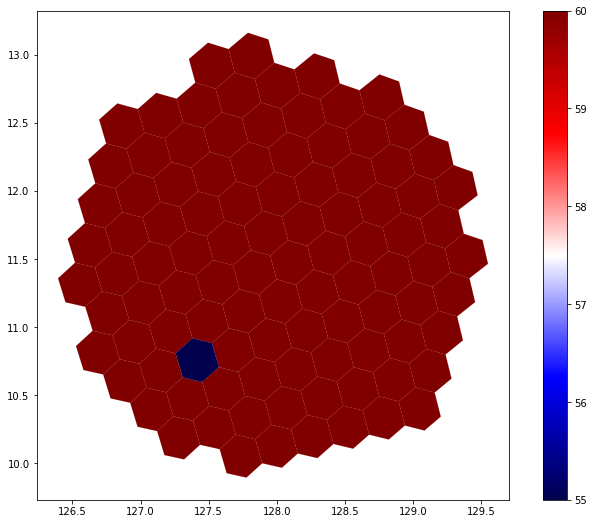

In [5]:
var = dspoints.maxLevelCell[:]
pc = plot_poly(var, dspoints.verticesOnCell.values-1, dspoints.nEdgesOnCell.values, 
               rad2deg(ds.lonVertex.values), rad2deg(ds.latVertex.values), colorbar=False, cmap='seismic')
#pc.set_clim((var.mean()-2e-5,var.mean()+2e-5))
plt.colorbar(pc)

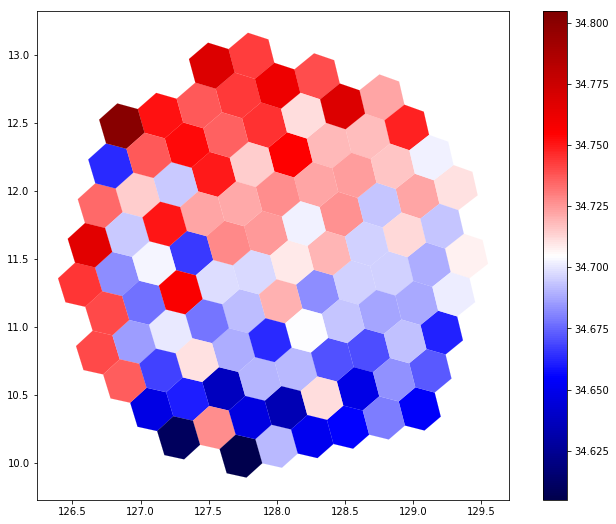

In [6]:
salinity = dspoints.salinity[iTime,:,kLevel]
pc = plot_poly(salinity, dspoints.verticesOnCell.values-1, dspoints.nEdgesOnCell.values, 
               rad2deg(ds.lonVertex.values), rad2deg(ds.latVertex.values), colorbar=False, cmap='seismic')
pc.set_clim((salinity.mean()-.1,salinity.mean()+.1))
plt.colorbar(pc)

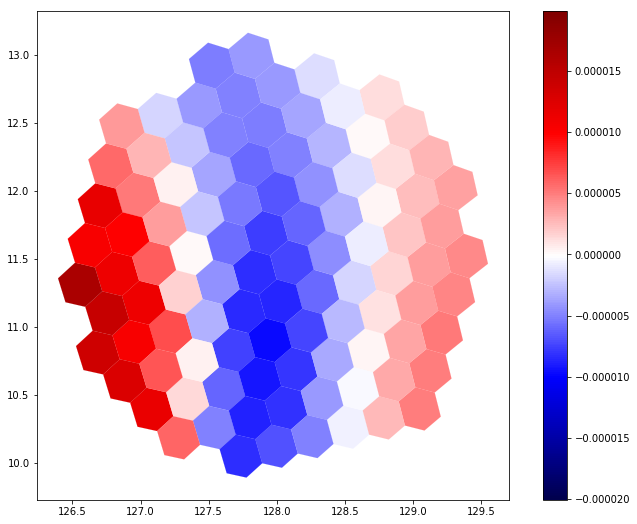

In [7]:
var = dspoints.vertTransportVelocityTop[iTime,:,kLevel+1]
pc = plot_poly(var, dspoints.verticesOnCell.values-1, dspoints.nEdgesOnCell.values, 
               rad2deg(ds.lonVertex.values), rad2deg(ds.latVertex.values), colorbar=False, cmap='seismic')
pc.set_clim((var.mean()-2e-5,var.mean()+2e-5))
plt.colorbar(pc)

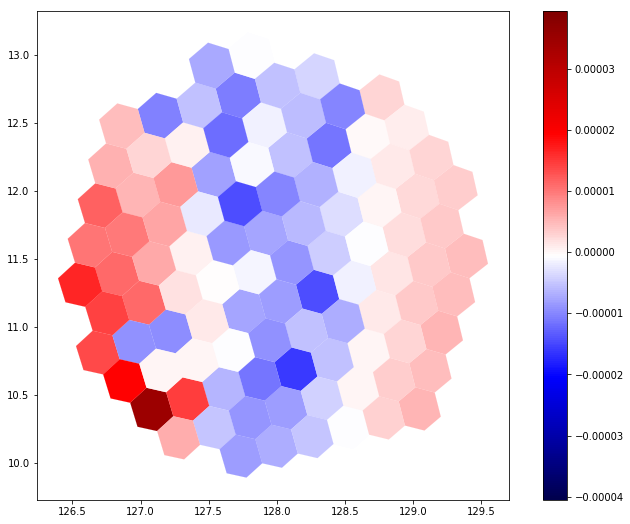

In [8]:
var = dspoints.vertVelocityTop[iTime,:,kLevel+1]
pc = plot_poly(var, dspoints.verticesOnCell.values-1, dspoints.nEdgesOnCell.values, 
               rad2deg(ds.lonVertex.values), rad2deg(ds.latVertex.values), colorbar=False, cmap='seismic')
pc.set_clim((var.mean()-4e-5,var.mean()+4e-5))
plt.colorbar(pc)

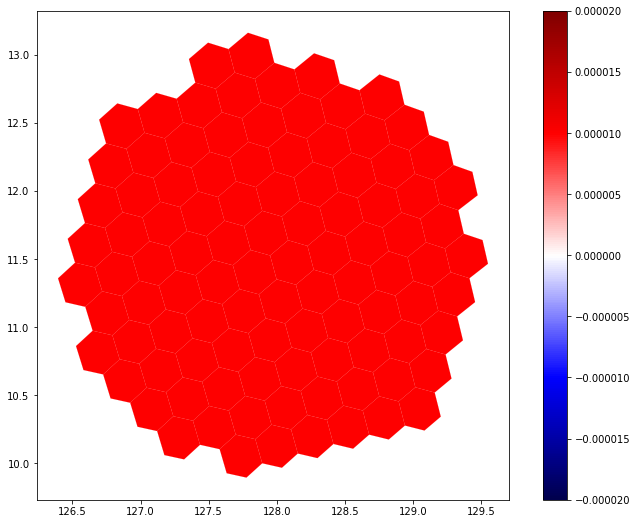

In [9]:
var = dspoints.vertDiffTopOfCell[iTime,:,kLevel+1]
pc = plot_poly(var, dspoints.verticesOnCell.values-1, dspoints.nEdgesOnCell.values, 
               rad2deg(ds.lonVertex.values), rad2deg(ds.latVertex.values), colorbar=False, cmap='seismic')
pc.set_clim(-2e-5,+2e-5)
plt.colorbar(pc)

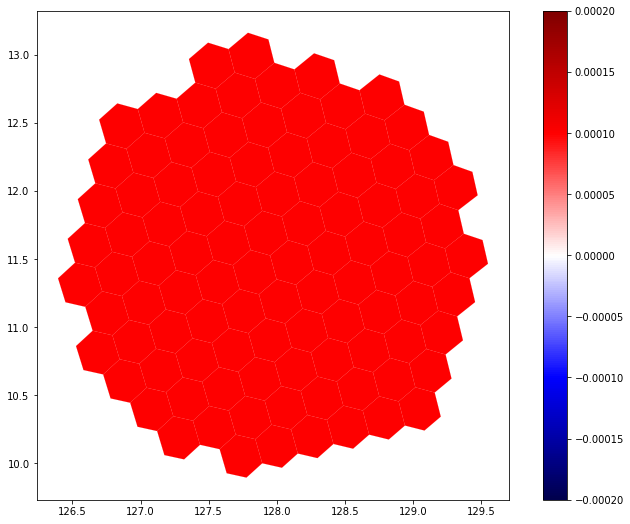

In [10]:
var = dspoints.vertViscTopOfCell[iTime,:,kLevel+1]
pc = plot_poly(var, dspoints.verticesOnCell.values-1, dspoints.nEdgesOnCell.values, 
               rad2deg(ds.lonVertex.values), rad2deg(ds.latVertex.values), colorbar=False, cmap='seismic')
pc.set_clim(-2e-4,+2e-4)
plt.colorbar(pc)

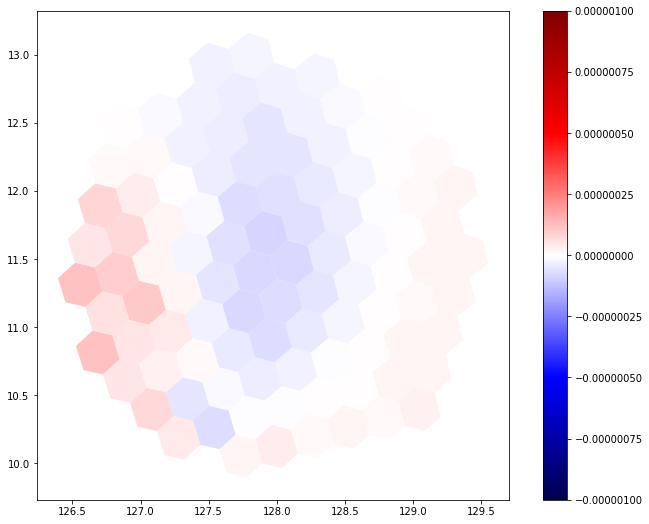

In [11]:
divergence = dspoints.divergence[iTime,:,kLevel]
pc = plot_poly(divergence, dspoints.verticesOnCell.values-1, dspoints.nEdgesOnCell.values, 
               rad2deg(ds.lonVertex.values), rad2deg(ds.latVertex.values), colorbar=False, cmap='seismic')
pc.set_clim((-1e-6,1e-6))
plt.colorbar(pc)

In [12]:
def plot_var(variable, time=-1, maxdepth=-5300.):
    if not 'nCells' in variable.dims:
        return
    variable = variable.isel(nCells=np.arange(10))
    nmax = np.minimum(ds.maxLevelCell.values.max(), np.where(zcoord < maxdepth)[0][0])
    for ii in np.arange(len(variable.nCells)):
        lon = rad2deg(variable.lonCell.values[ii])
        lat = rad2deg(variable.latCell.values[ii])
        plt.plot(variable[time,ii,:nmax],zcoord[:nmax], '-', label='lon=%.4f, lat=%.4f'%(lon,lat))
    plt.ylabel('Depth (m)')
    plt.legend(loc='best',ncol=2)
    attrs = variable.attrs
    plt.xlabel(attrs['long_name'][0:100] + ' ' + attrs['units'])
    

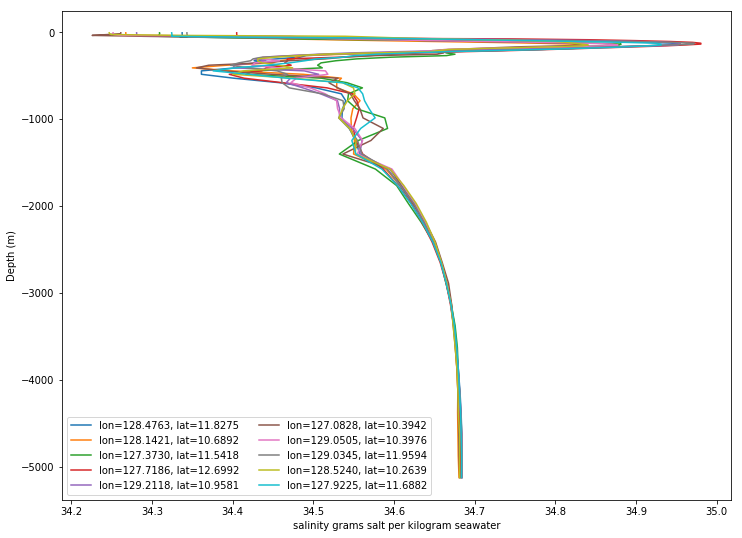

In [13]:
plot_var(dspoints.salinity,time=iTime)

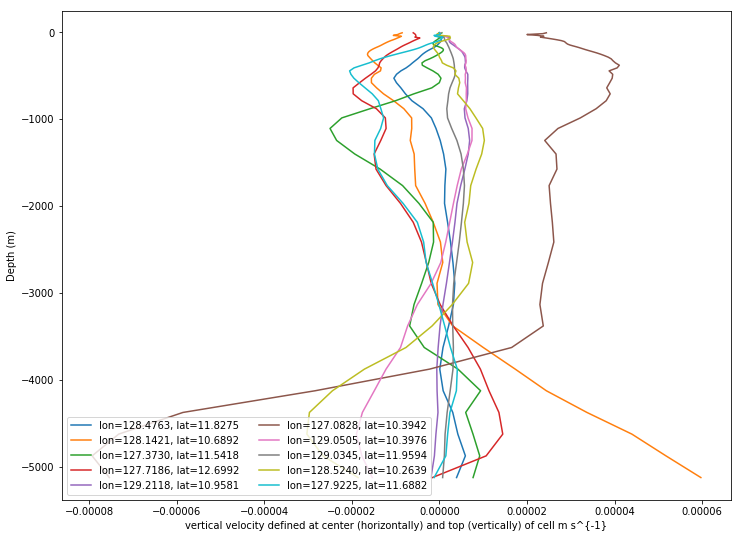

In [14]:
plot_var(dspoints.vertVelocityTop)

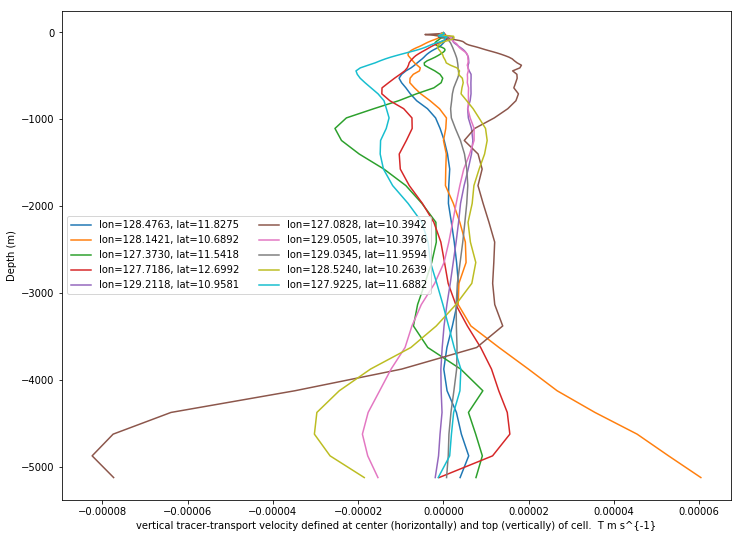

In [15]:
plot_var(dspoints.vertTransportVelocityTop)

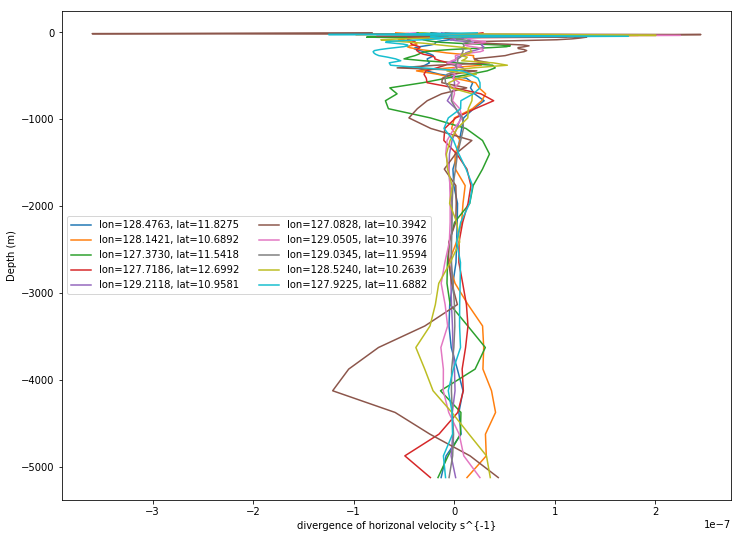

In [16]:
plot_var(dspoints.divergence)

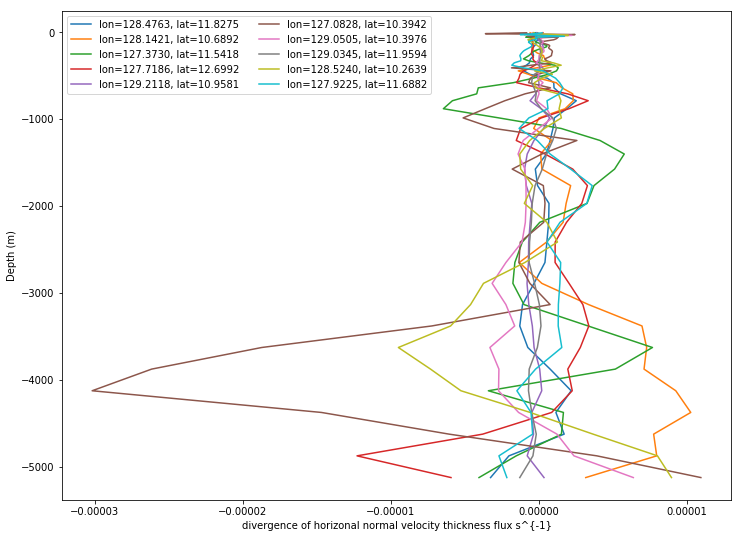

In [17]:
plot_var(dspoints.divergenceHU)

In [18]:
def plot_profile(variable, atime=-1, maxLayers=60, dc=None):
    for kk in np.arange(np.minimum(maxLayers,variable.shape[-1])):
        plt.figure()
        vartime = variable[atime,:,kk]
        vartime[np.where(vartime < -1e33)] = np.nan
        pc = plot_poly(vartime, dspoints.verticesOnCell.values-1, dspoints.nEdgesOnCell.values, rad2deg(ds.lonVertex.values), rad2deg(ds.latVertex.values), cmap='seismic', colorbar=False)
        plt.title(variable.name + ' Layer %d (%f m)'%(kk, ds.refZMid[kk]))
        if dc is not None:
            #pc.set_clim(np.nanmean(vartime)-dc, np.nanmean(vartime)+dc)
            pc.set_clim(-dc, +dc)
            cb = plt.colorbar(pc)

In [19]:

#plot_profile(dspoints.salinity, atime=iTime, dc=0.2)

In [20]:

#plot_profile(dspoints.vertTransportVelocityTop, atime=iTime, dc=1e-4)

/turquoise/usr/projects/climate/SHARED_CLIMATE/anaconda_envs/default-2.7/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


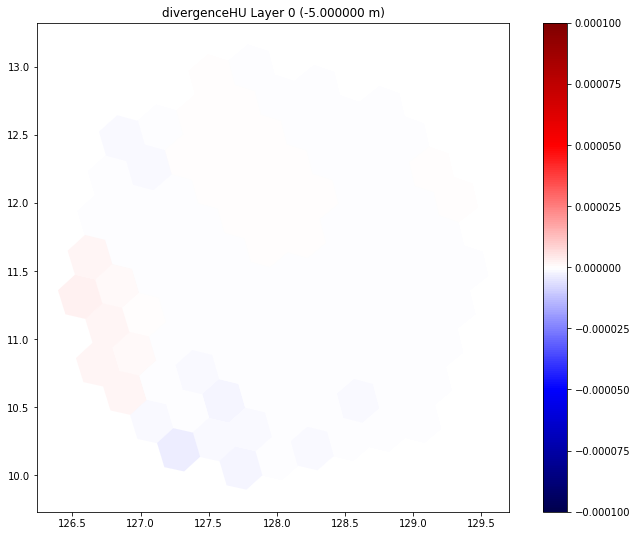

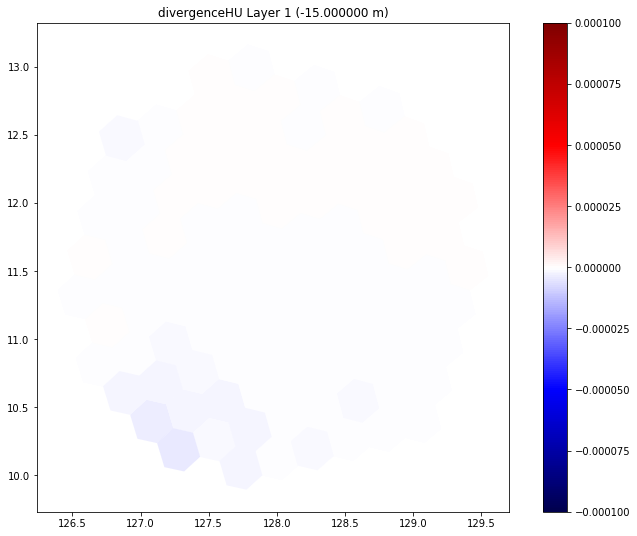

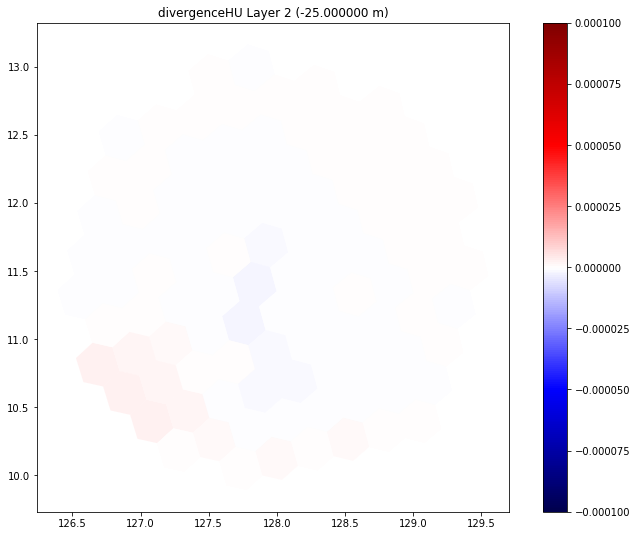

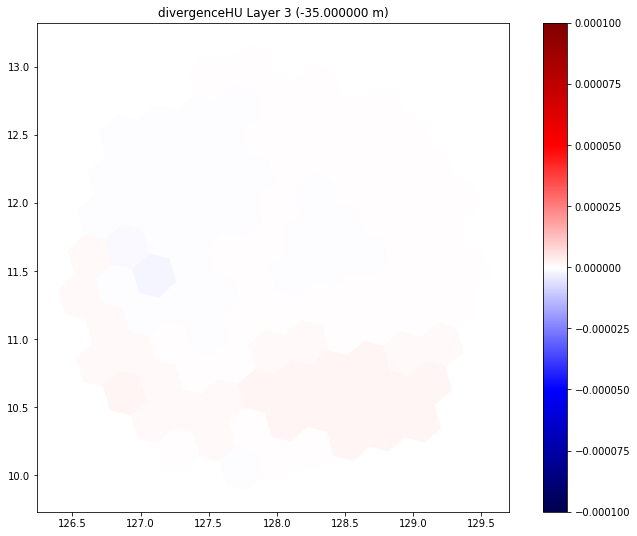

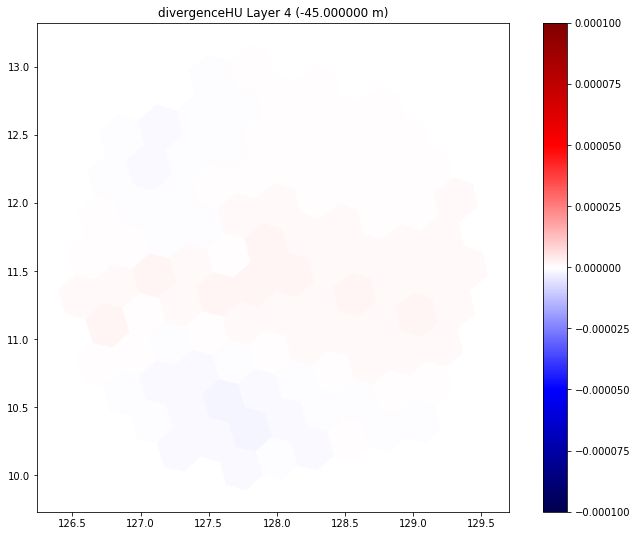

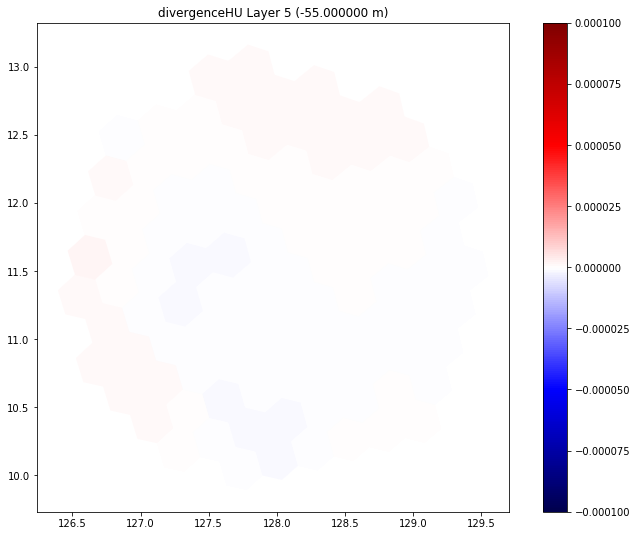

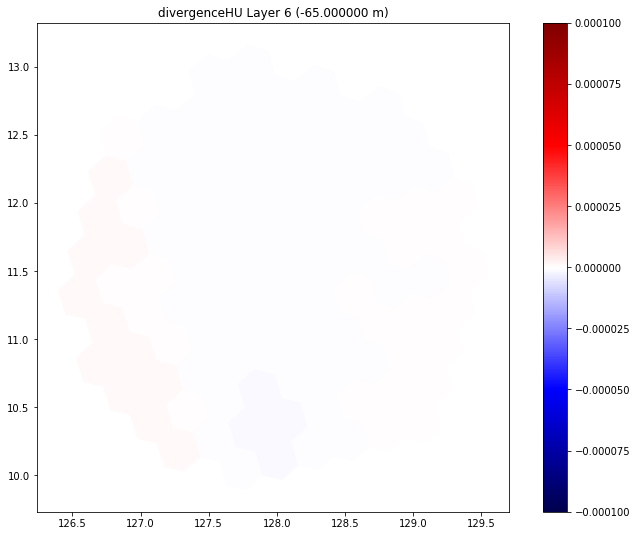

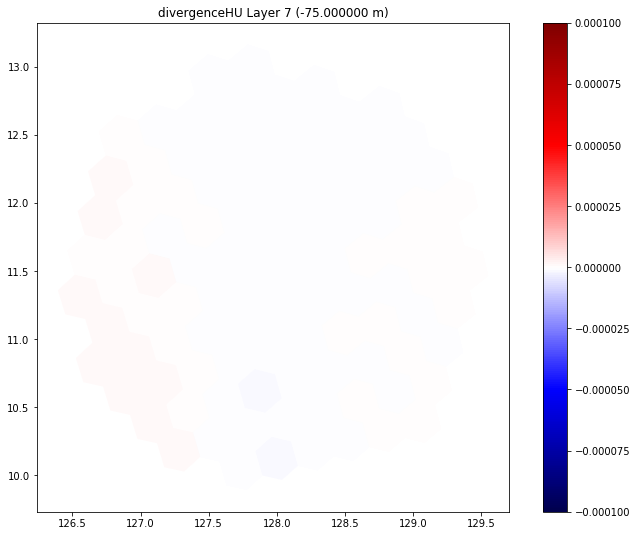

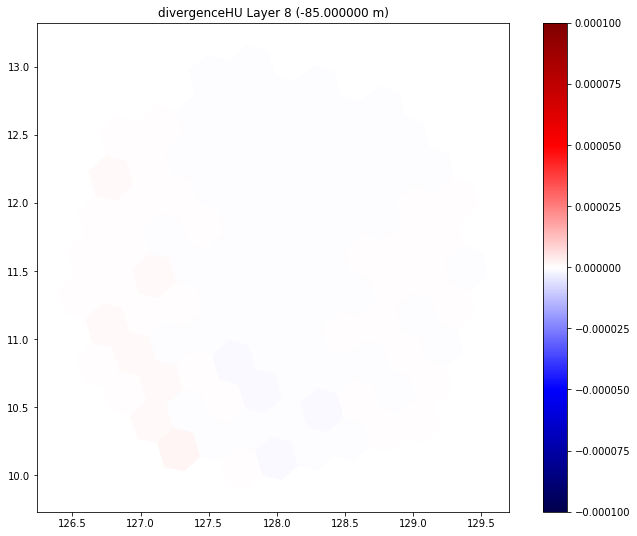

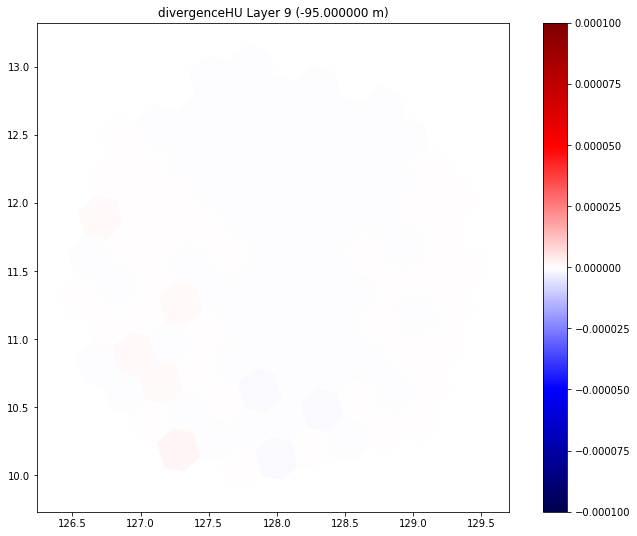

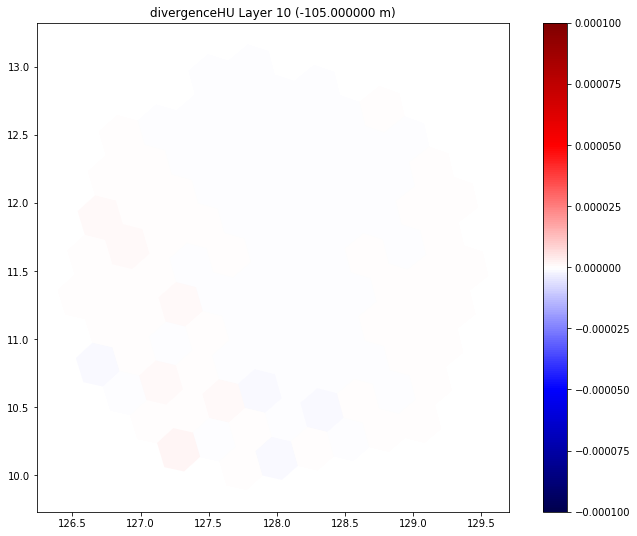

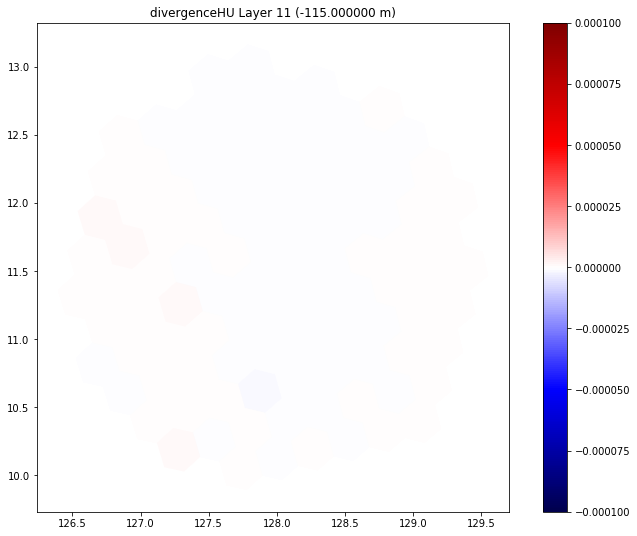

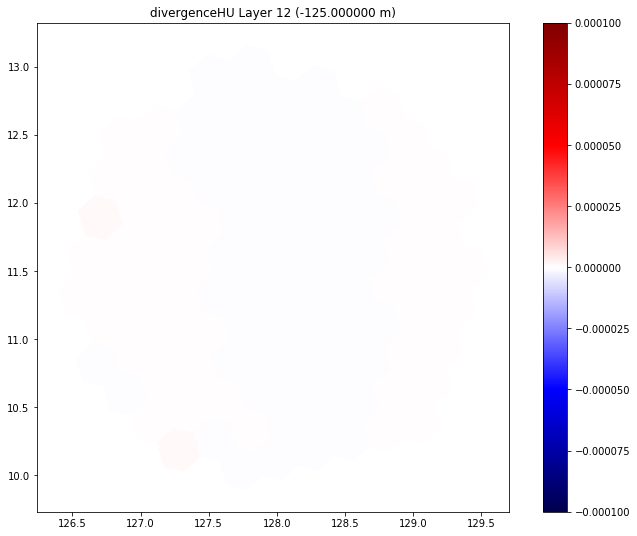

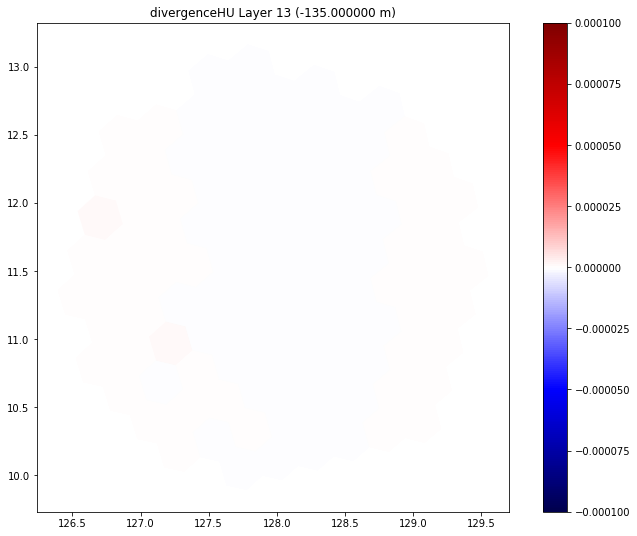

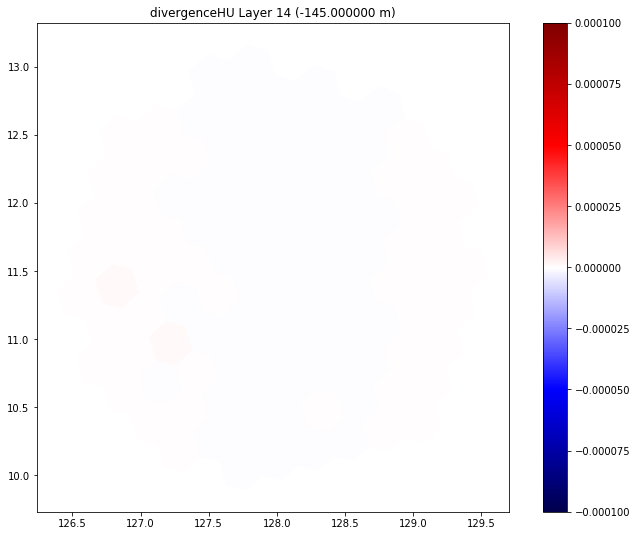

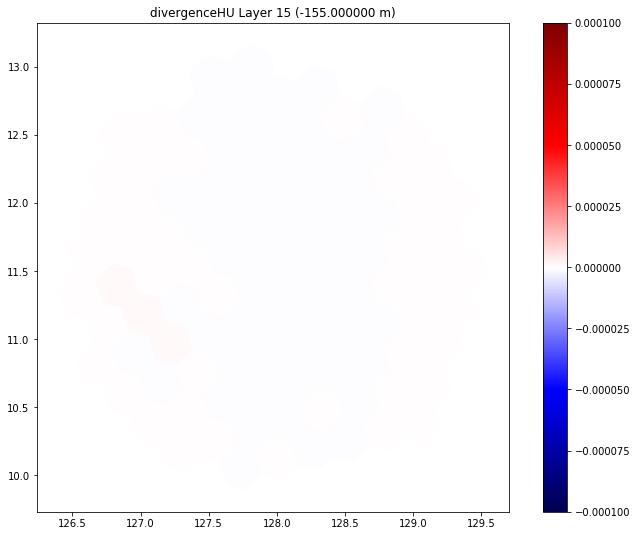

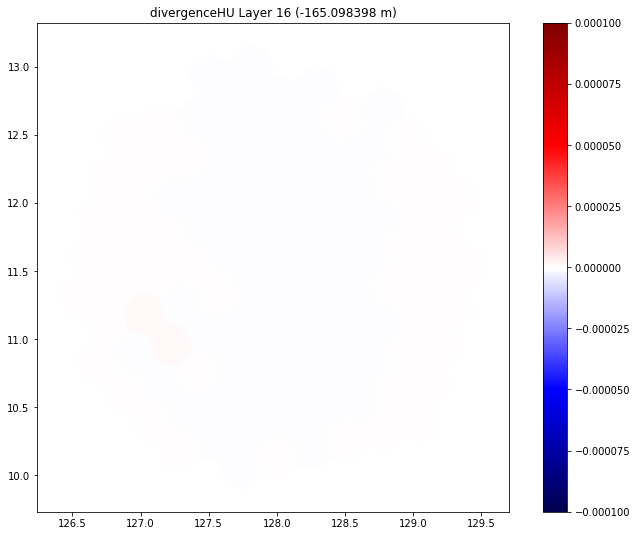

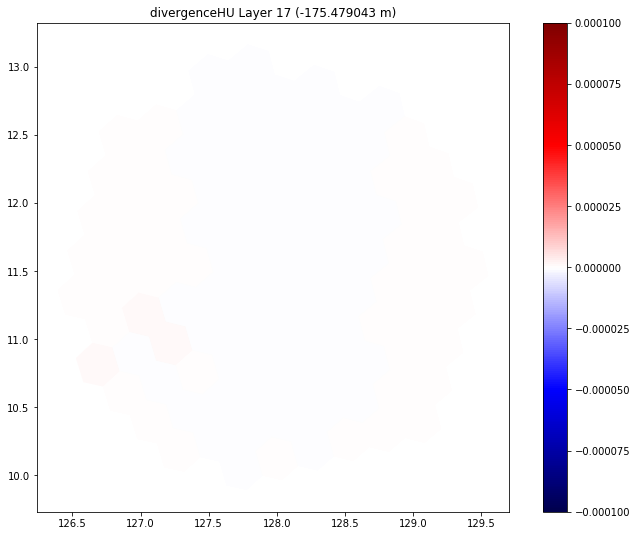

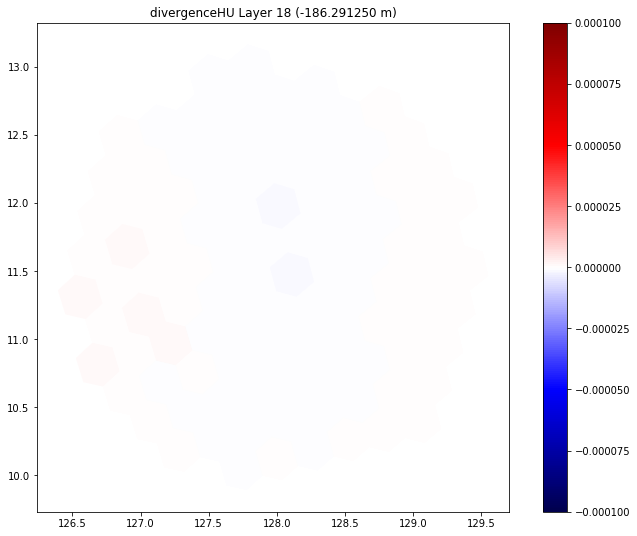

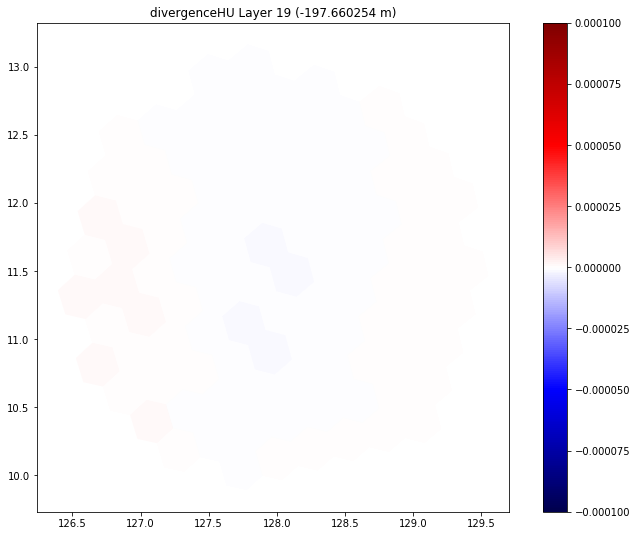

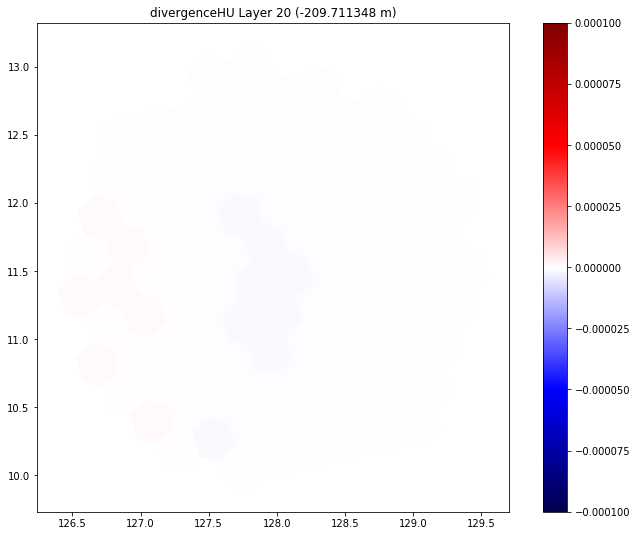

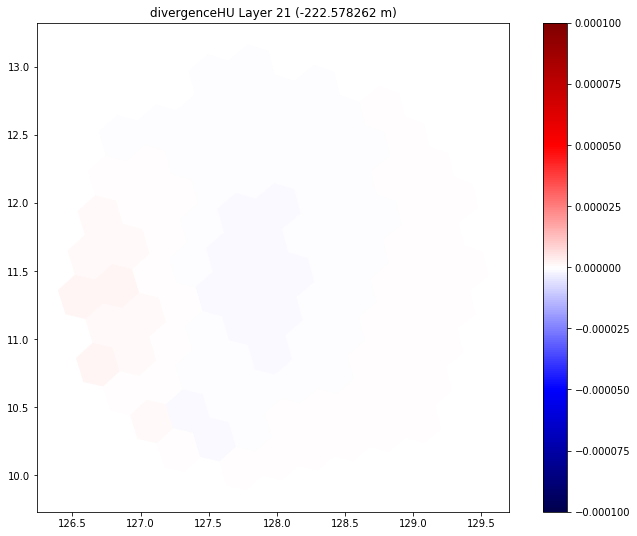

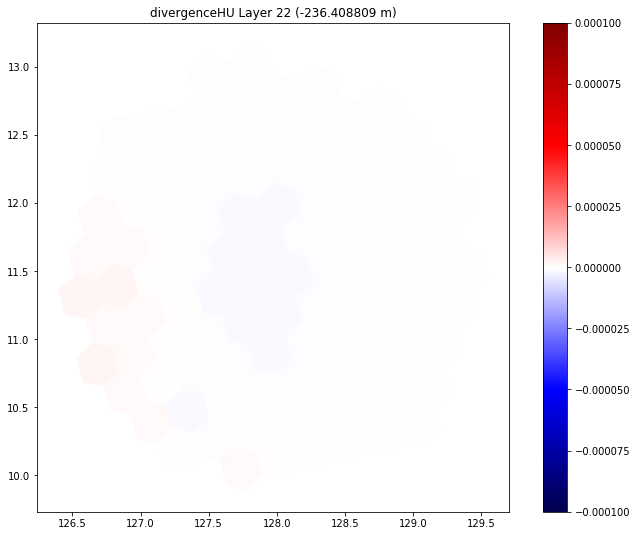

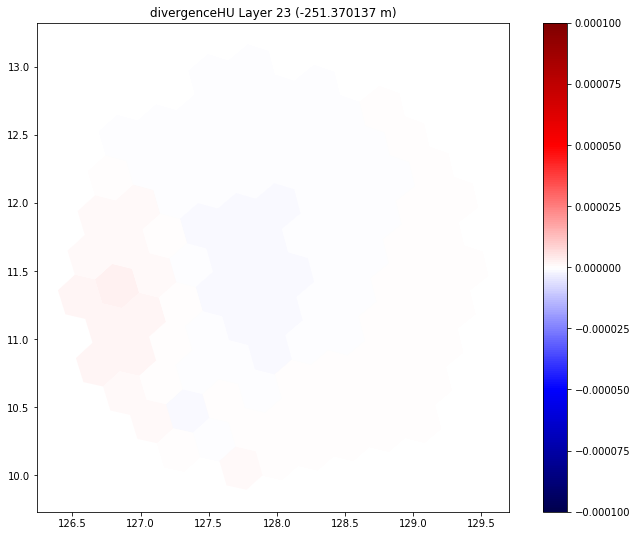

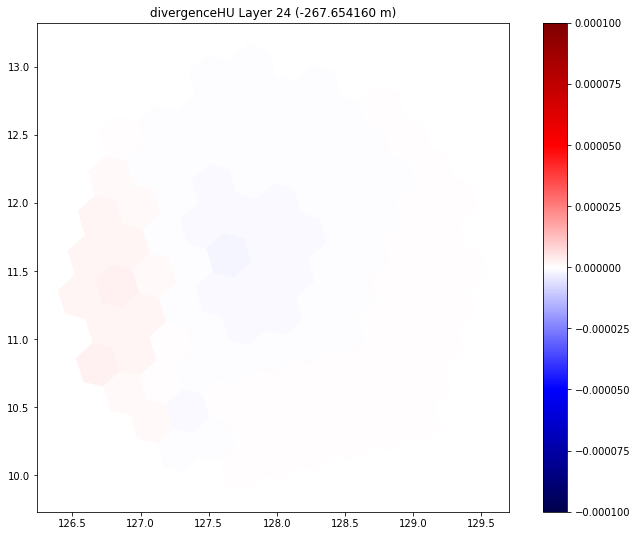

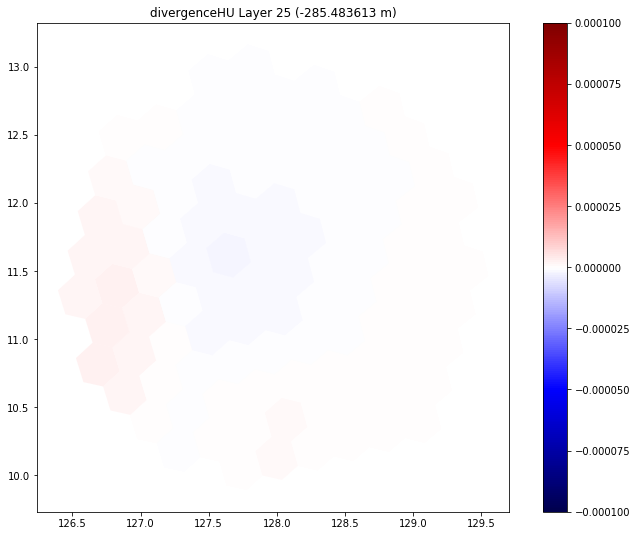

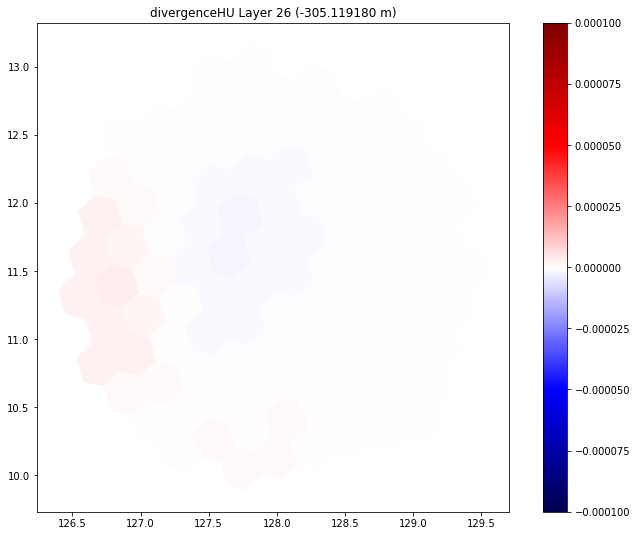

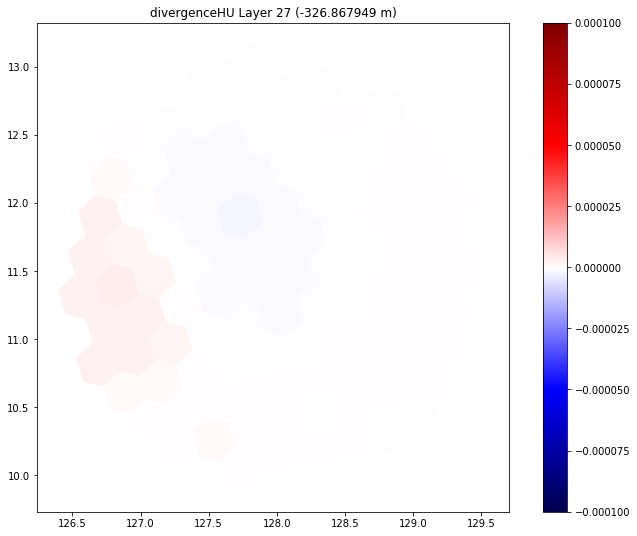

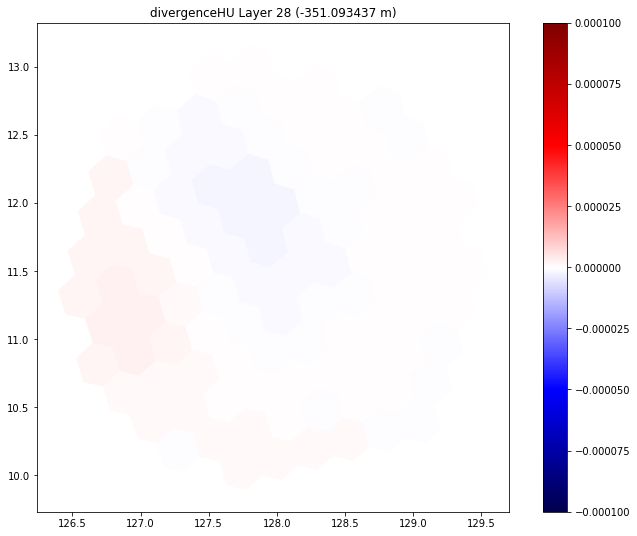

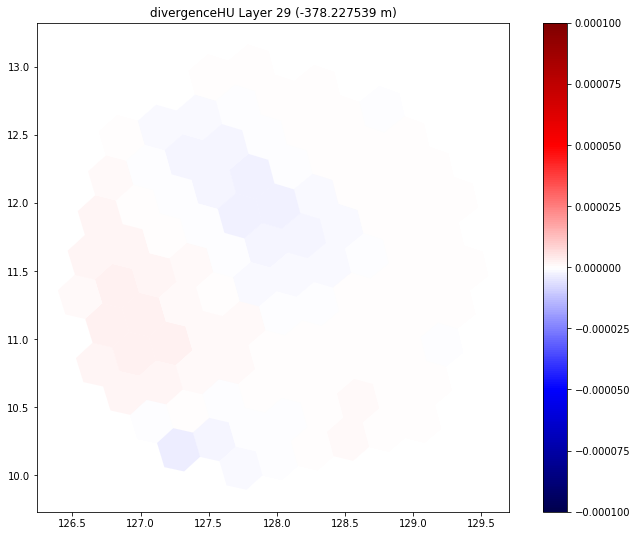

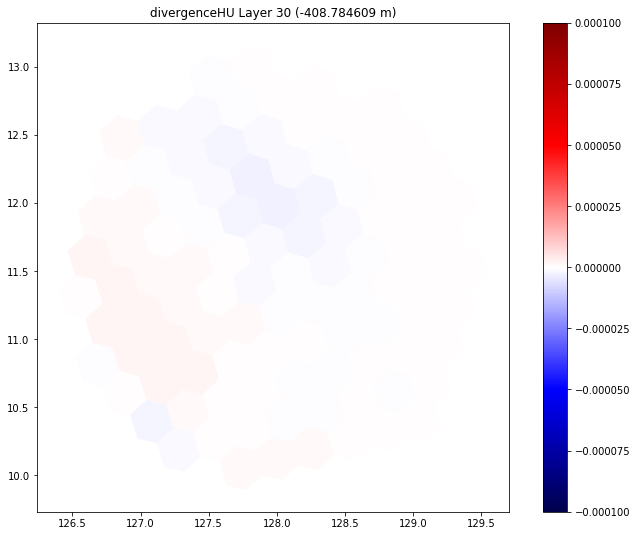

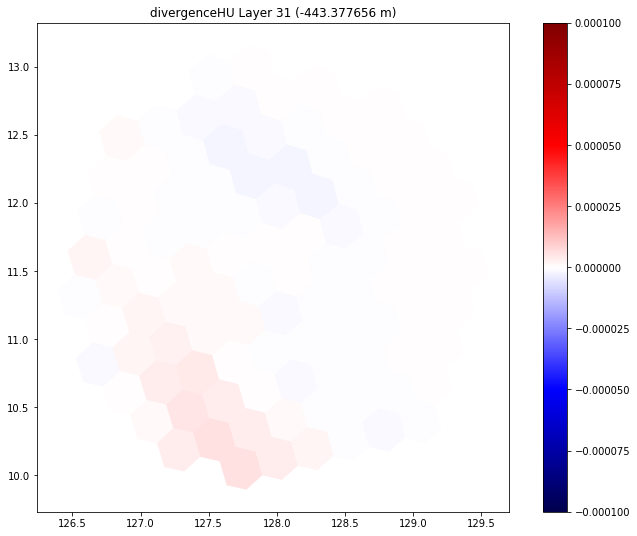

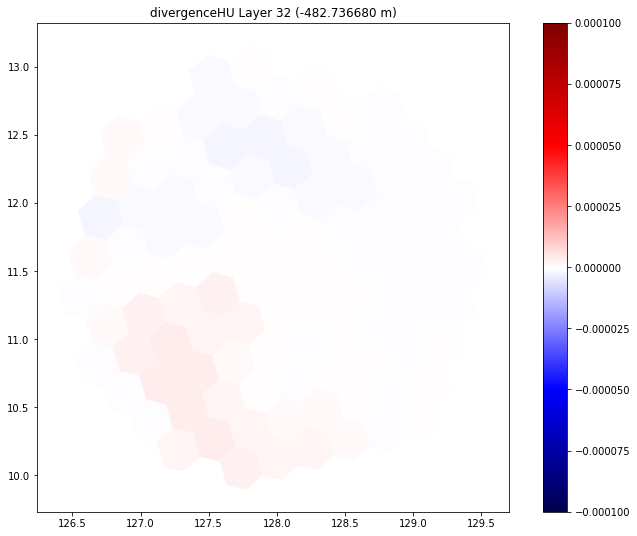

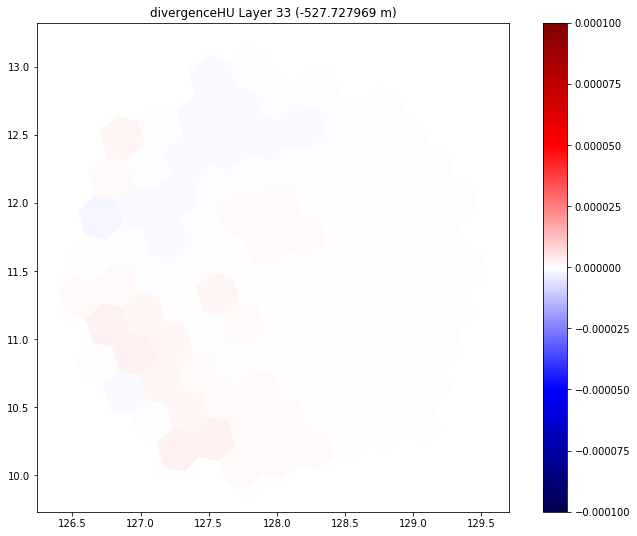

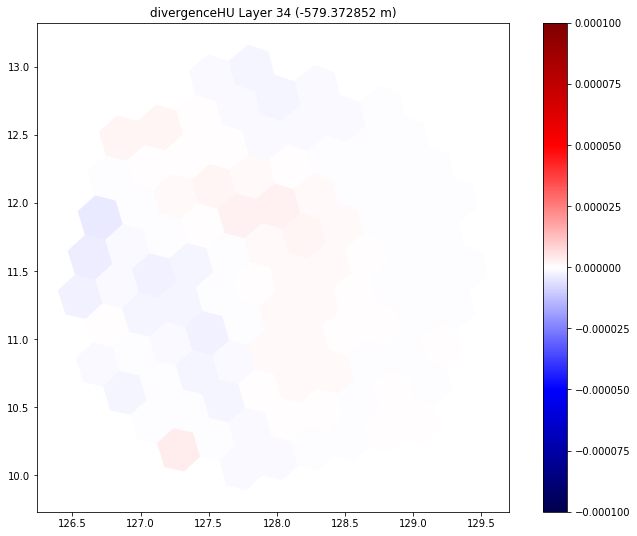

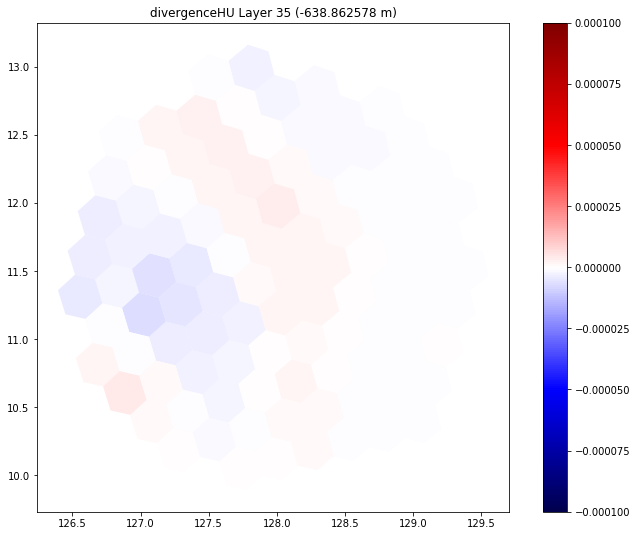

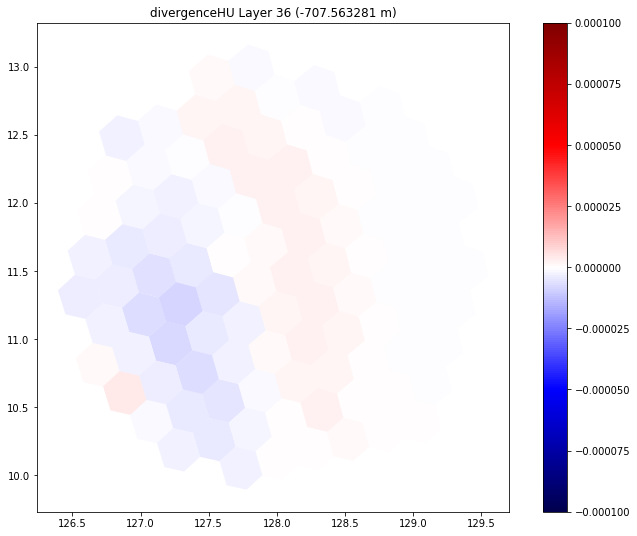

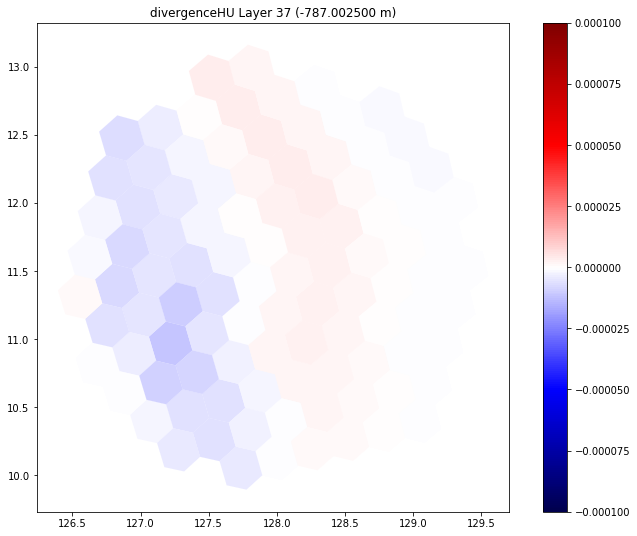

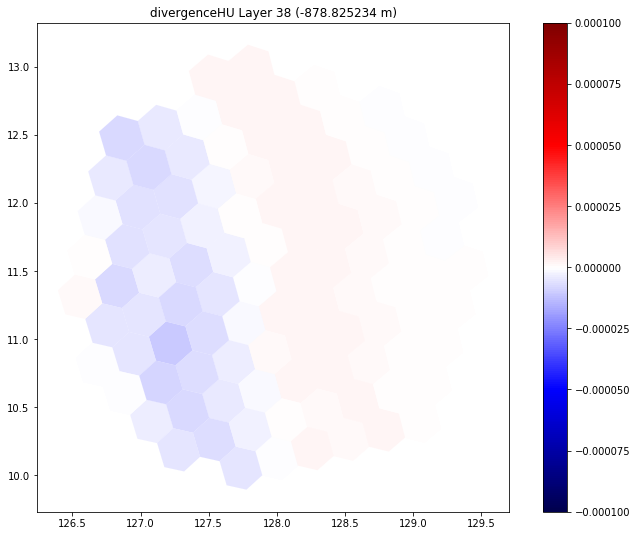

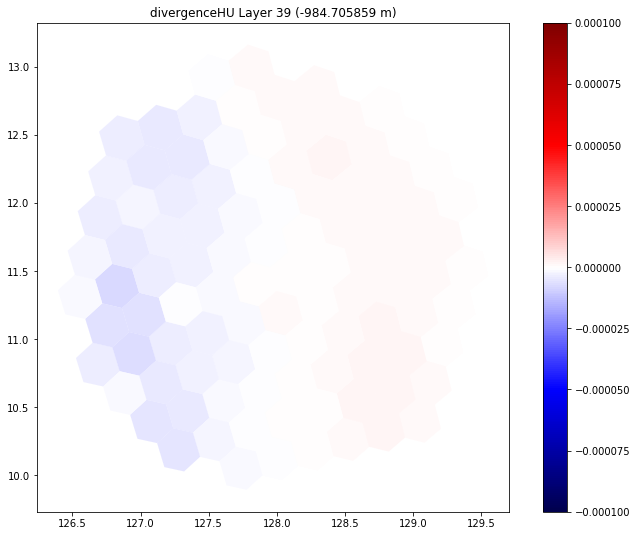

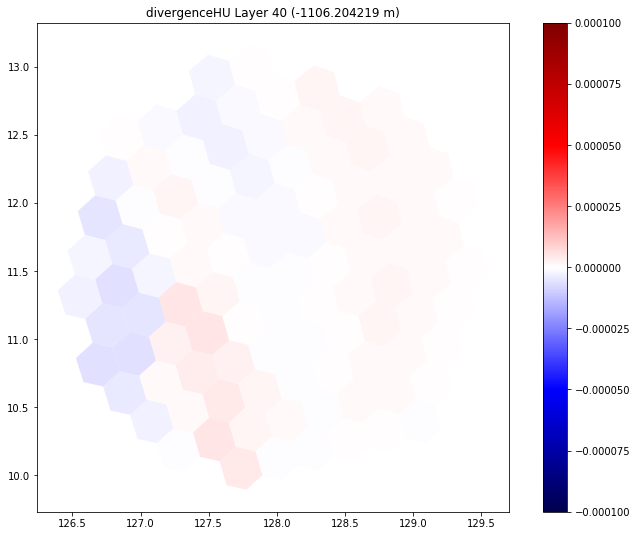

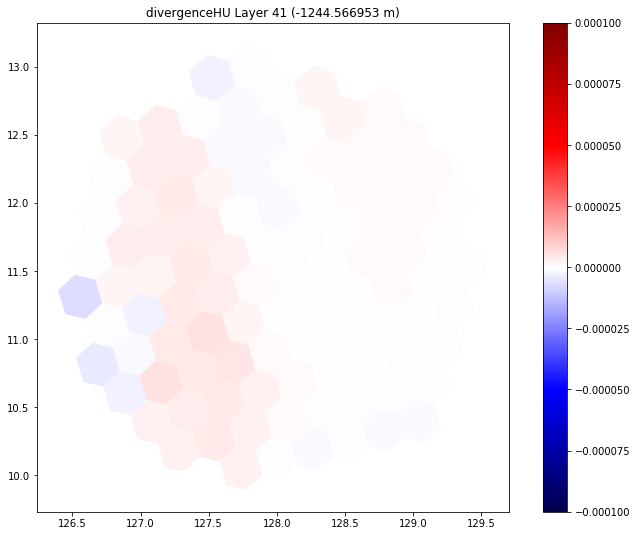

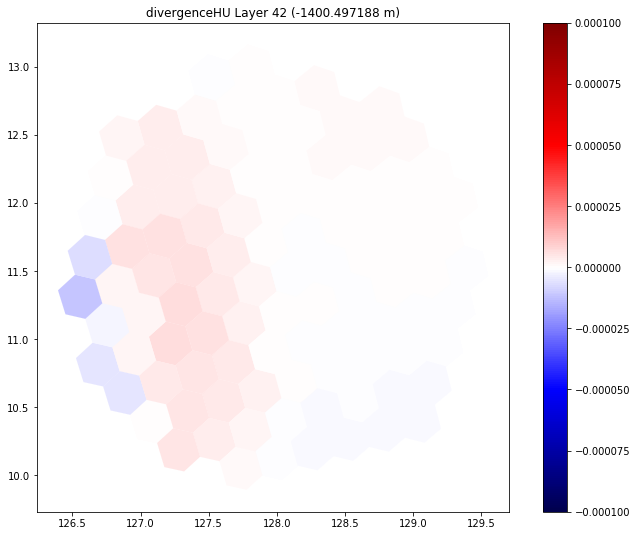

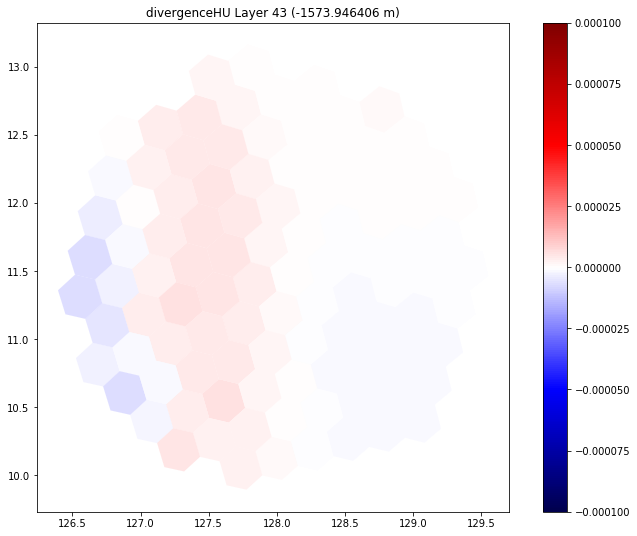

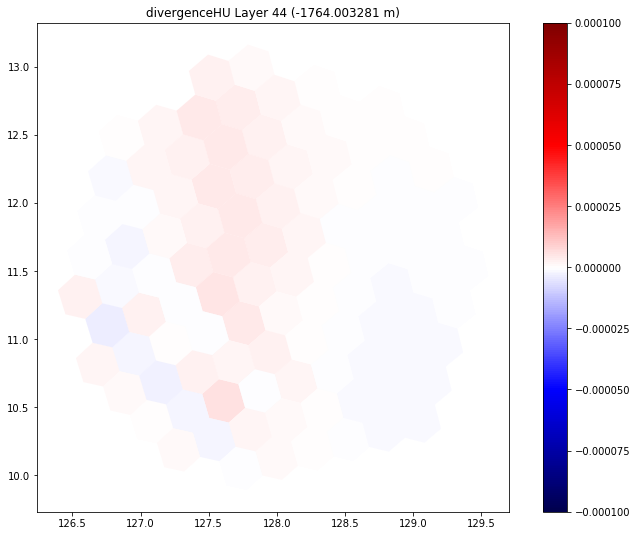

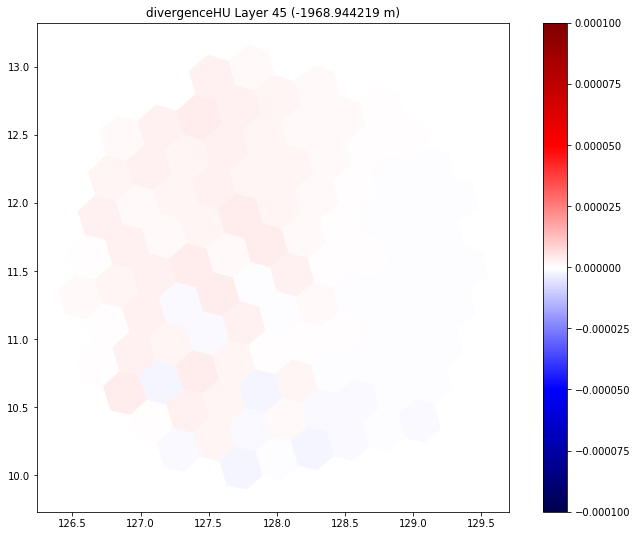

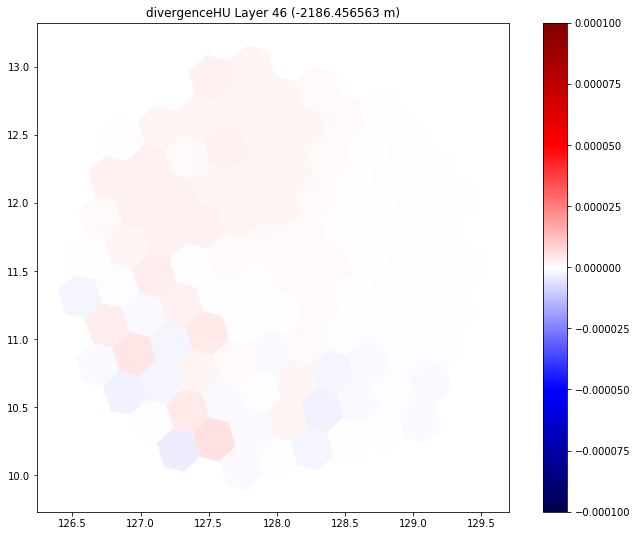

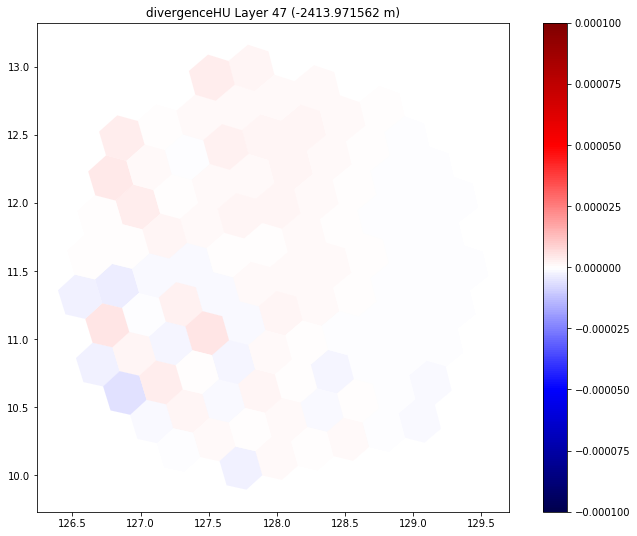

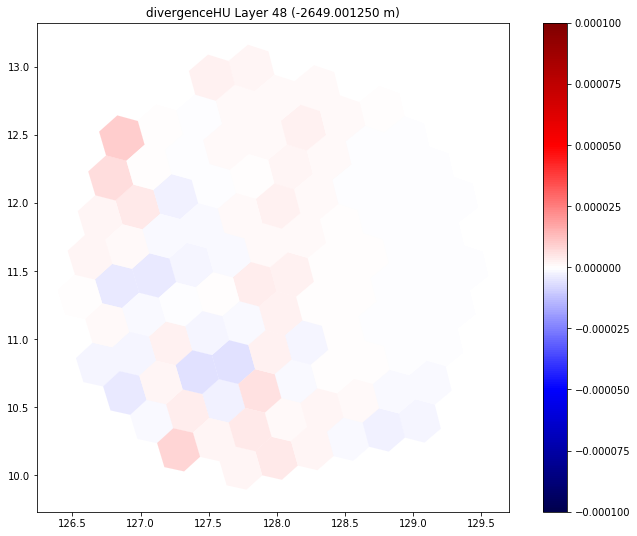

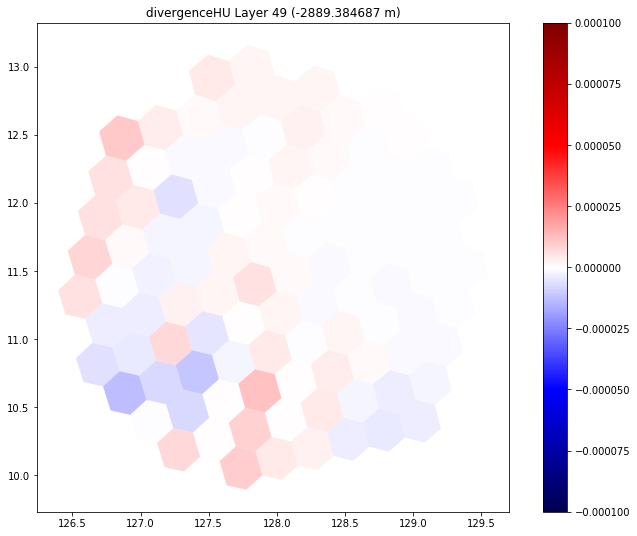

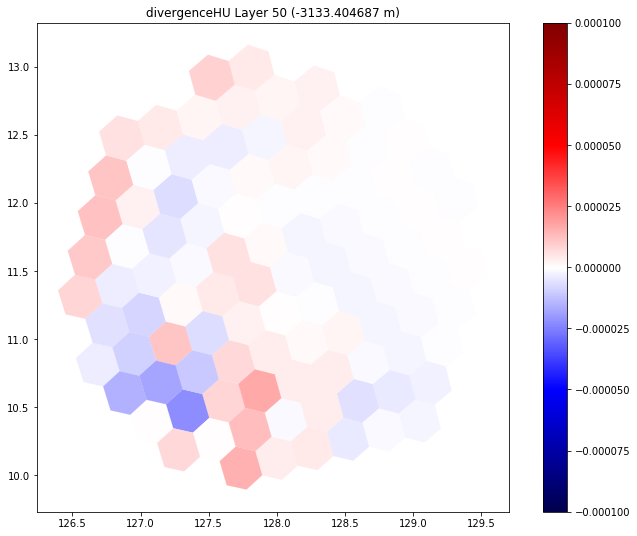

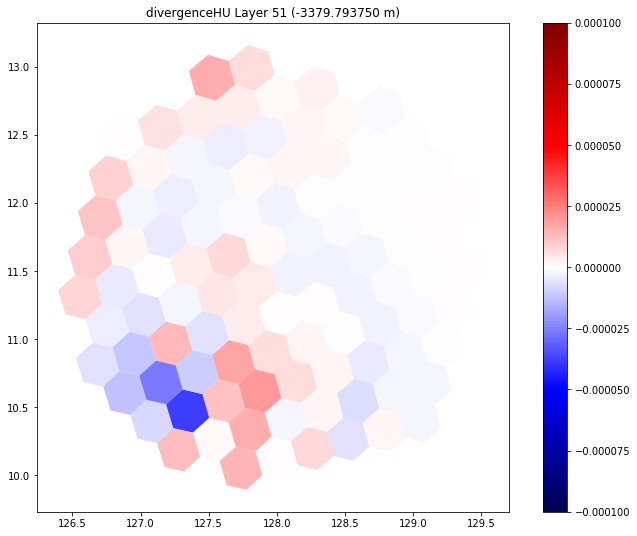

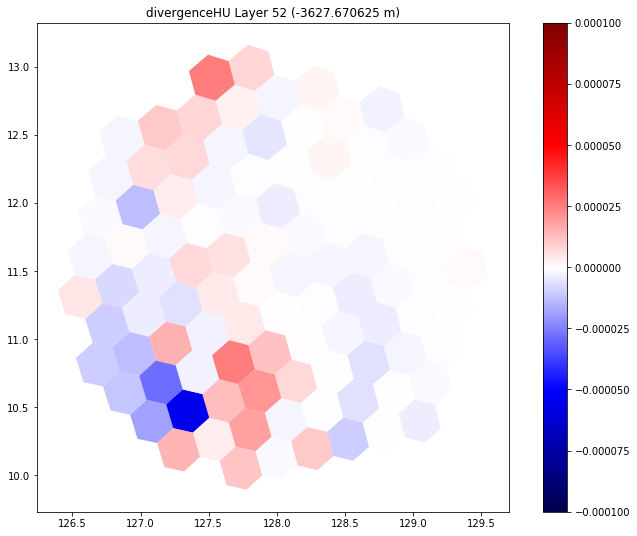

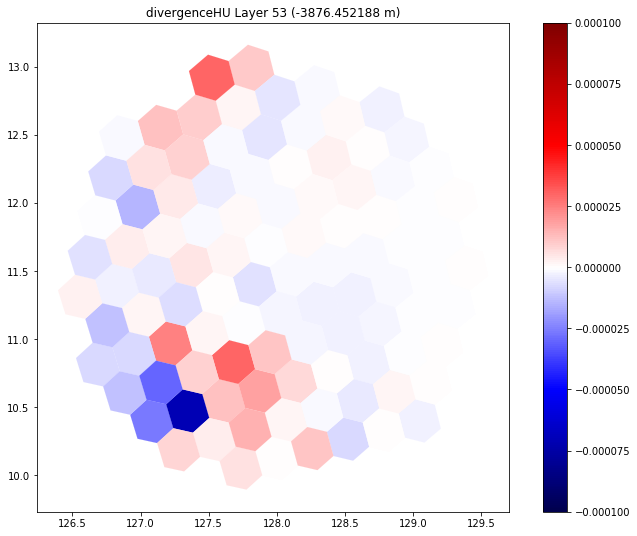

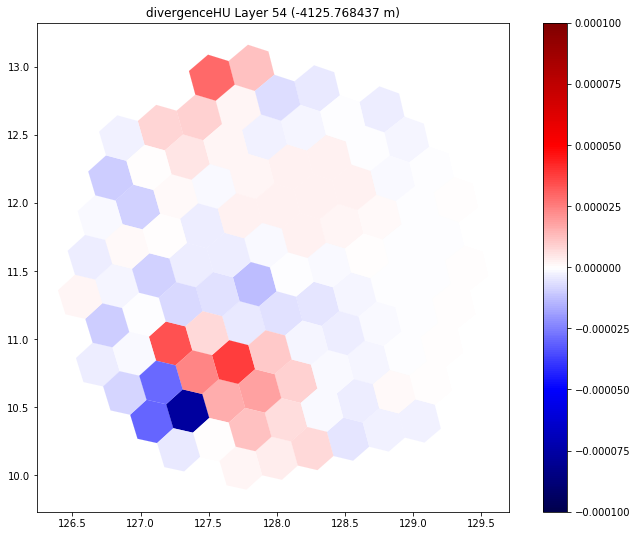

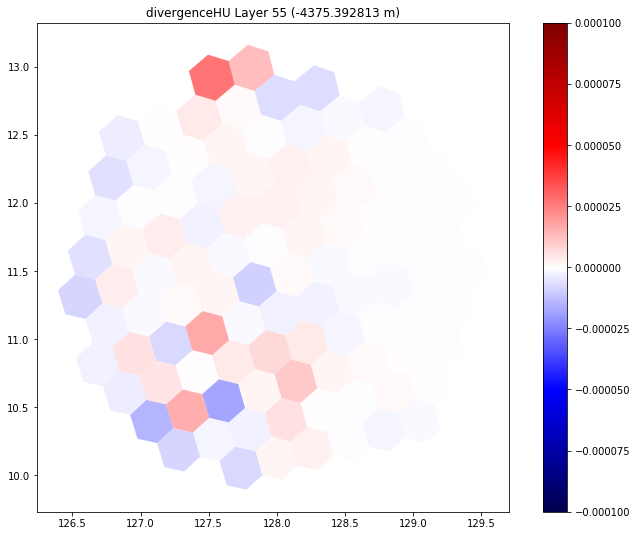

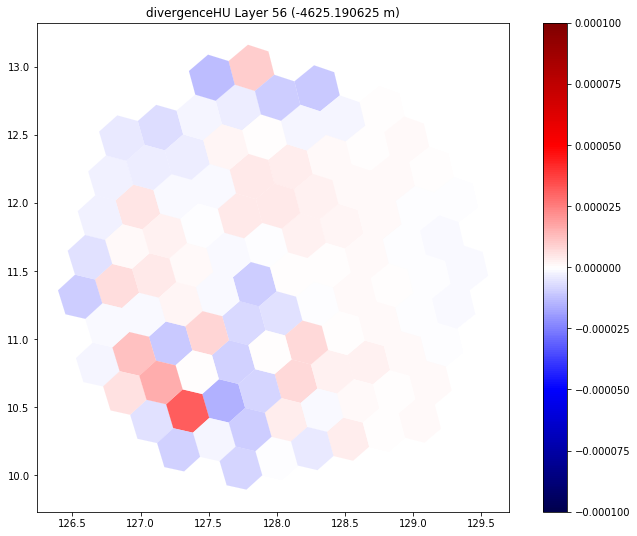

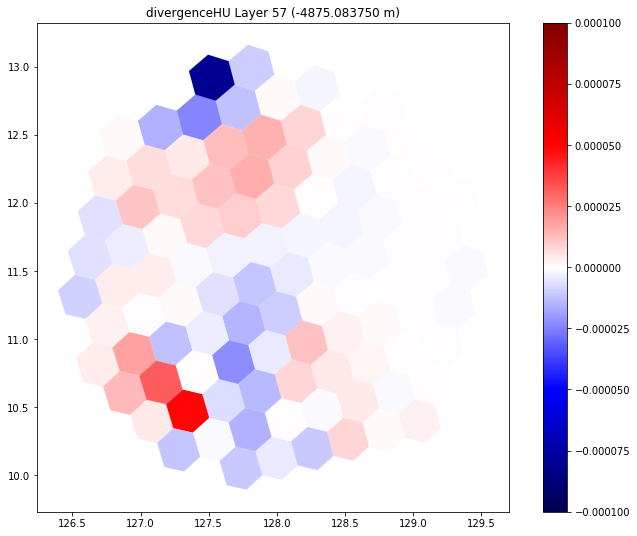

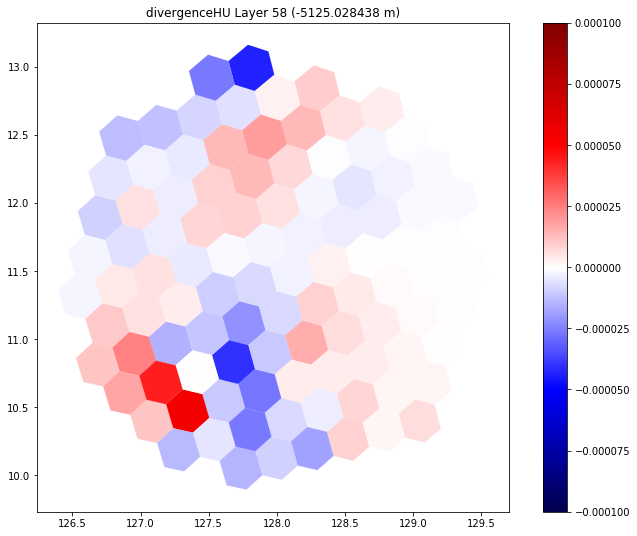

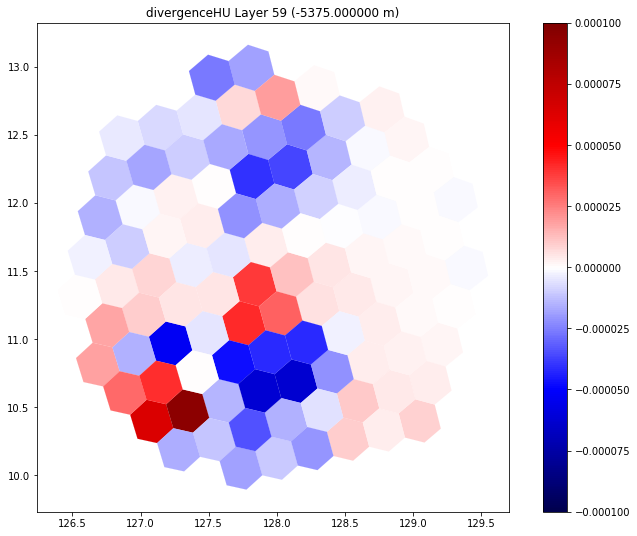

In [21]:

plot_profile(dspoints.divergenceHU, atime=iTime, dc=1e-4)

In [22]:
# define plotting location and number of cells
plotlon = 171
plotlat = 0
ntotal = 100

dist = (ds.lonCell.values - deg2rad(plotlon))**2.0 + (ds.latCell.values - deg2rad(plotlat))**2.0
points = np.where(dist < np.sort(dist)[ntotal])[0] # np.min(dist))[0]
dspoints = ds.isel(nCells=points)

#plt.plot(rad2deg(ds.lonCell), rad2deg(ds.latCell),'.',ms=0.1)
#plt.plot(rad2deg(dspoints.lonCell), rad2deg(dspoints.latCell), 'r.')

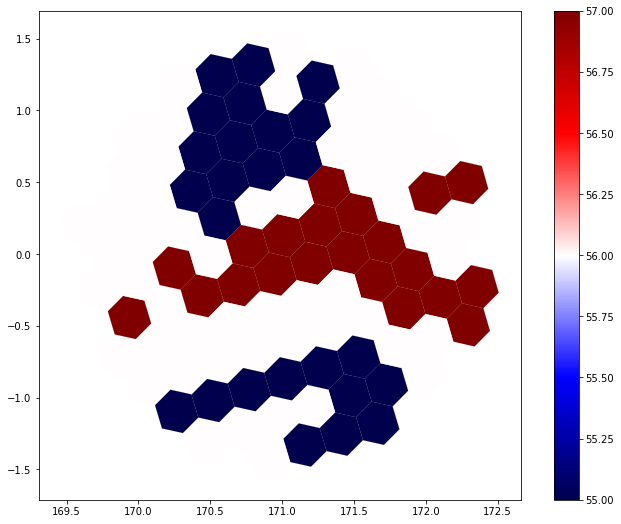

In [23]:
var = dspoints.maxLevelCell[:]
pc = plot_poly(var, dspoints.verticesOnCell.values-1, dspoints.nEdgesOnCell.values, 
               rad2deg(ds.lonVertex.values), rad2deg(ds.latVertex.values), colorbar=False, cmap='seismic')
#pc.set_clim((var.mean()-2e-5,var.mean()+2e-5))
plt.colorbar(pc)

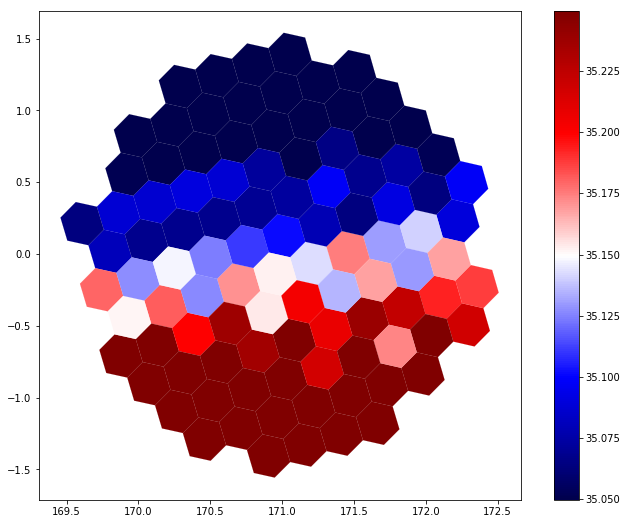

In [24]:
salinity = dspoints.salinity[iTime,:,kLevel]
pc = plot_poly(salinity, dspoints.verticesOnCell.values-1, dspoints.nEdgesOnCell.values, 
               rad2deg(ds.lonVertex.values), rad2deg(ds.latVertex.values), colorbar=False, cmap='seismic')
pc.set_clim((salinity.mean()-.2,salinity.mean()+.2))
plt.colorbar(pc)

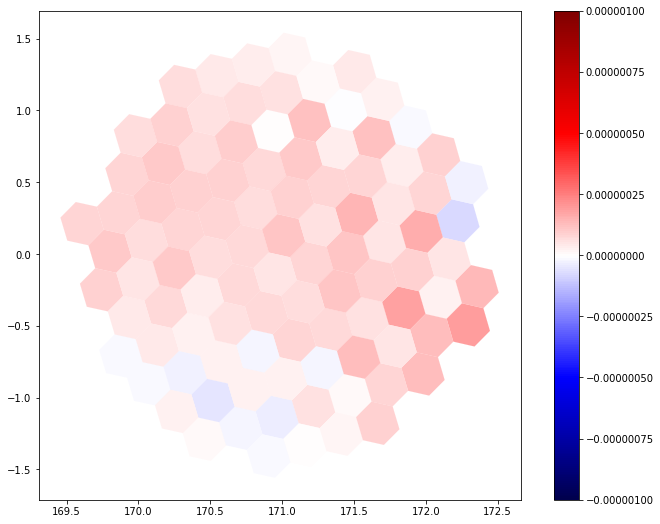

In [25]:
divergence = dspoints.divergence[iTime,:,kLevel]
pc = plot_poly(divergence, dspoints.verticesOnCell.values-1, dspoints.nEdgesOnCell.values, 
               rad2deg(ds.lonVertex.values), rad2deg(ds.latVertex.values), colorbar=False, cmap='seismic')
pc.set_clim((-1e-6,1e-6))
plt.colorbar(pc)

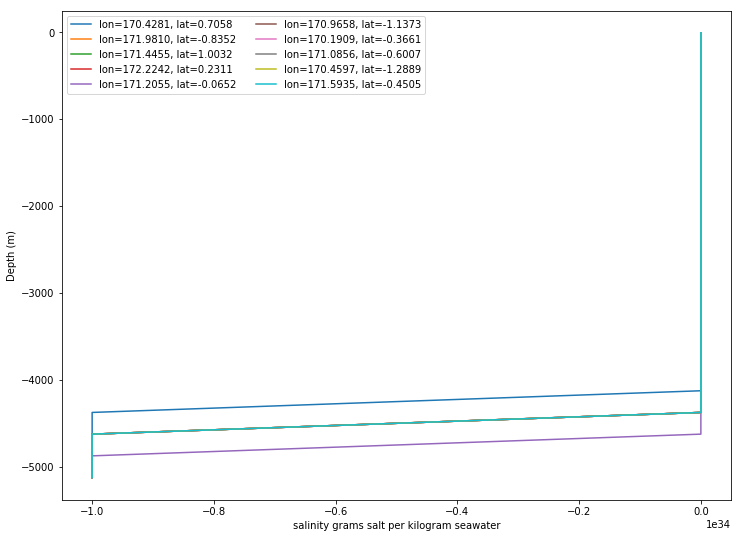

In [26]:
plot_var(dspoints.salinity,time=iTime)

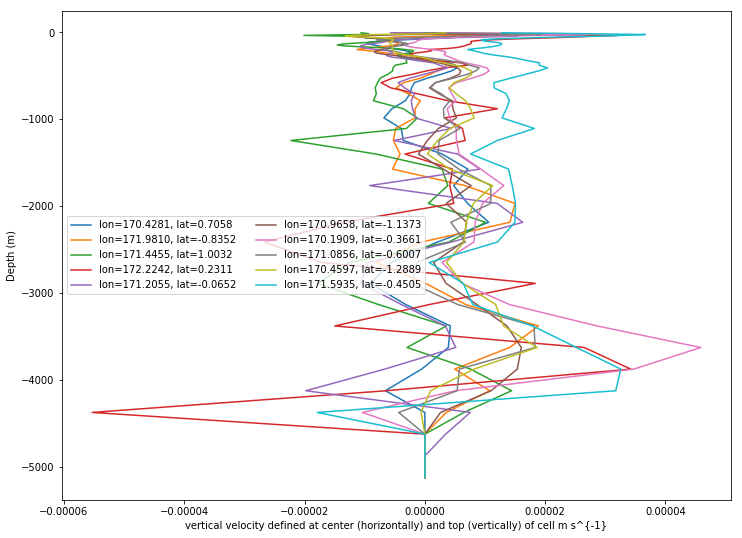

In [27]:
plot_var(dspoints.vertVelocityTop)

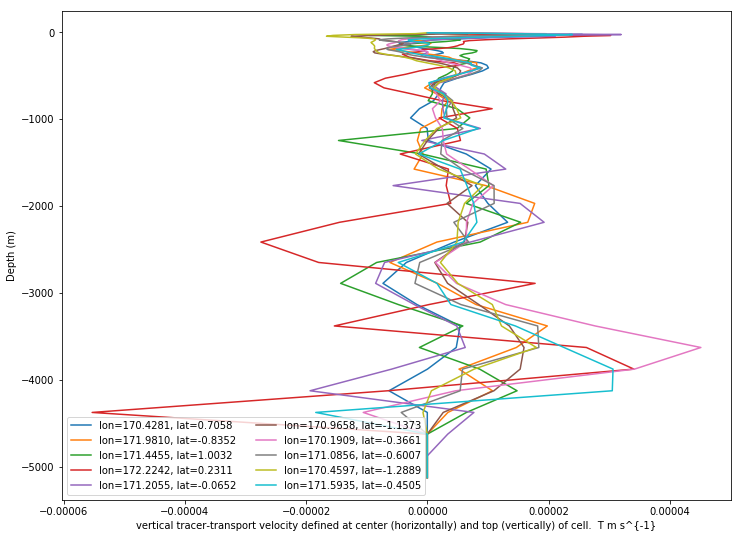

In [28]:
plot_var(dspoints.vertTransportVelocityTop)

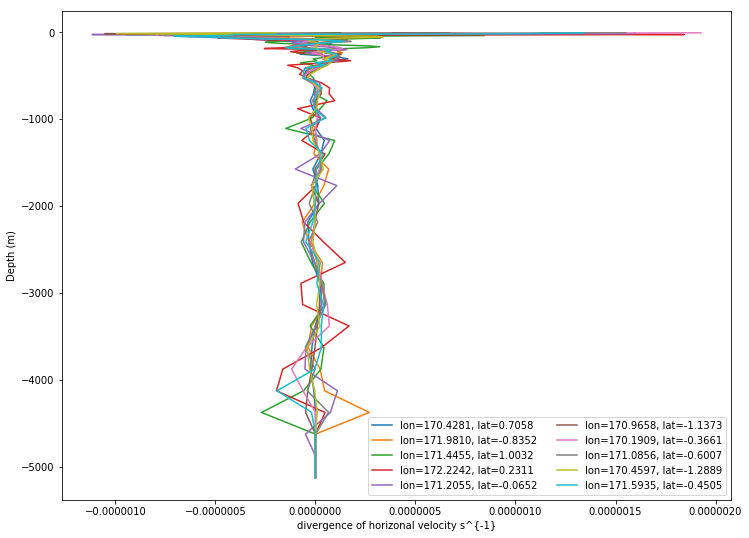

In [29]:
plot_var(dspoints.divergence)

In [30]:
#plot_profile(dspoints.salinity, atime=iTime, dc=2e-4)

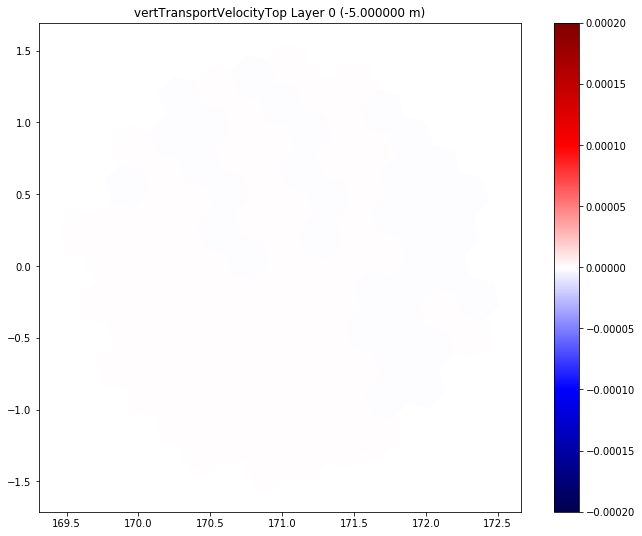

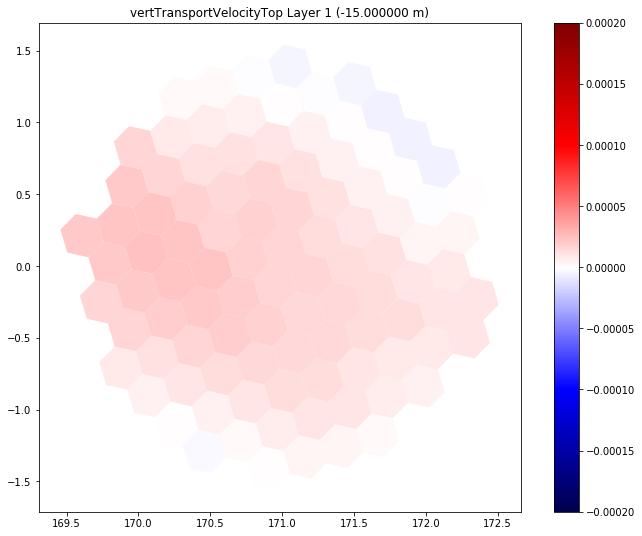

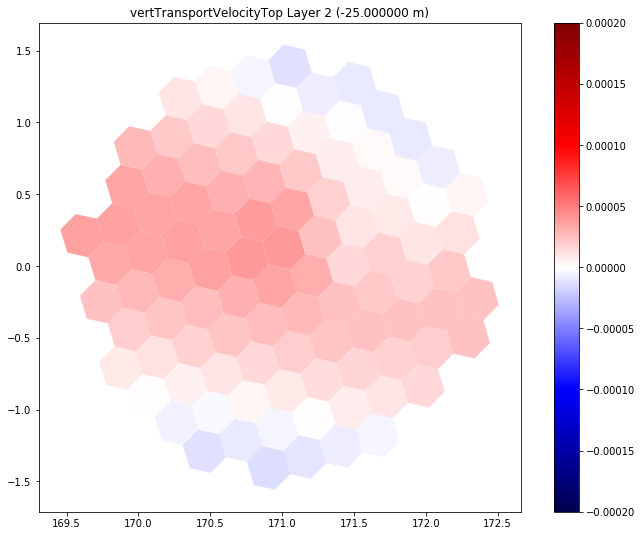

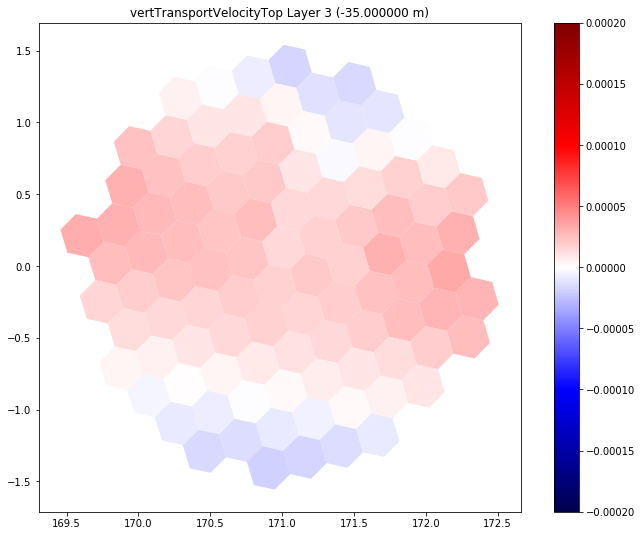

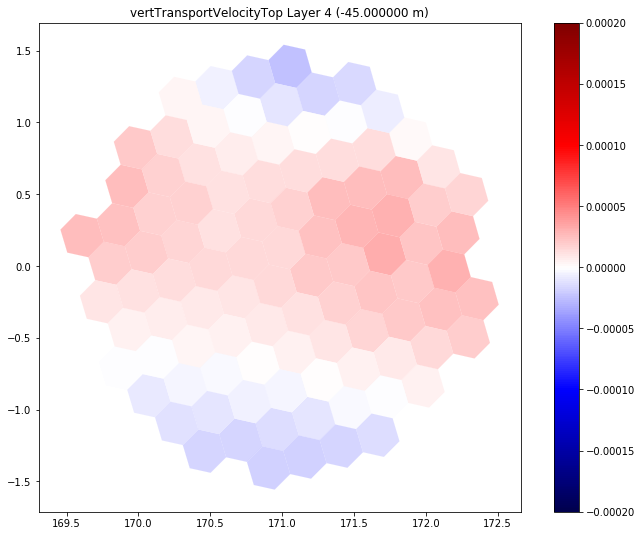

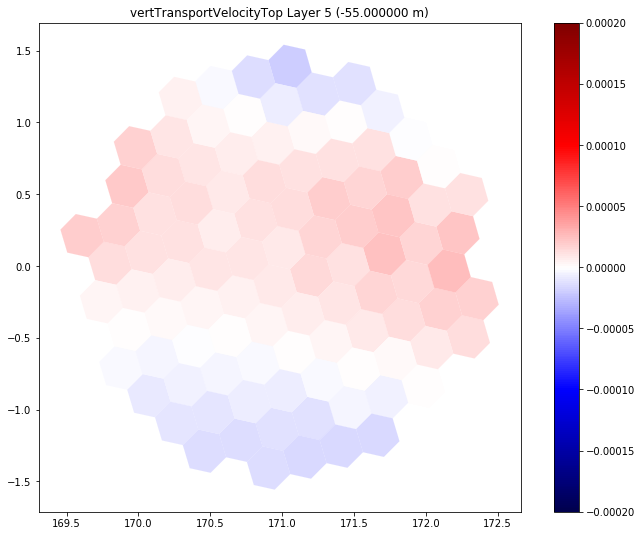

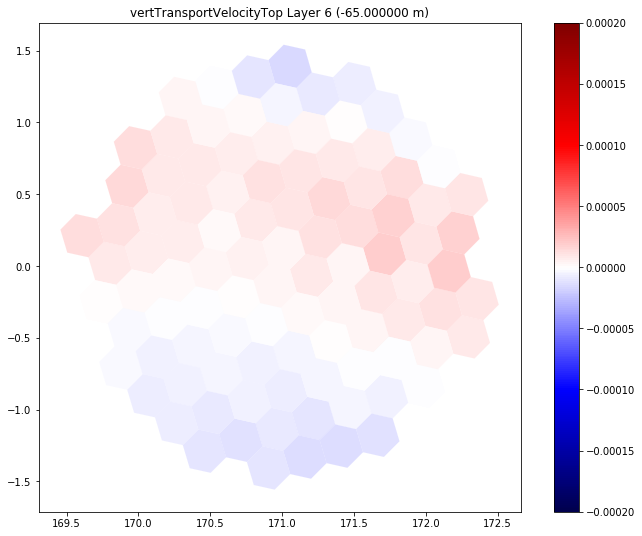

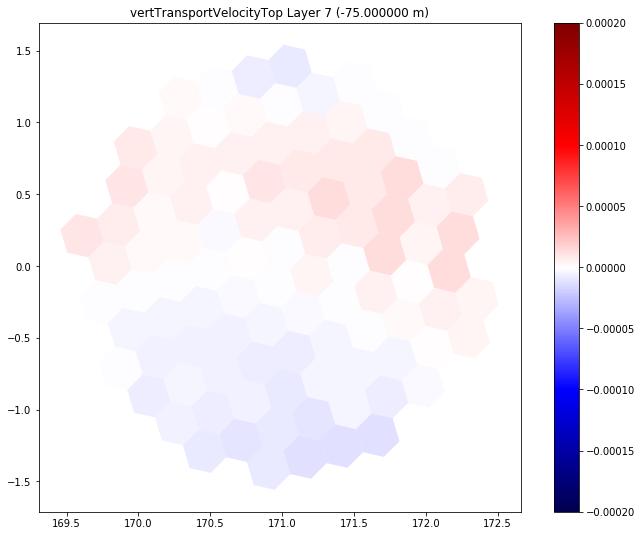

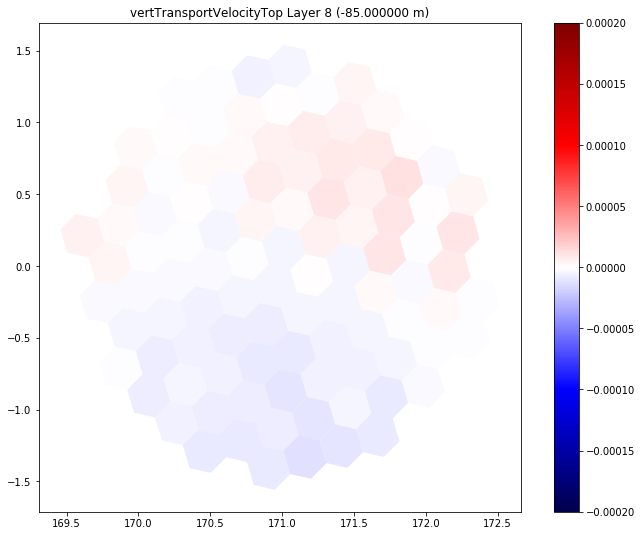

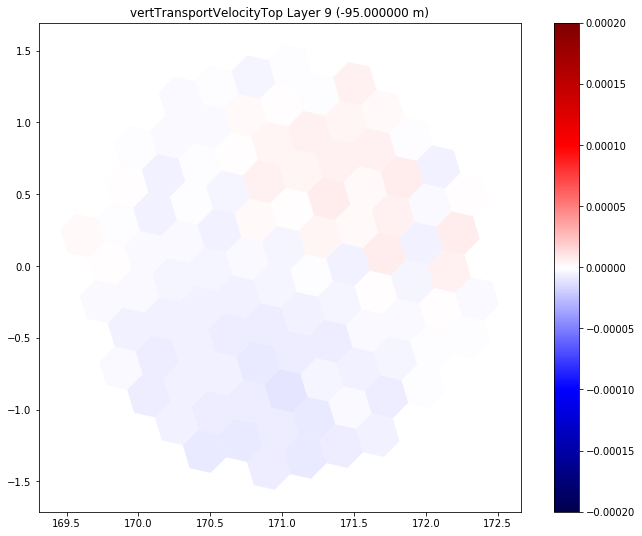

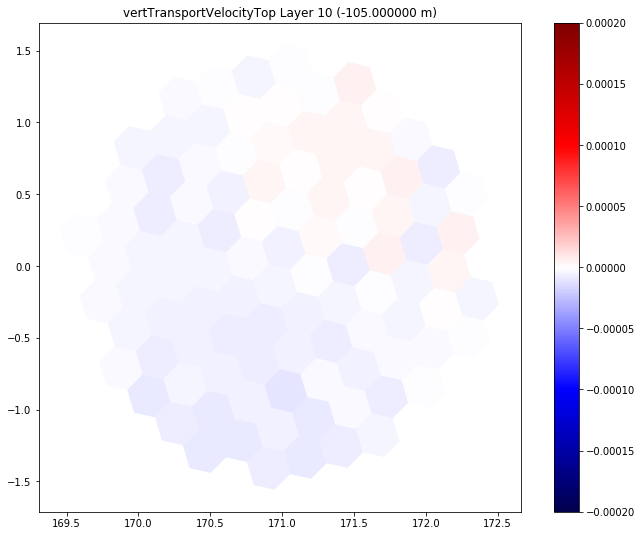

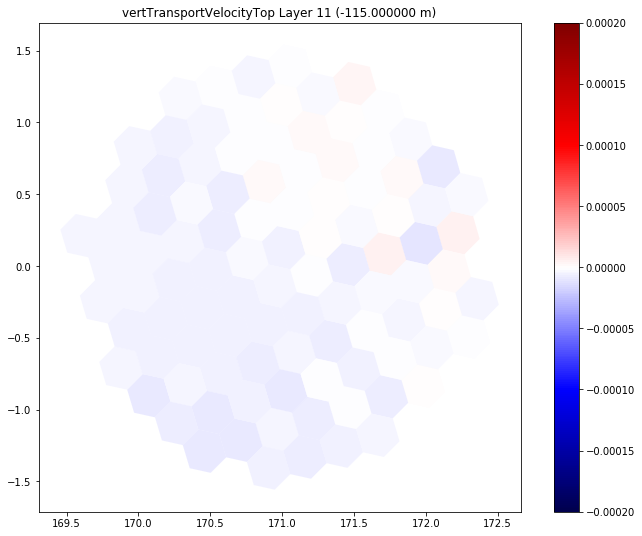

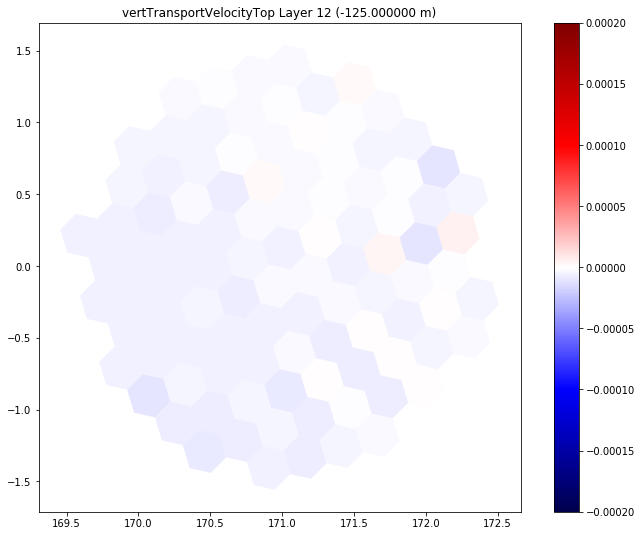

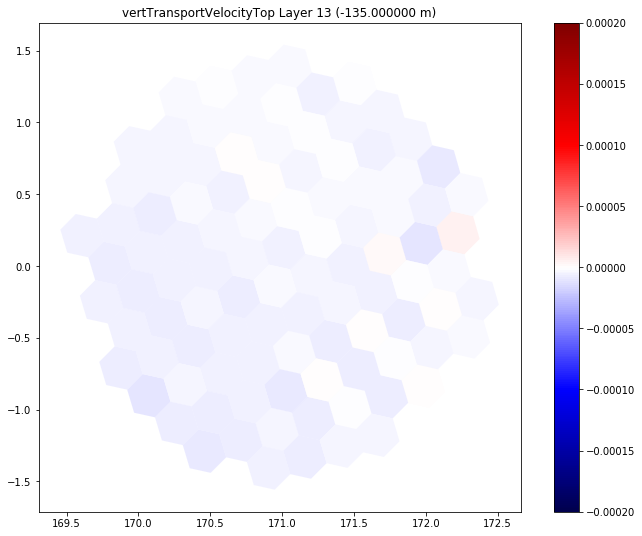

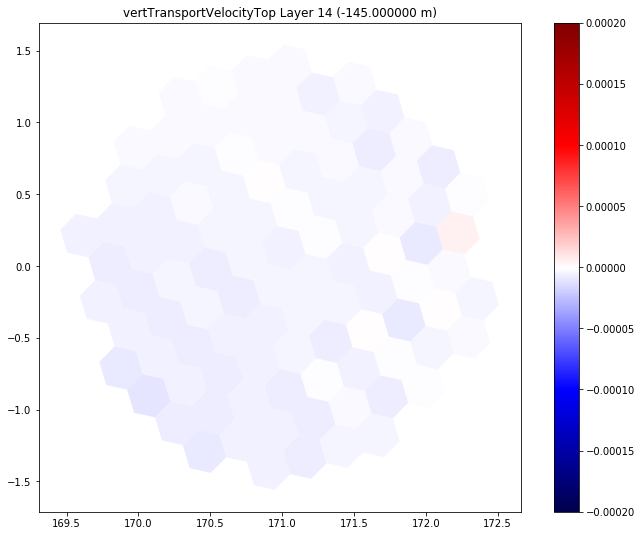

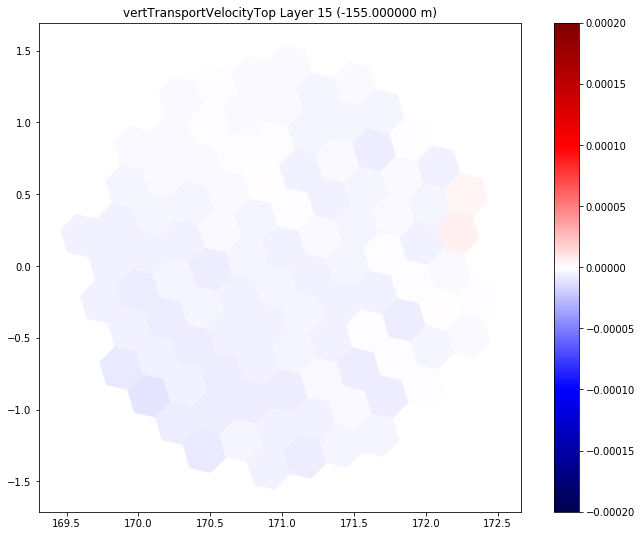

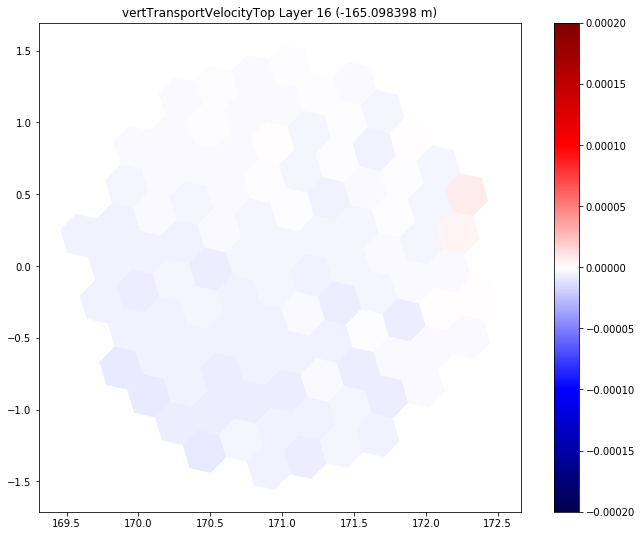

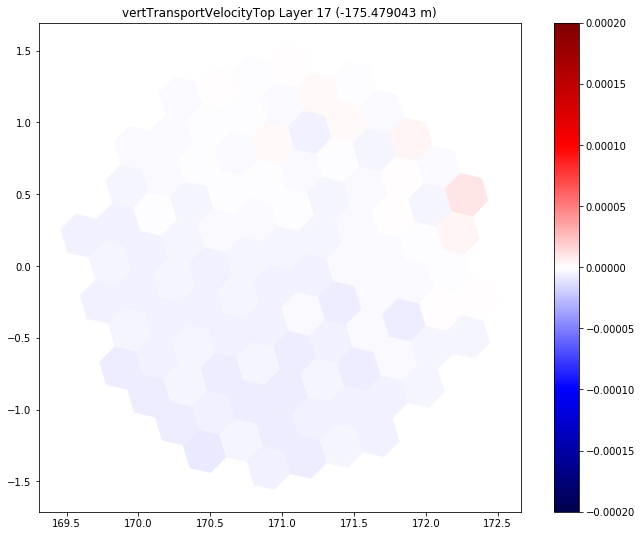

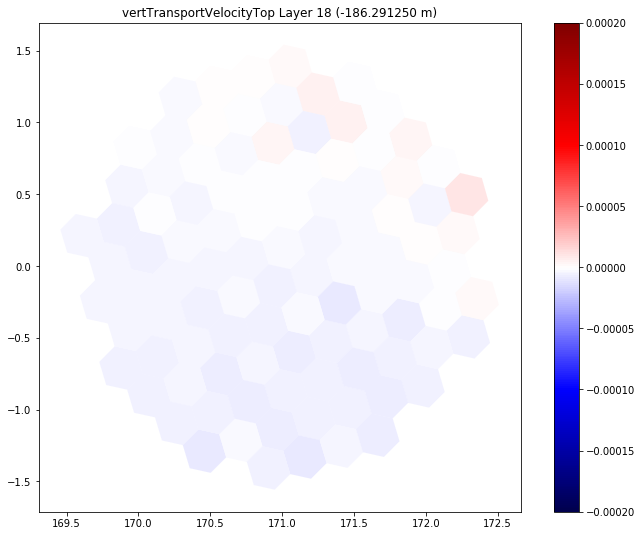

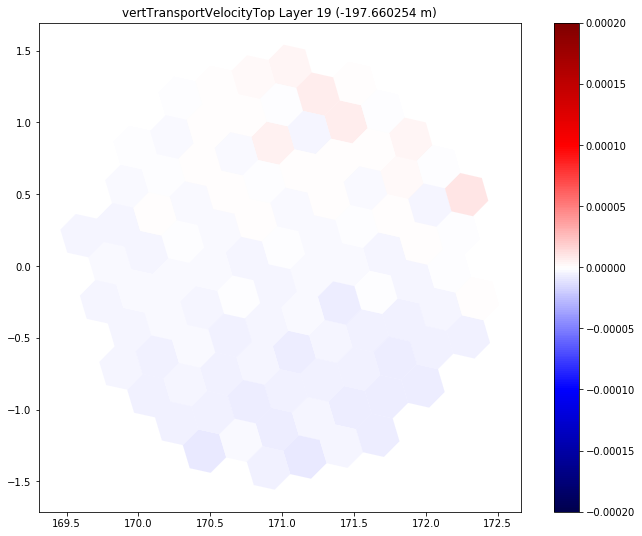

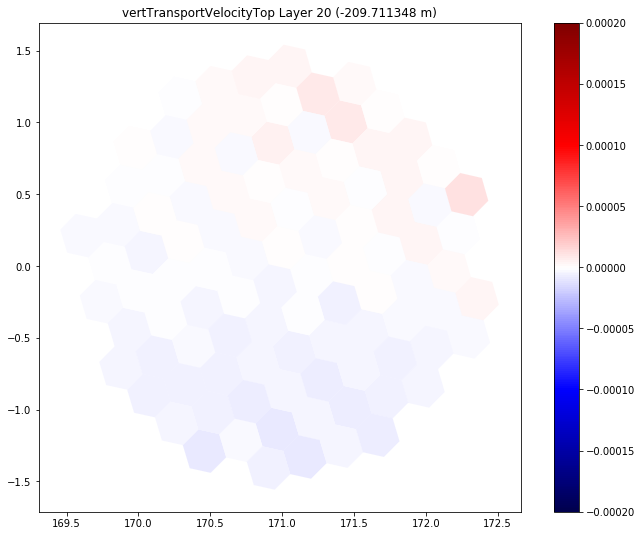

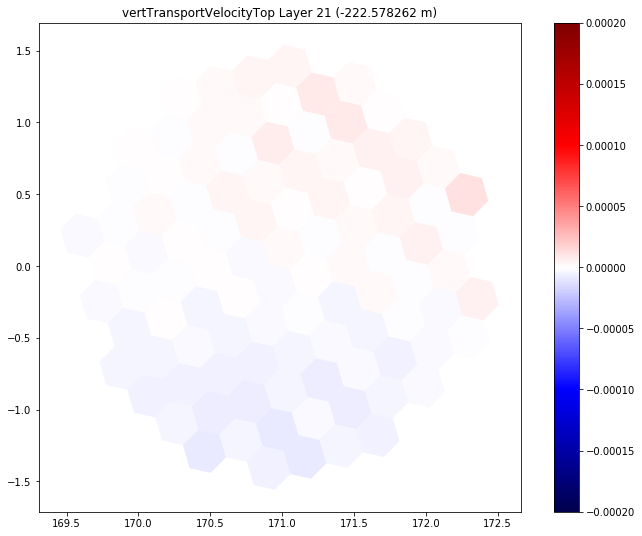

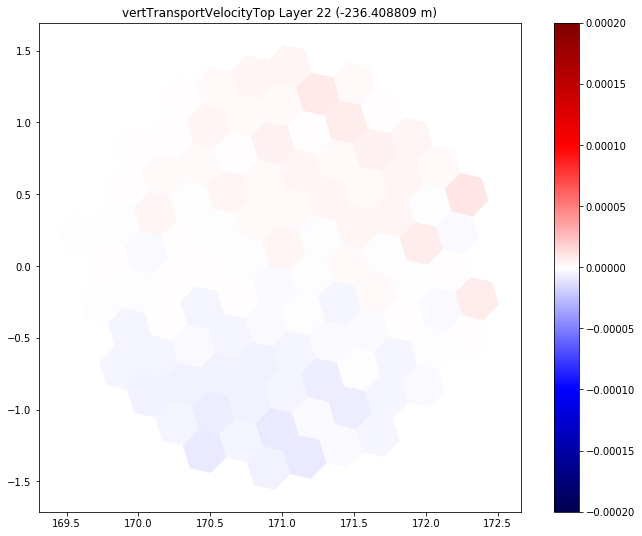

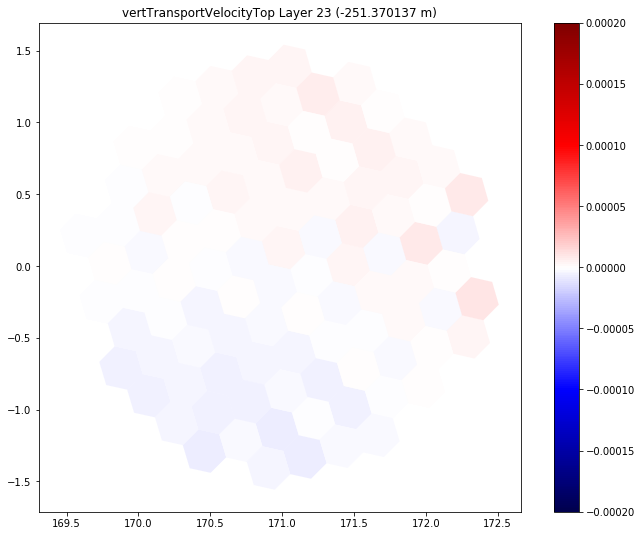

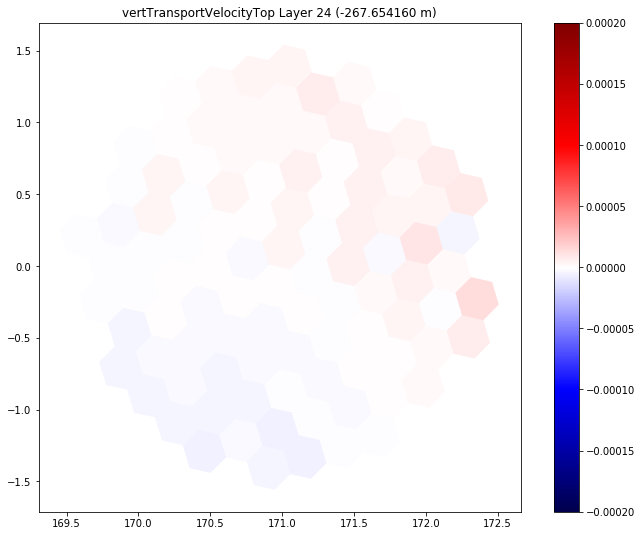

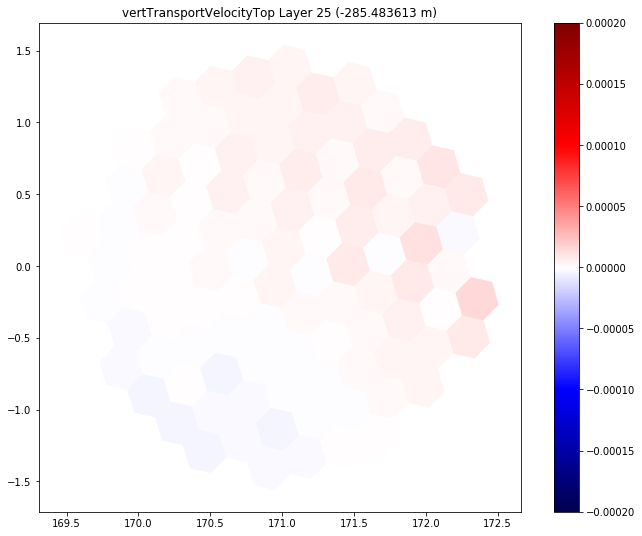

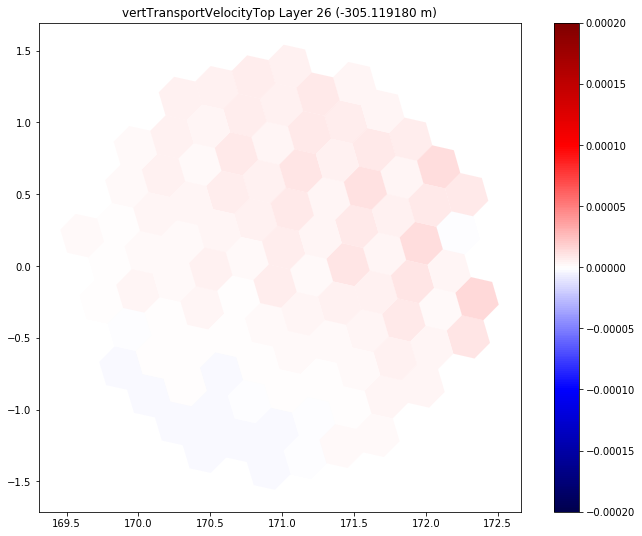

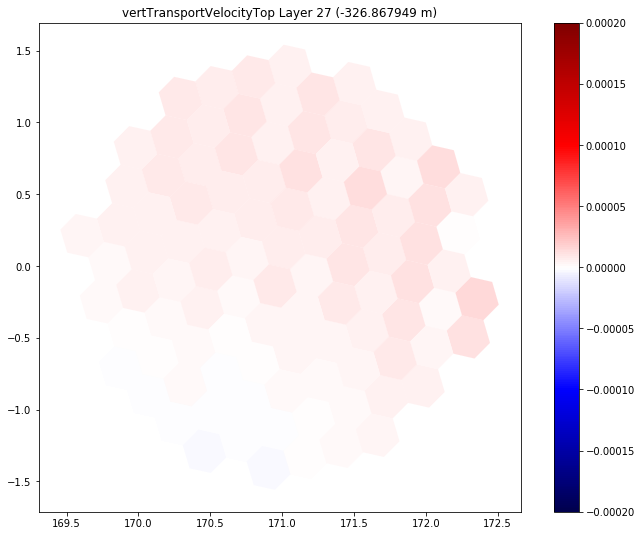

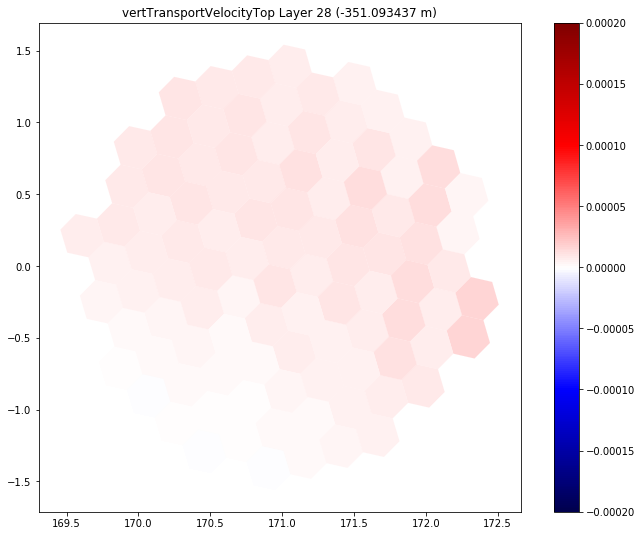

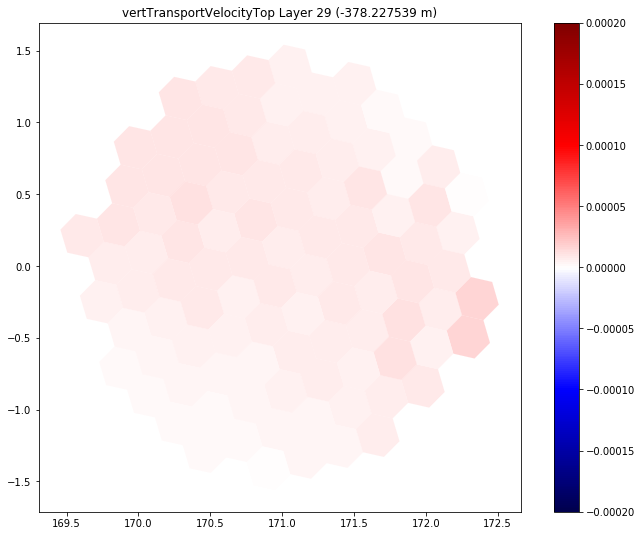

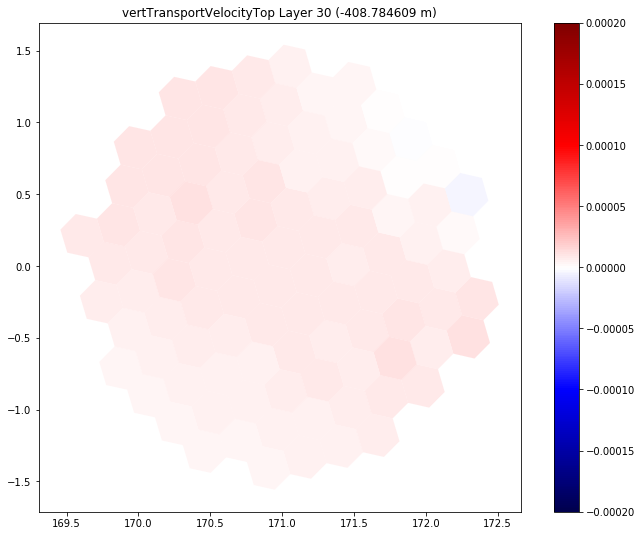

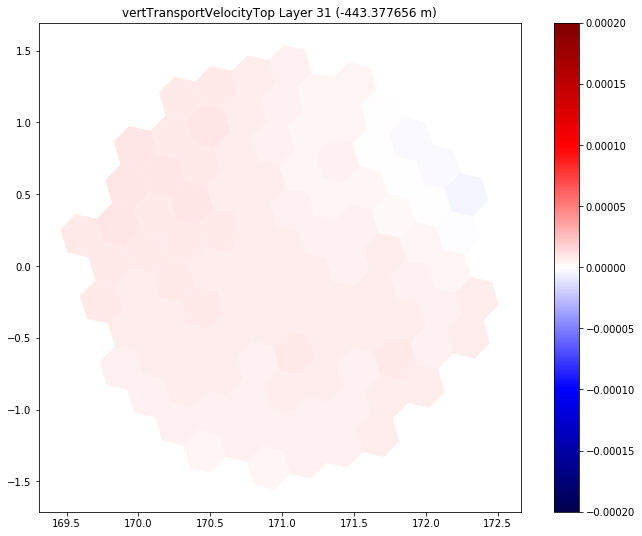

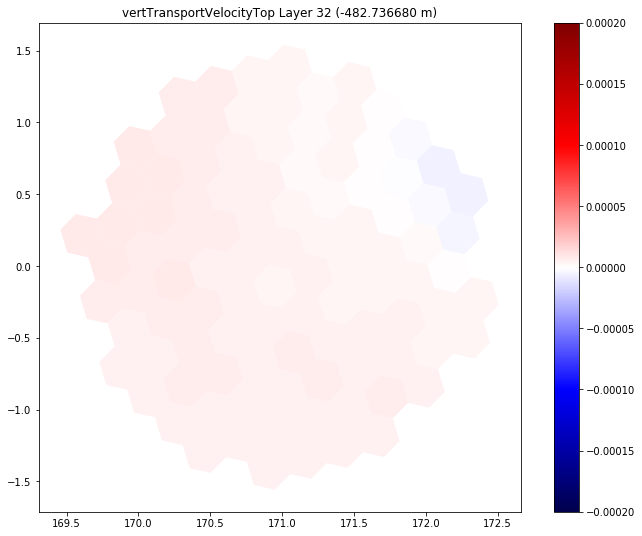

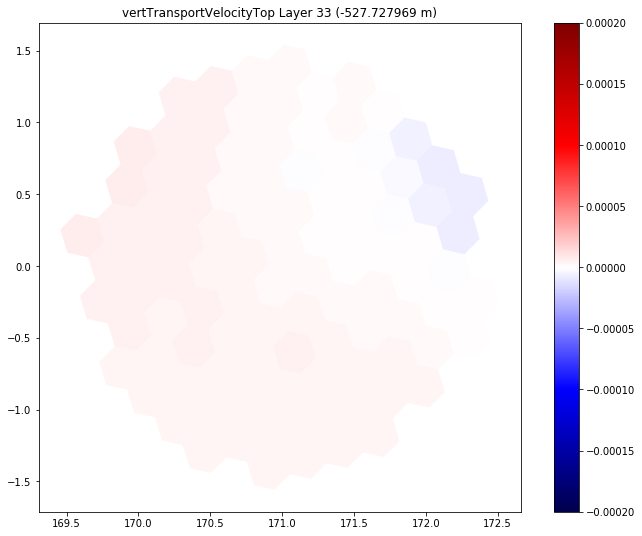

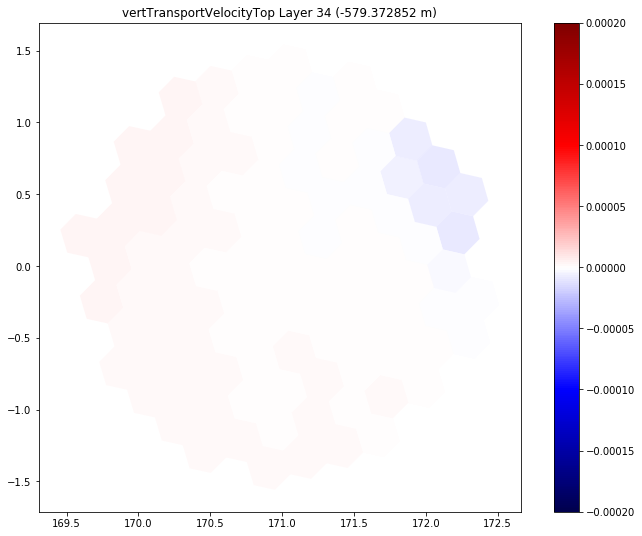

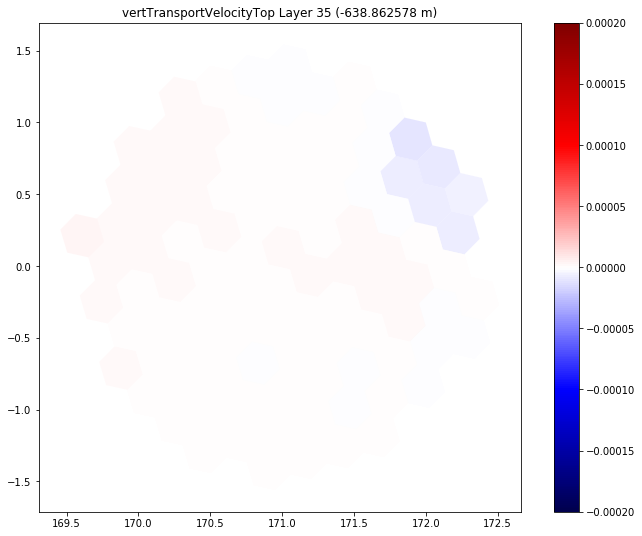

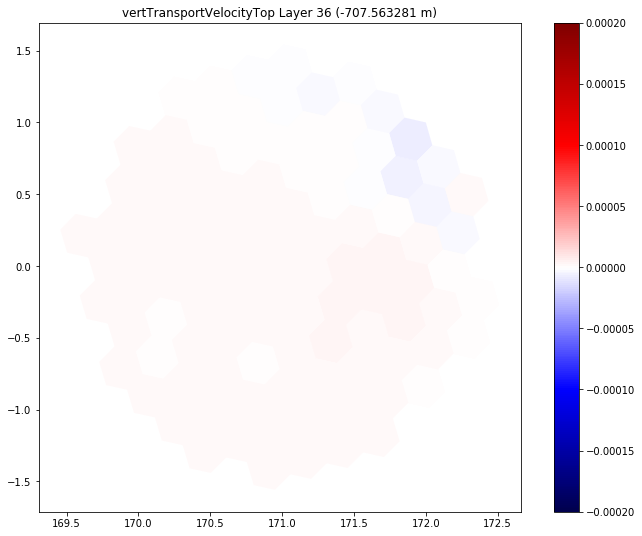

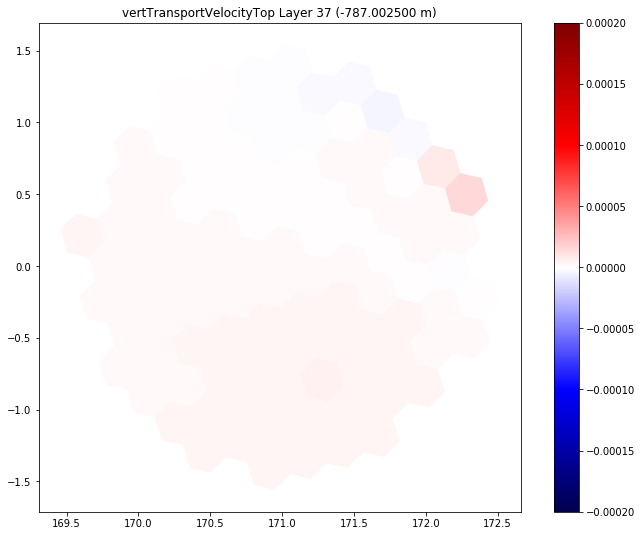

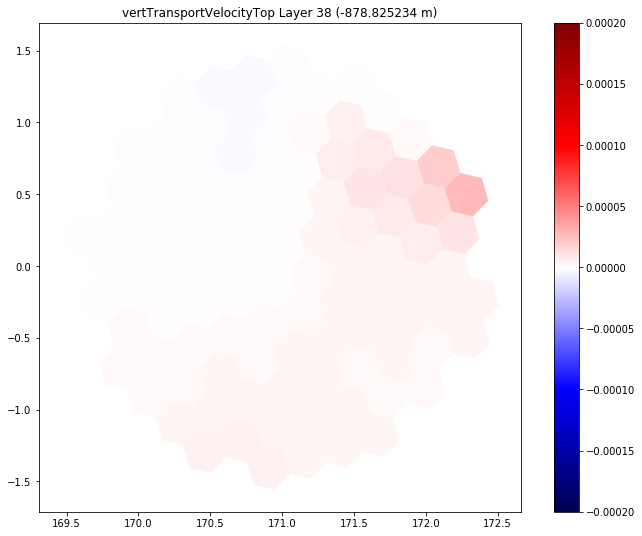

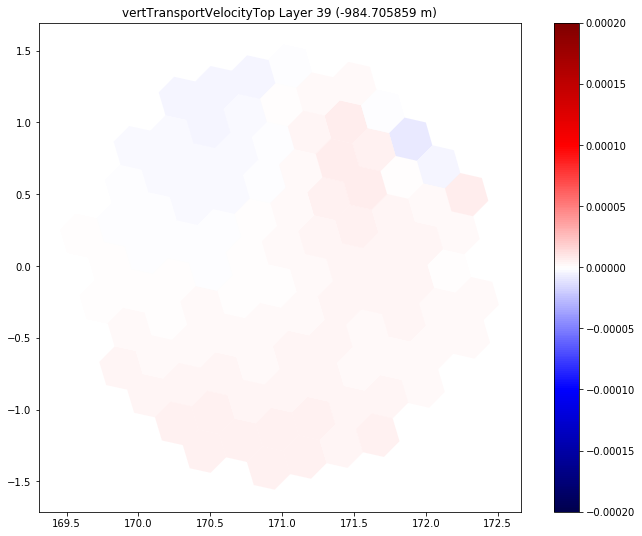

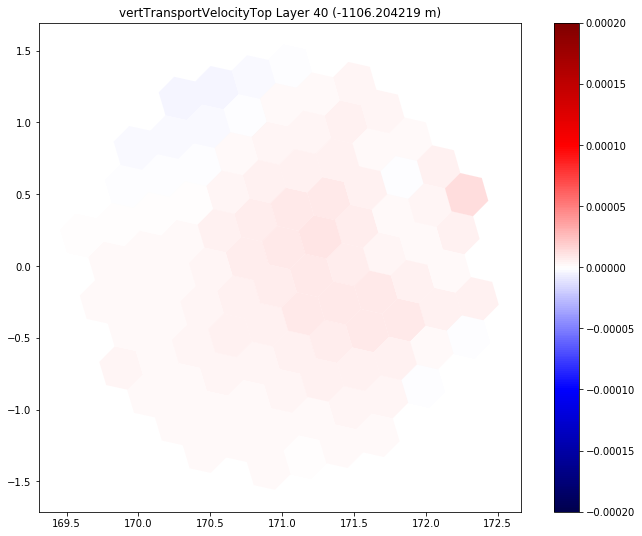

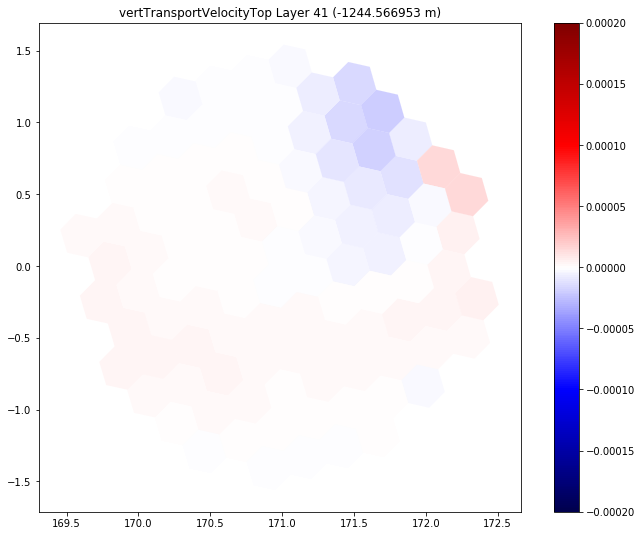

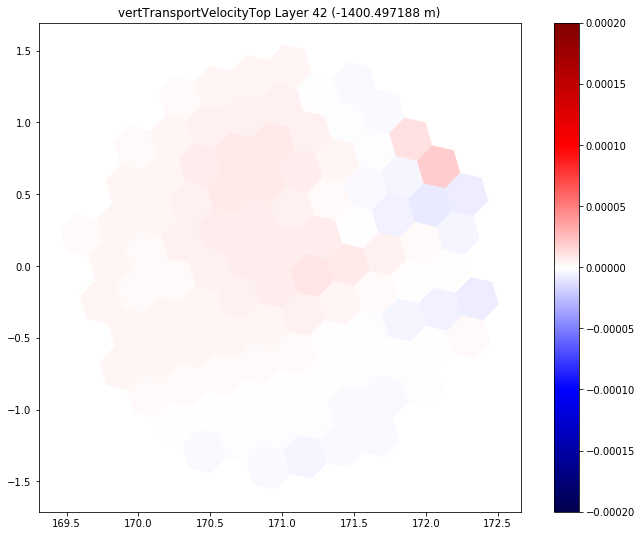

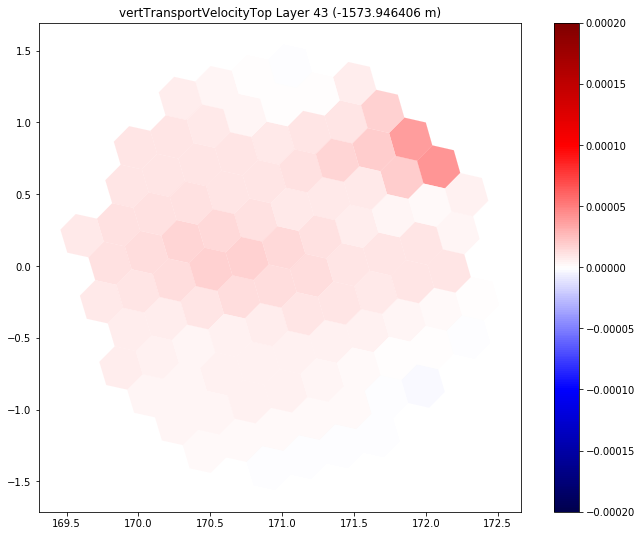

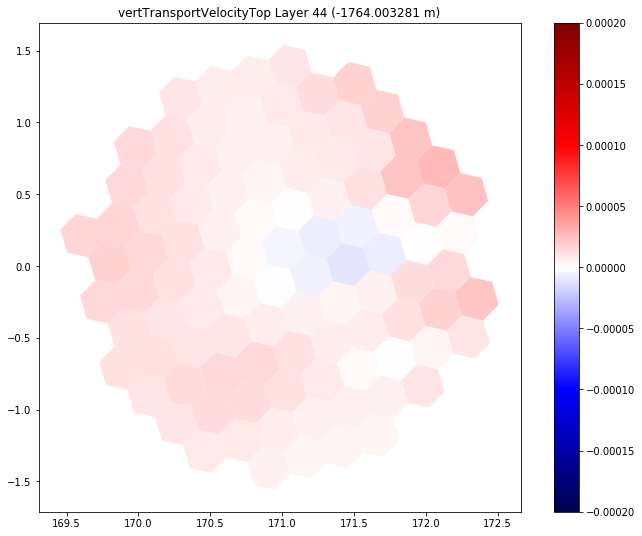

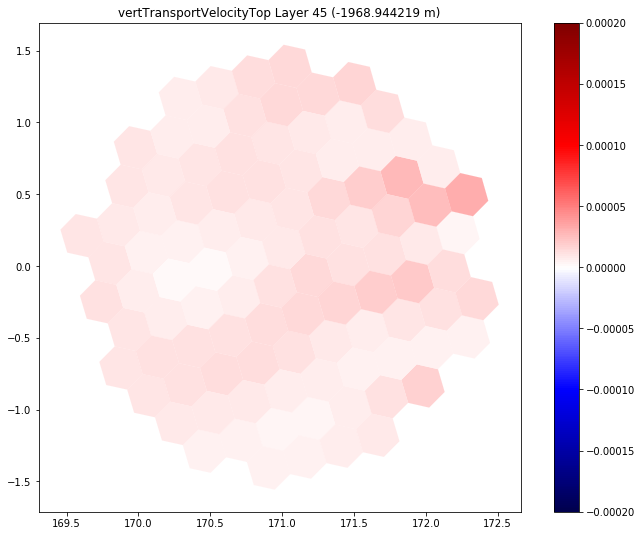

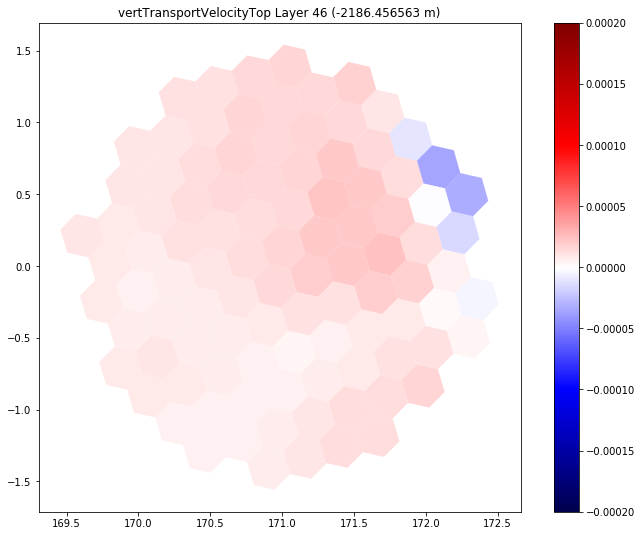

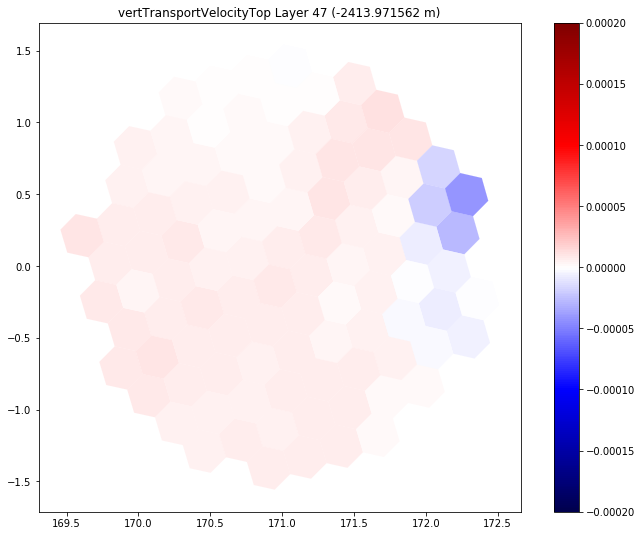

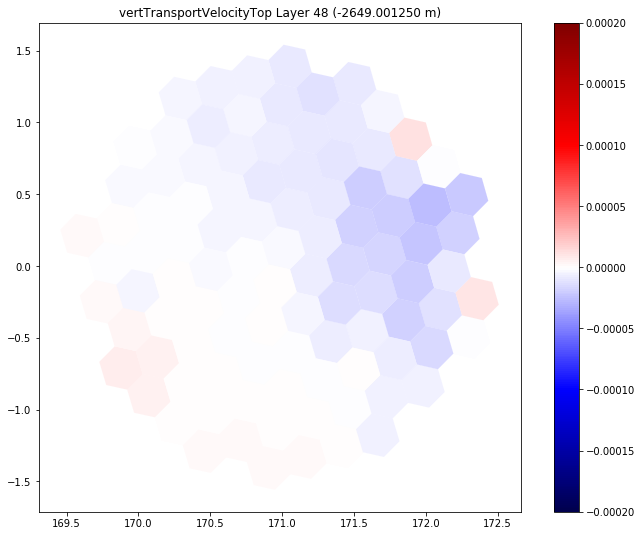

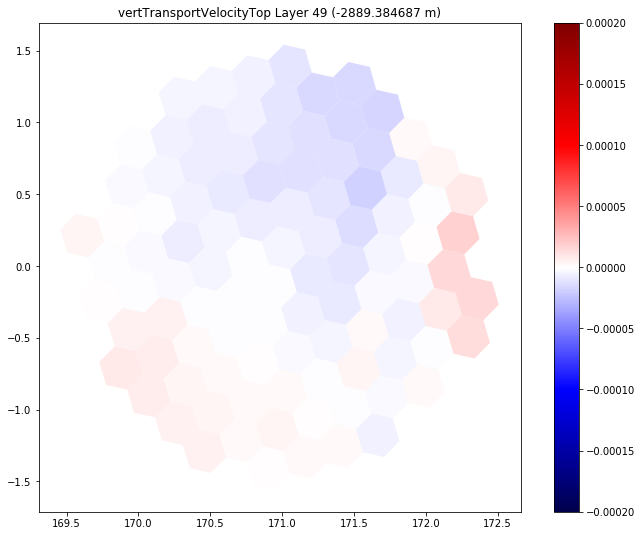

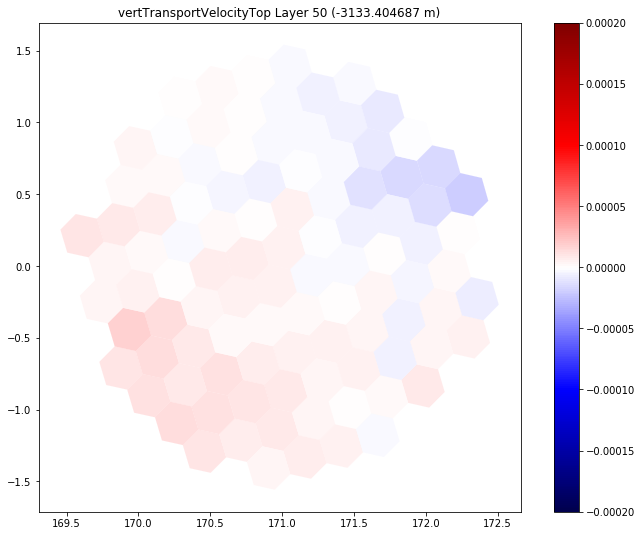

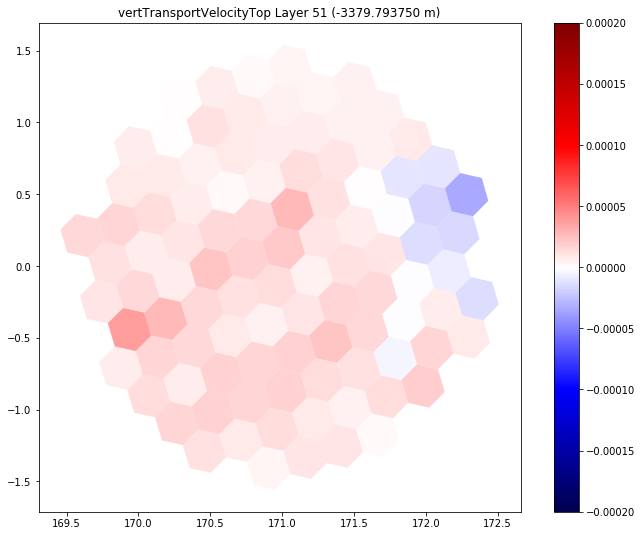

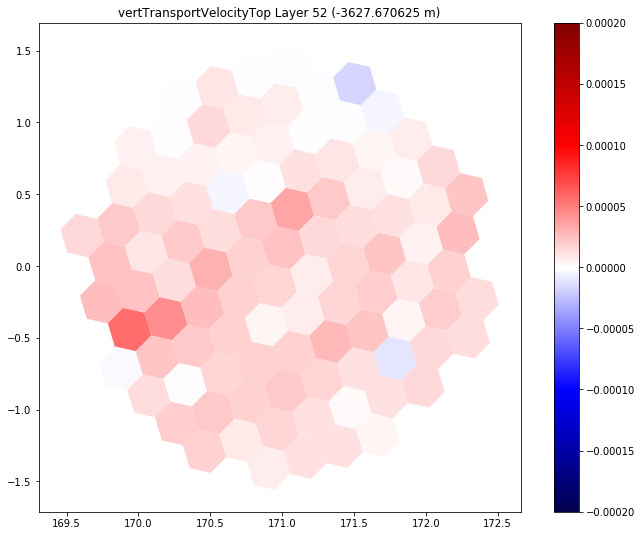

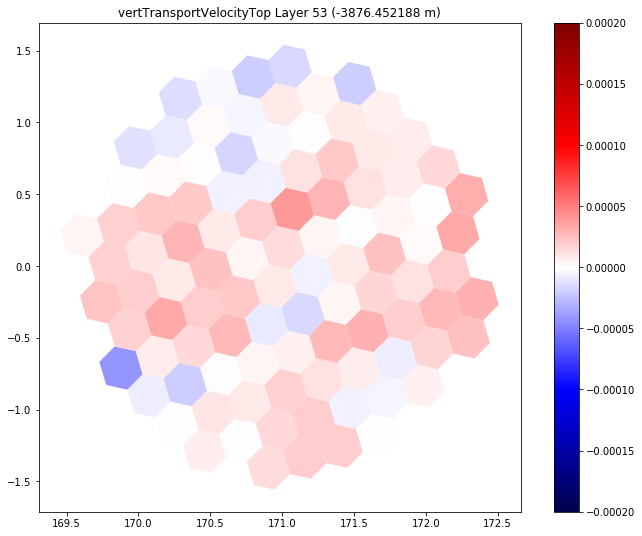

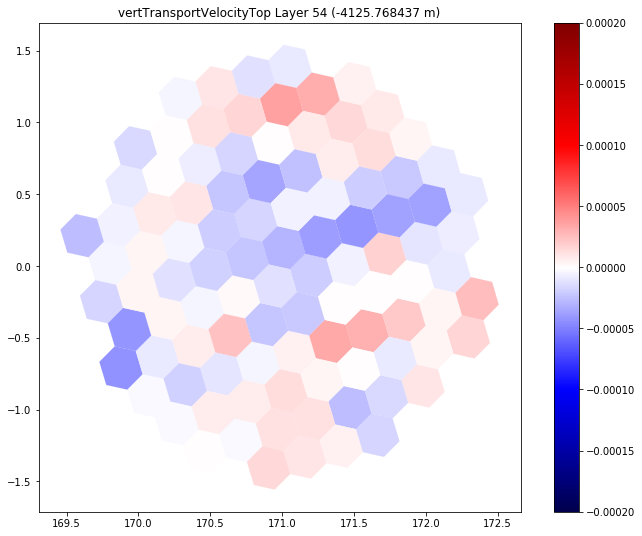

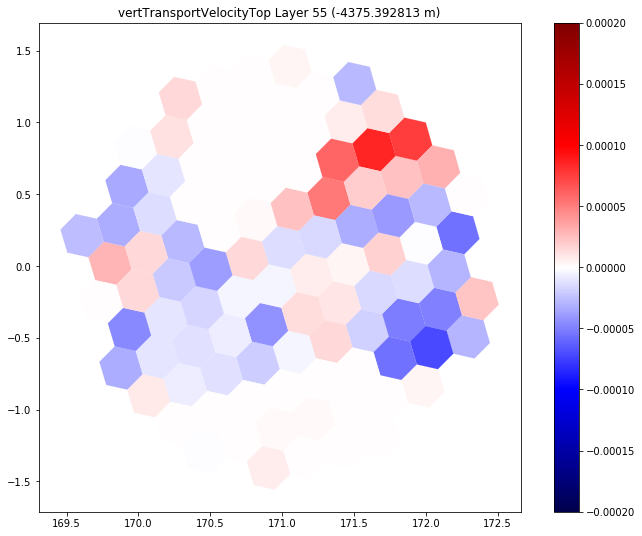

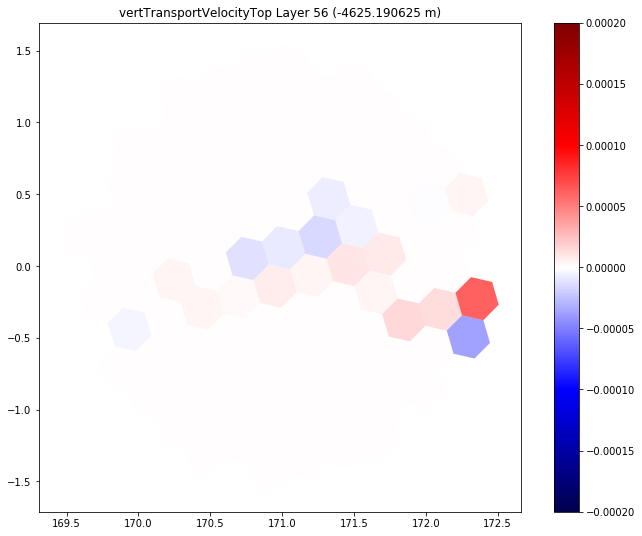

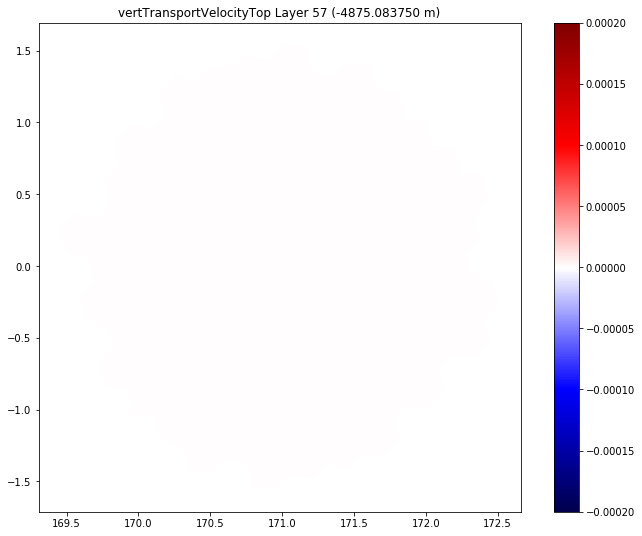

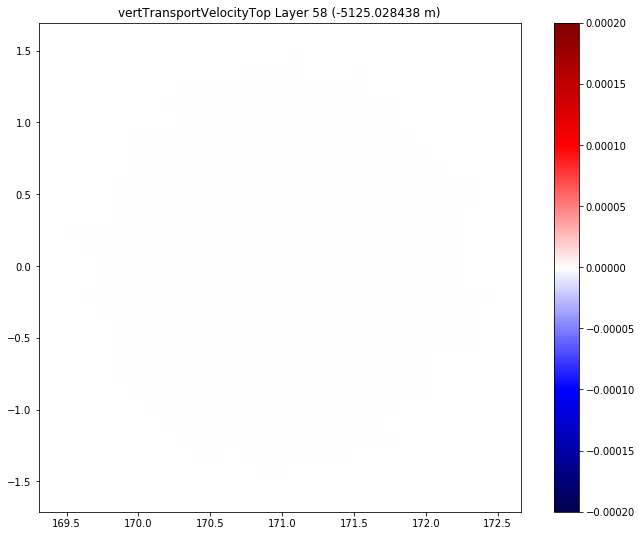

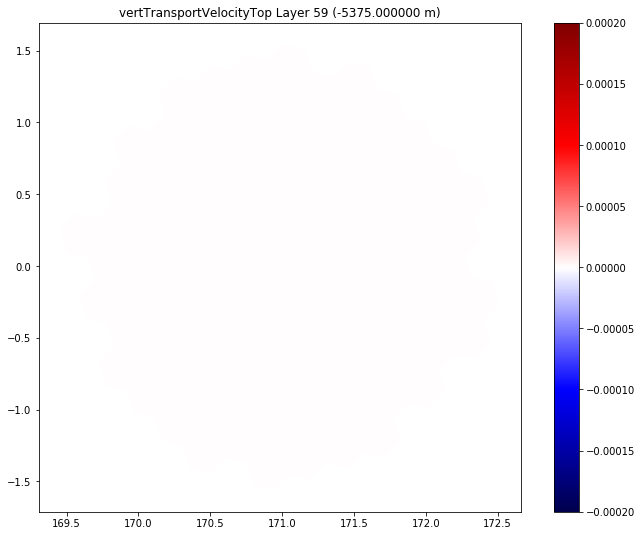

In [31]:
plot_profile(dspoints.vertTransportVelocityTop, atime=iTime, dc=2e-4)

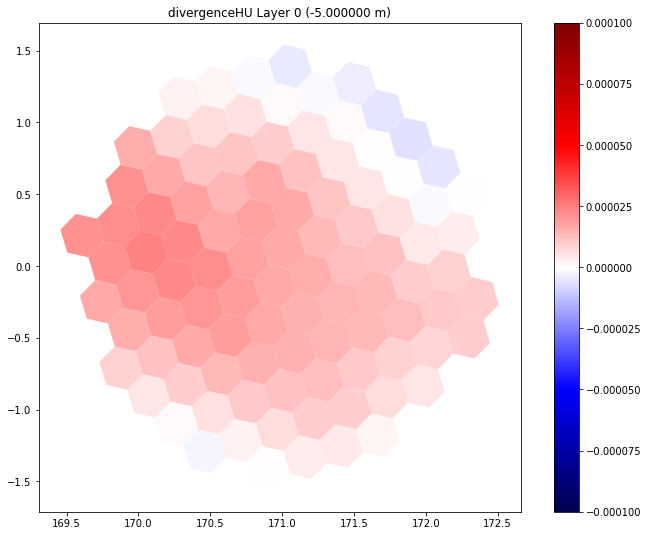

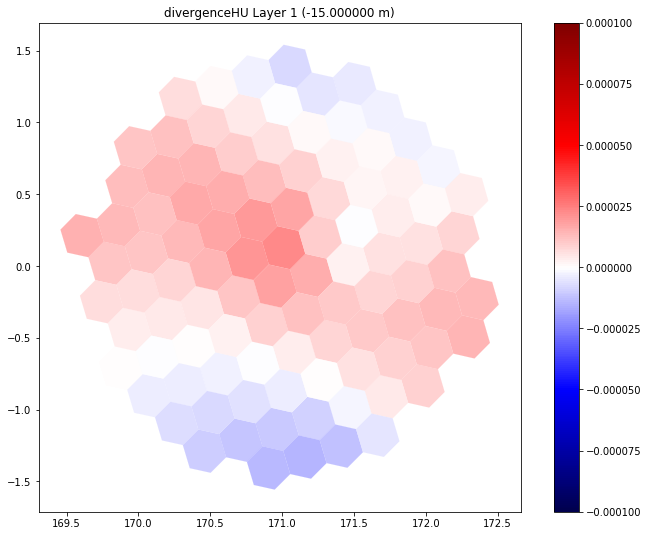

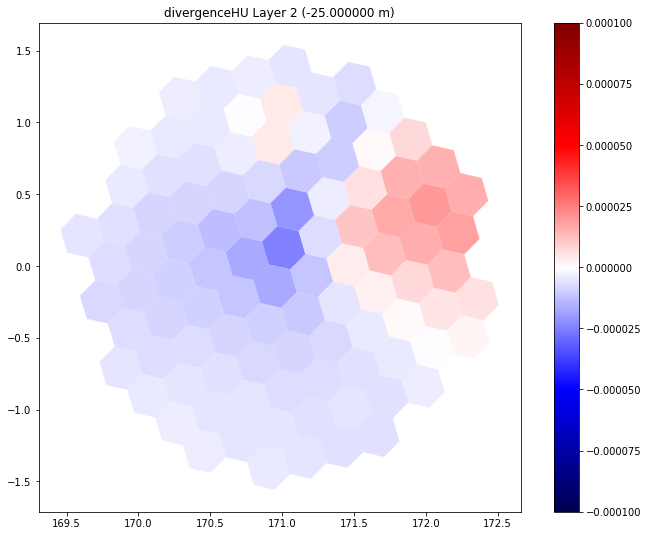

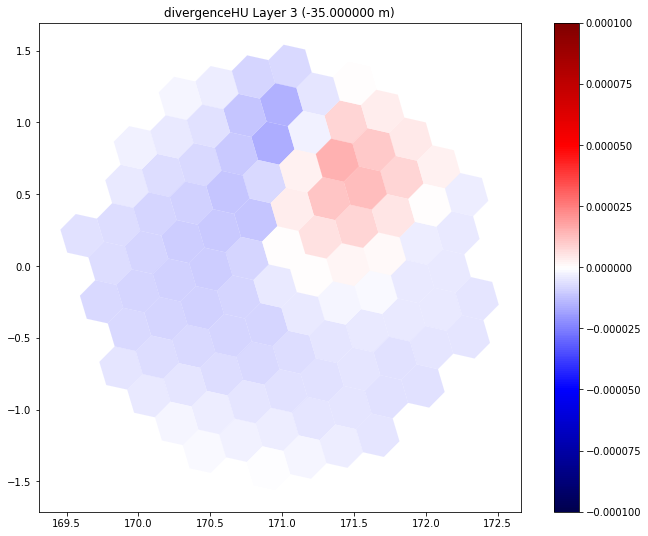

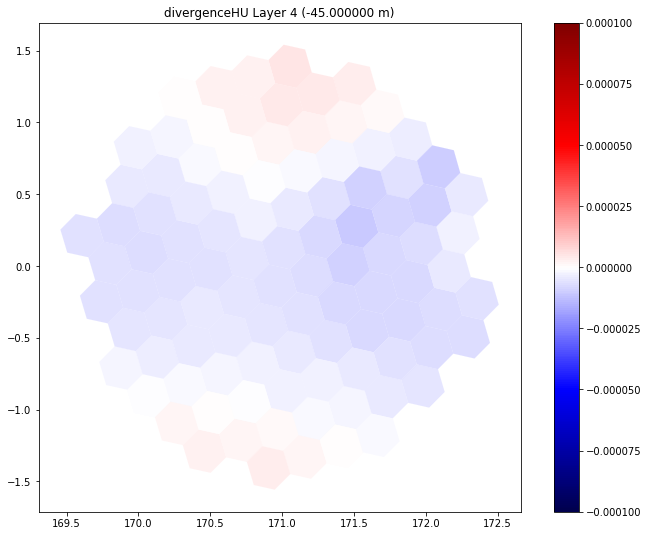

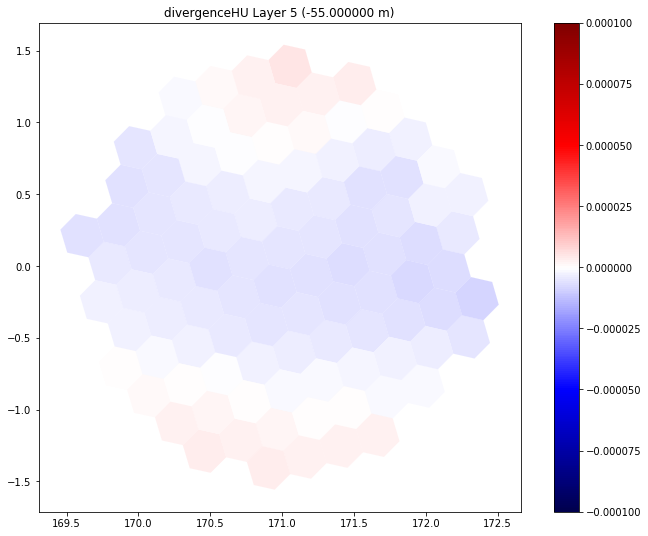

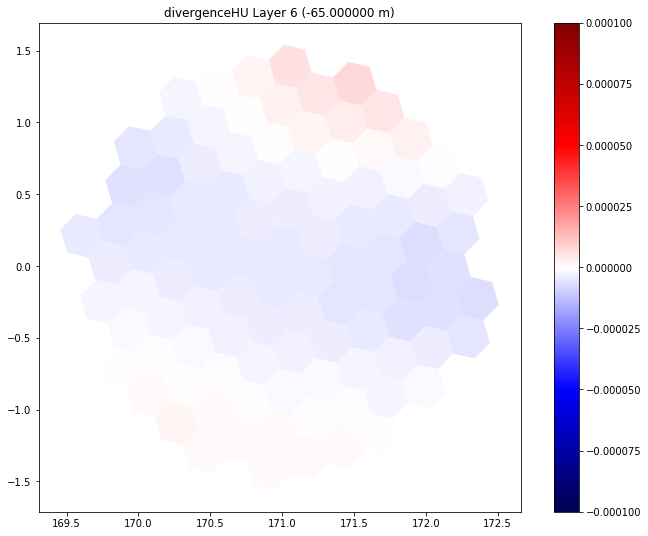

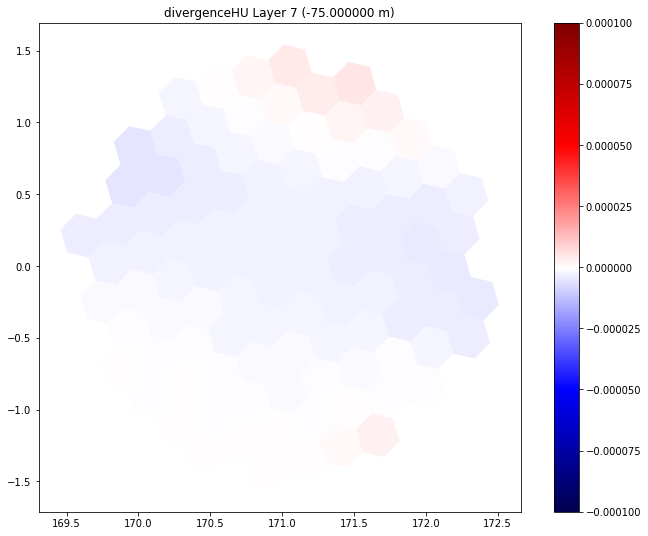

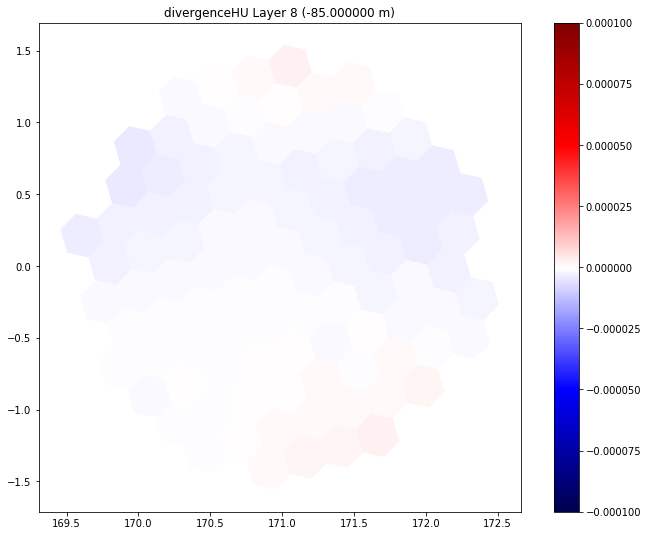

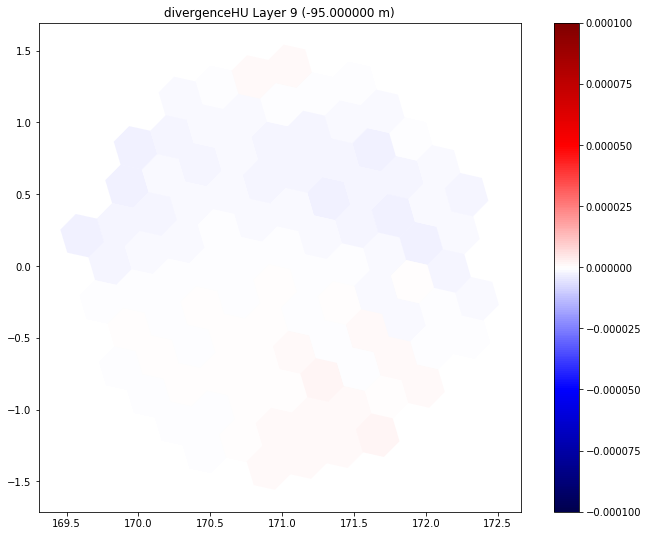

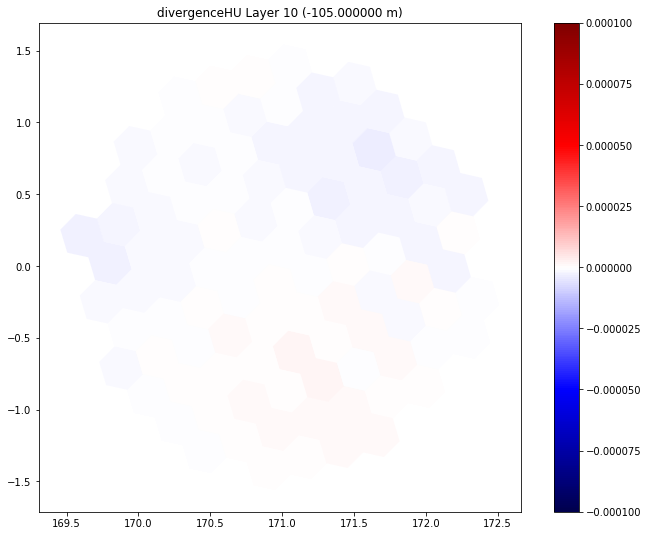

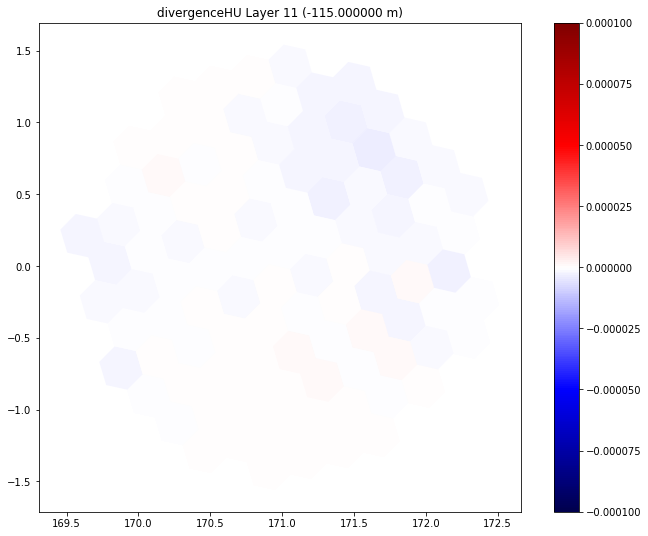

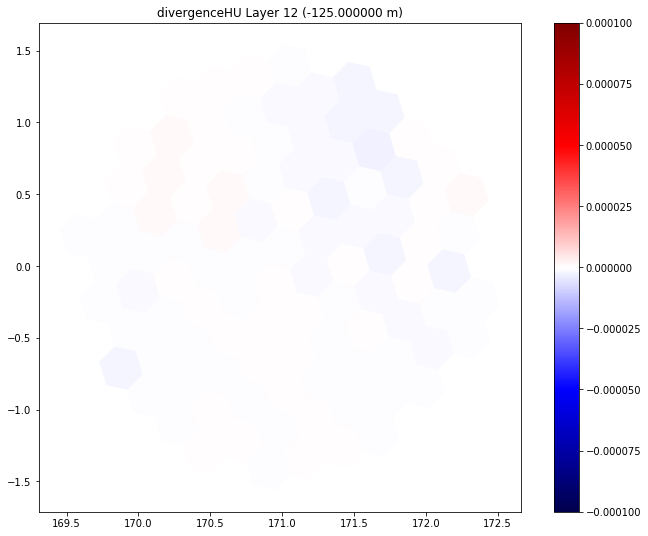

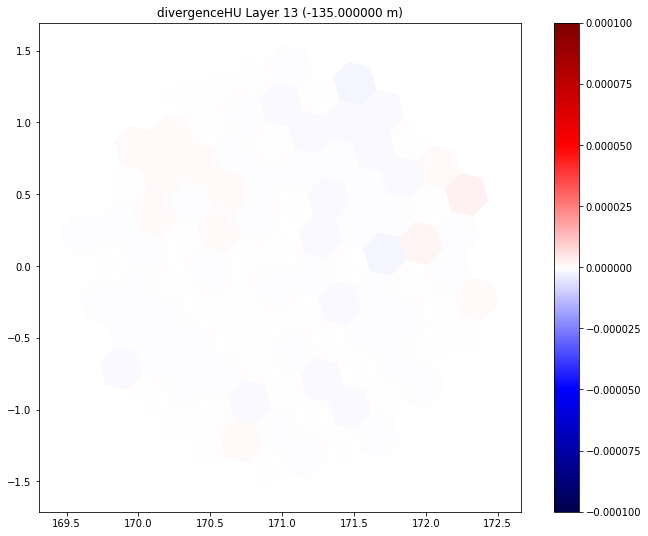

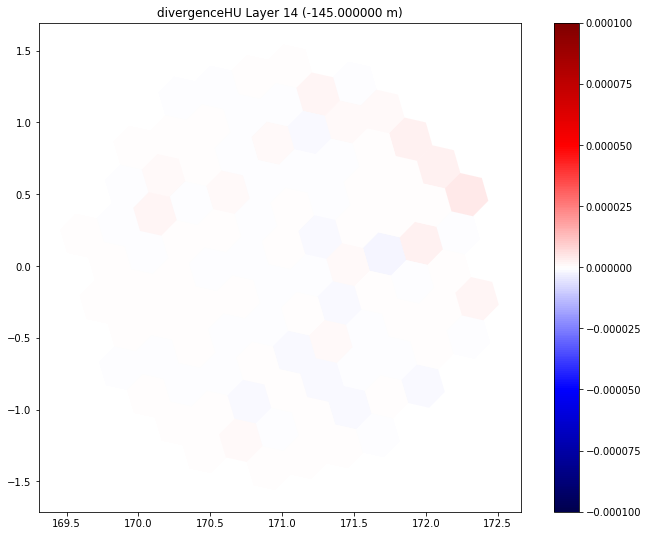

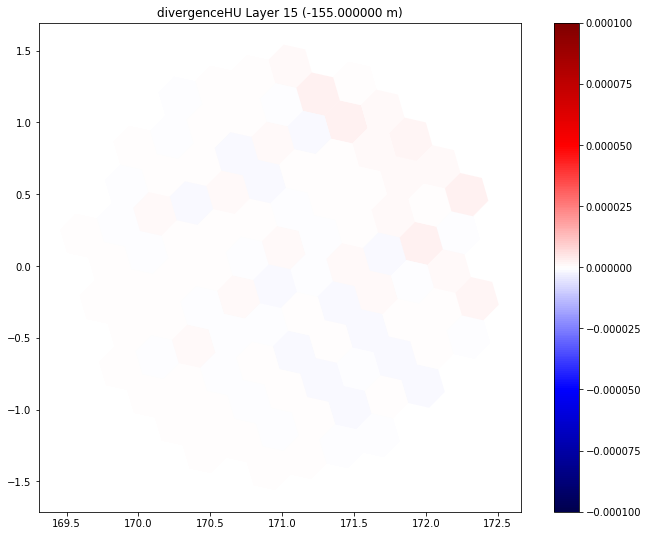

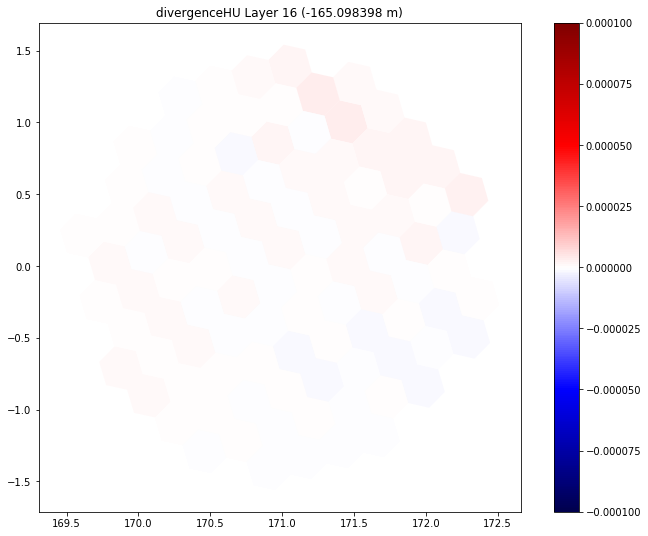

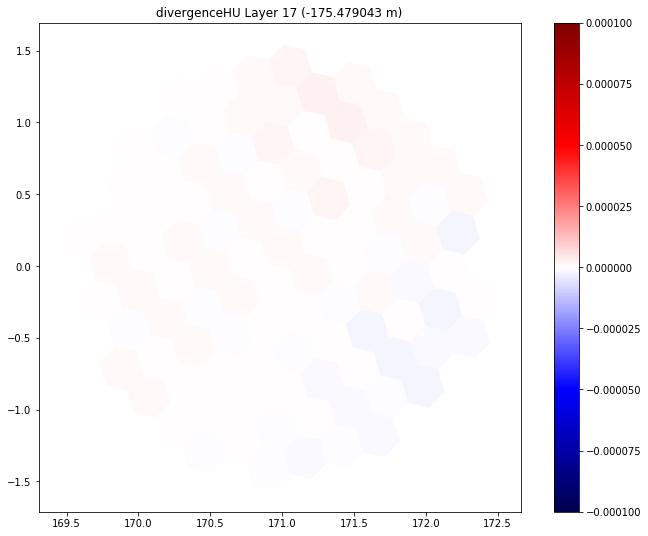

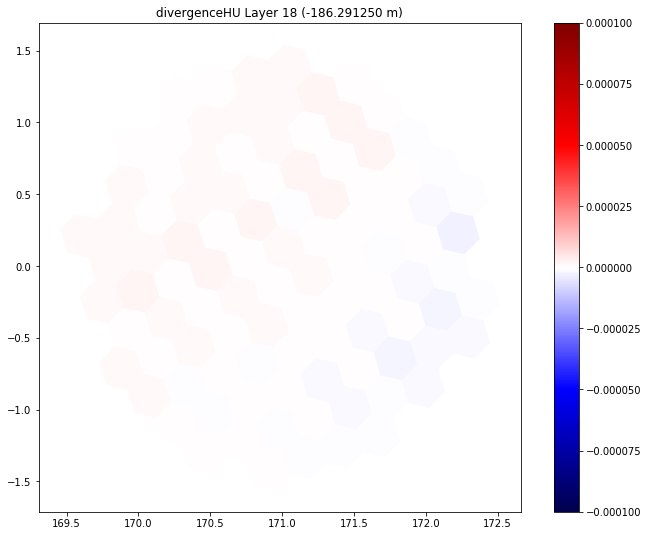

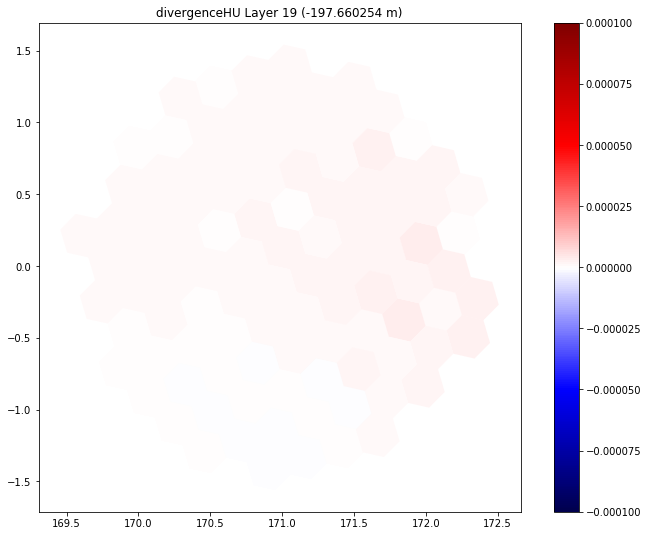

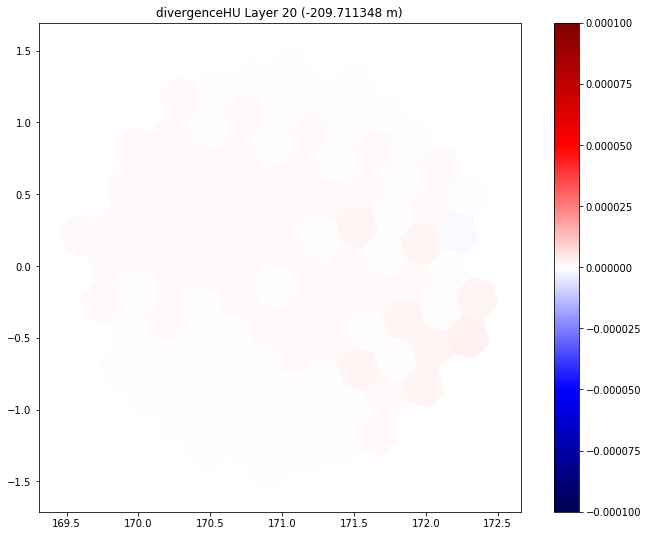

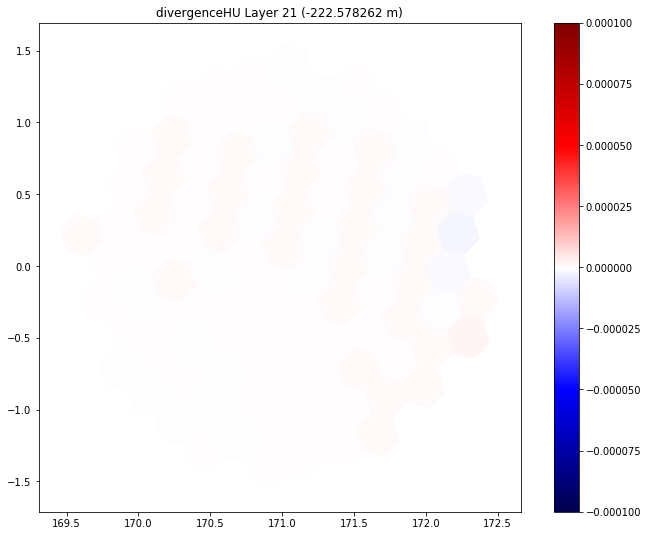

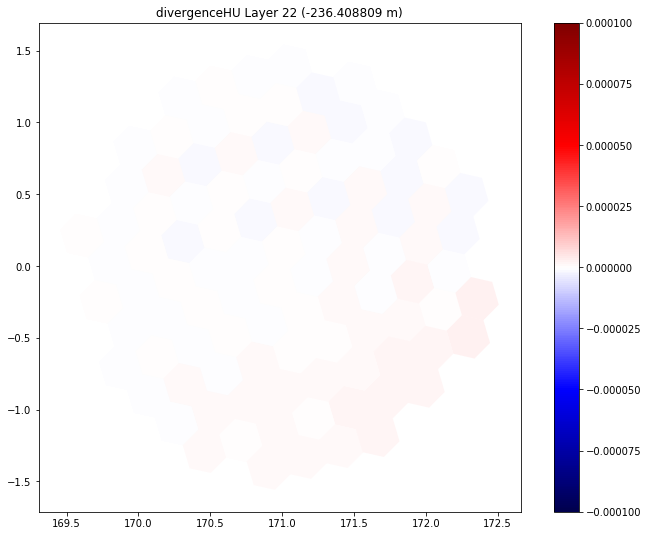

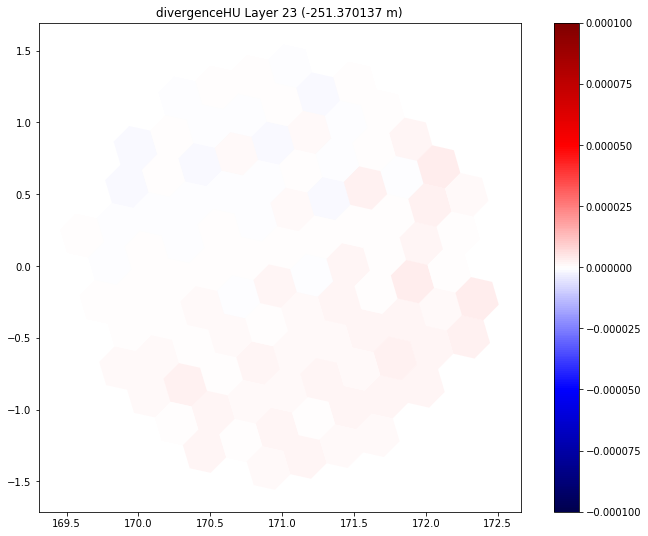

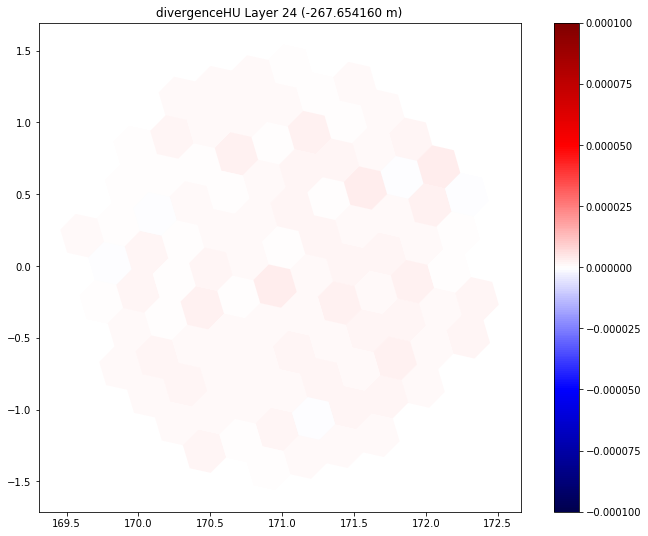

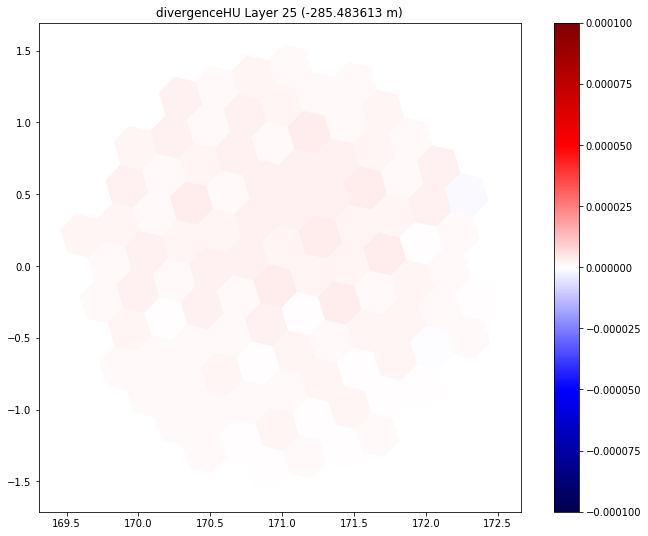

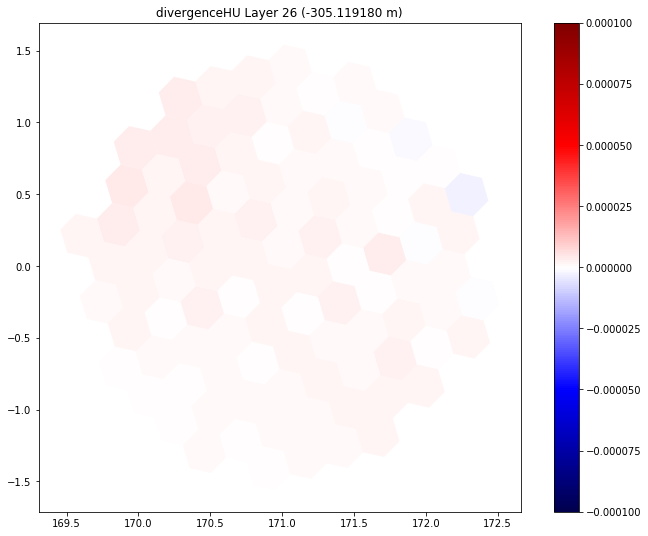

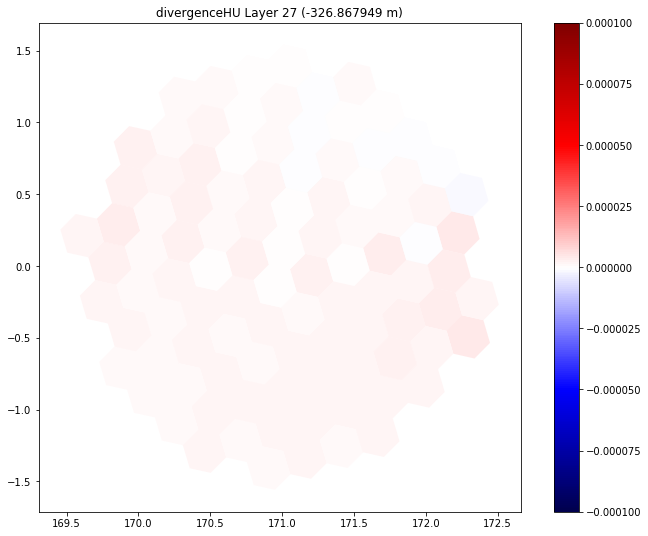

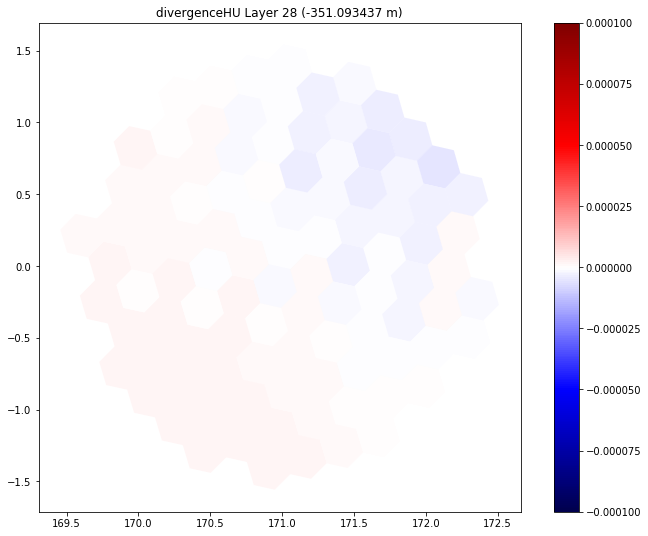

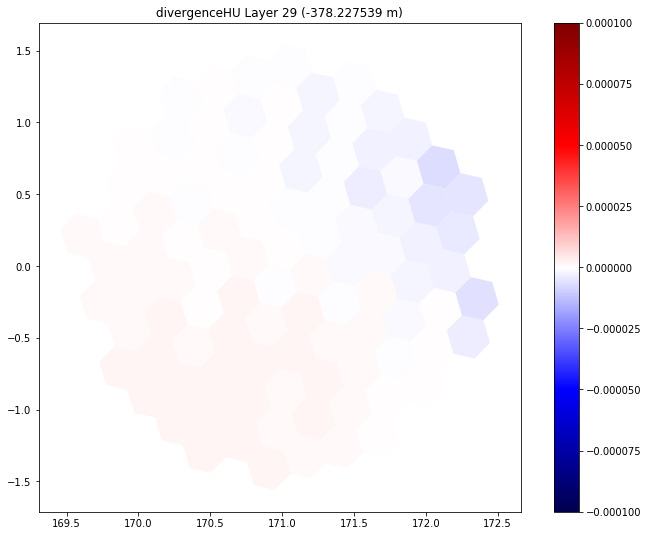

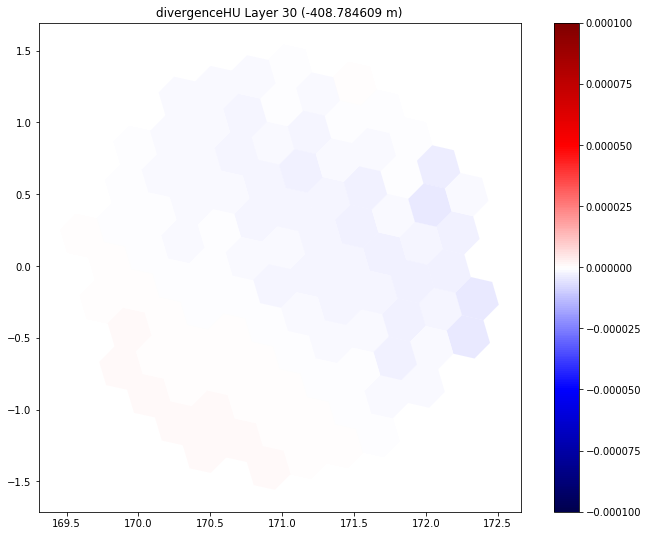

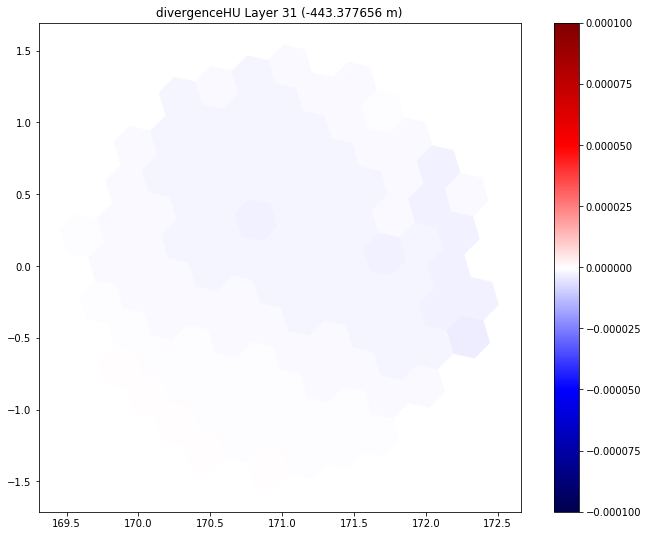

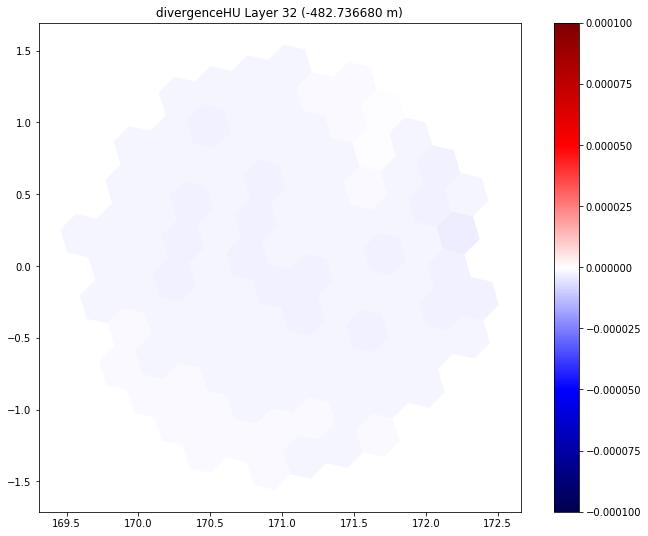

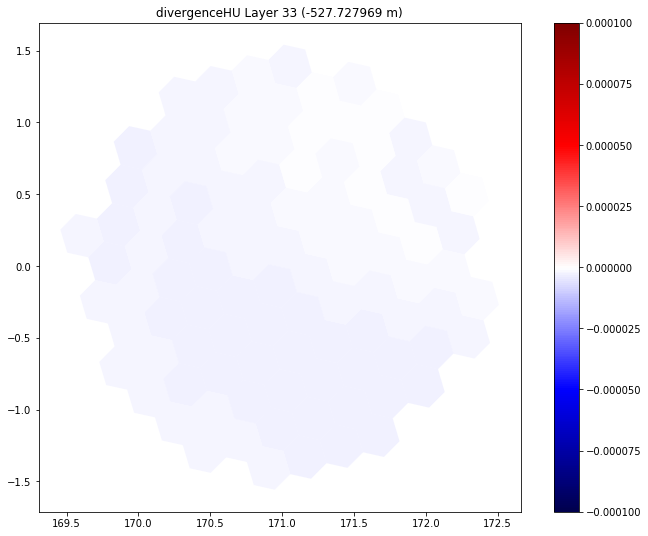

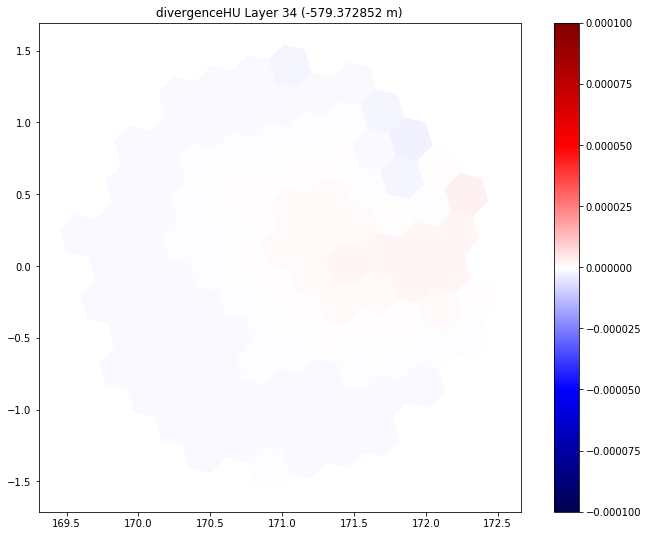

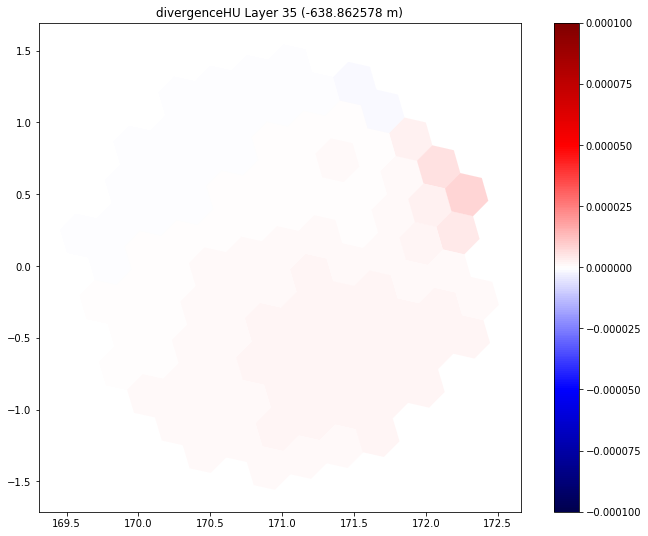

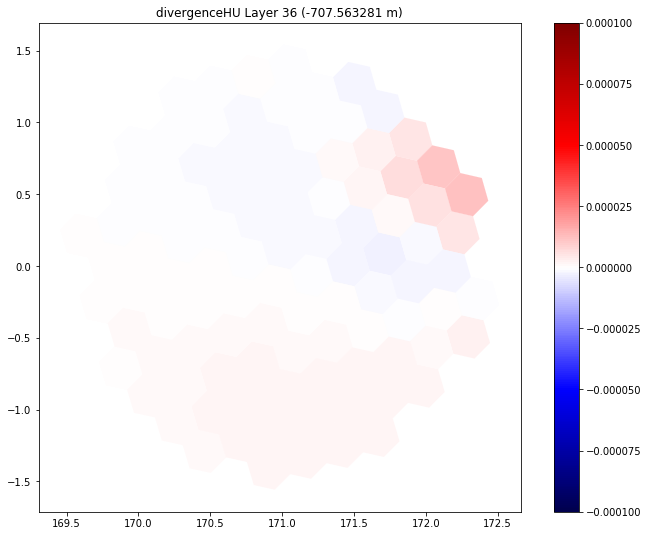

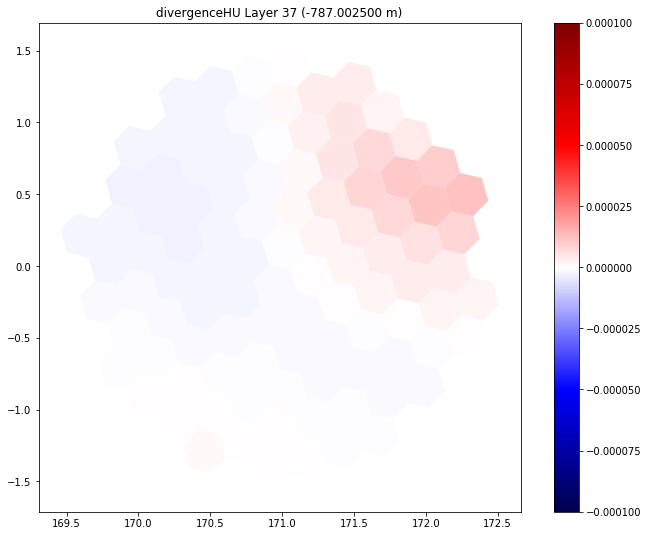

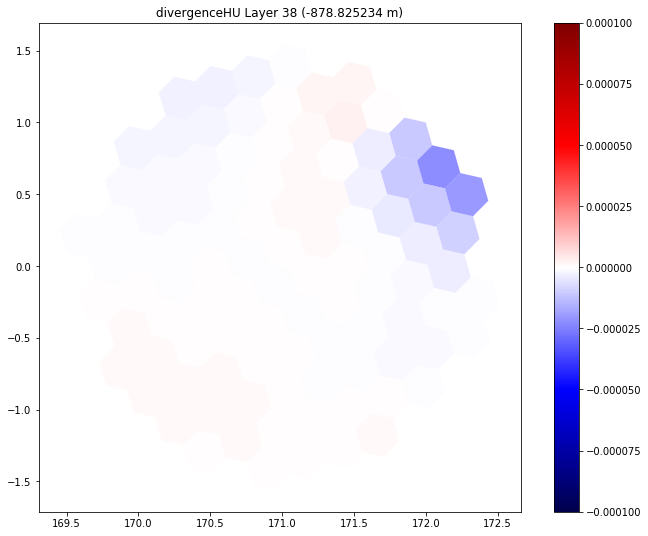

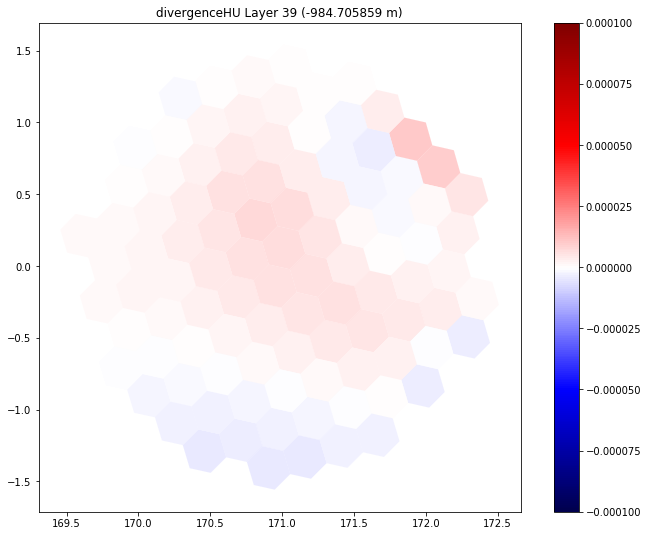

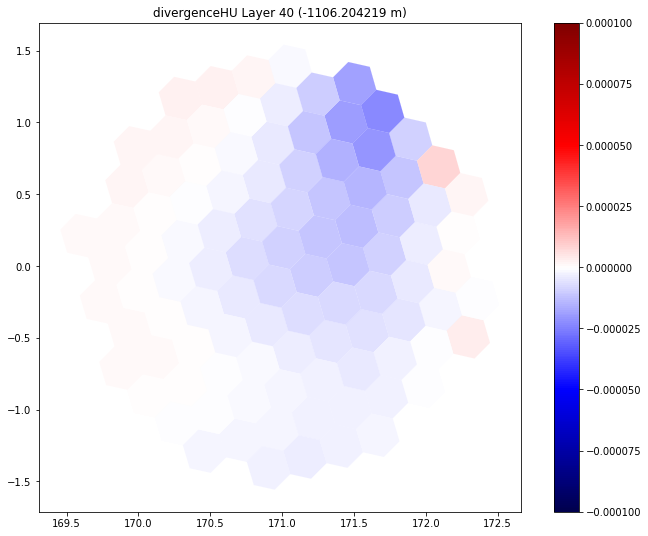

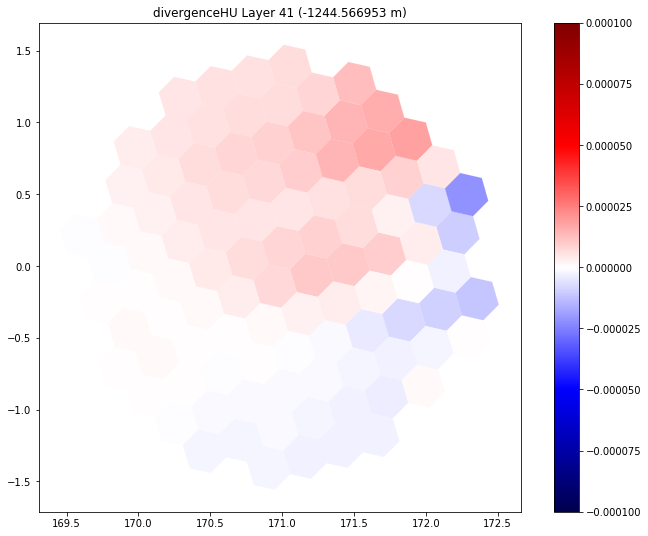

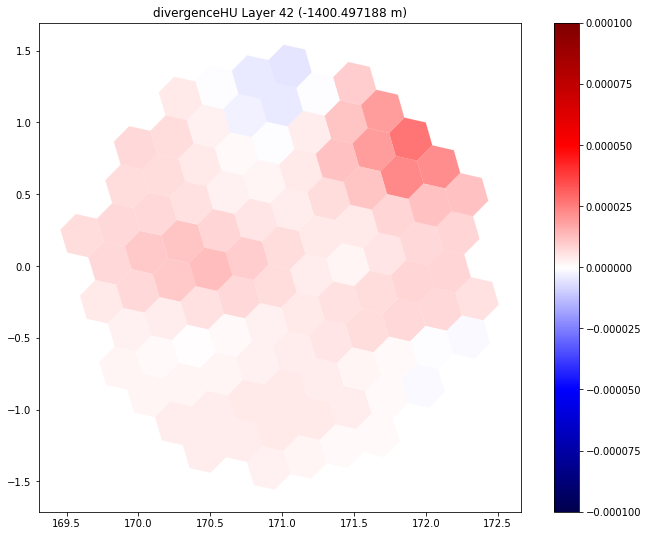

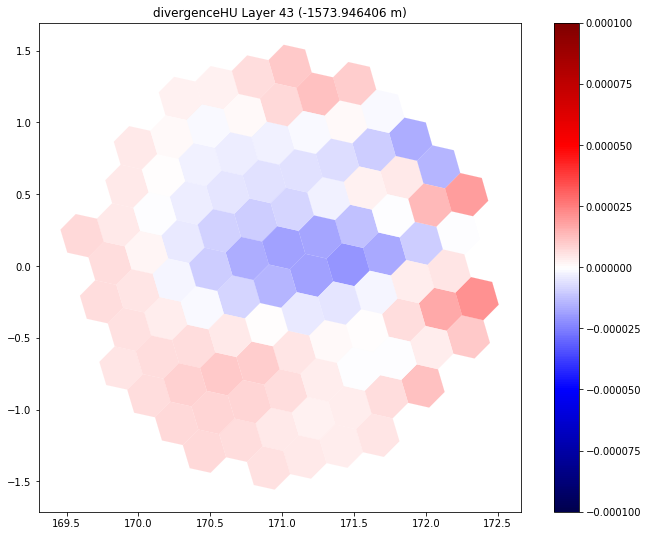

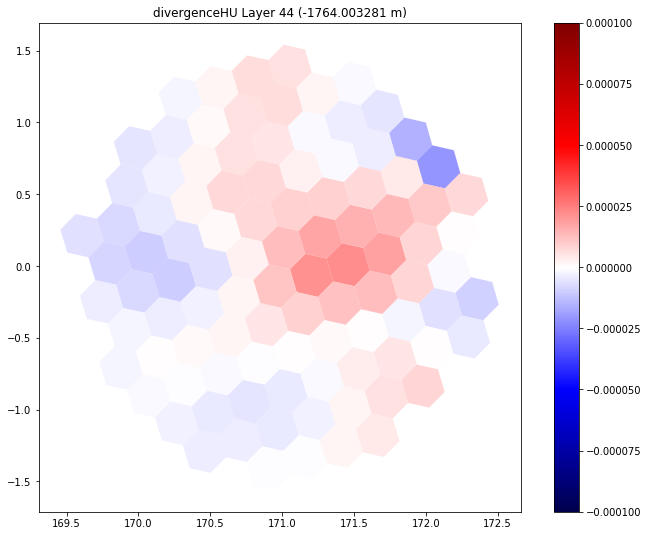

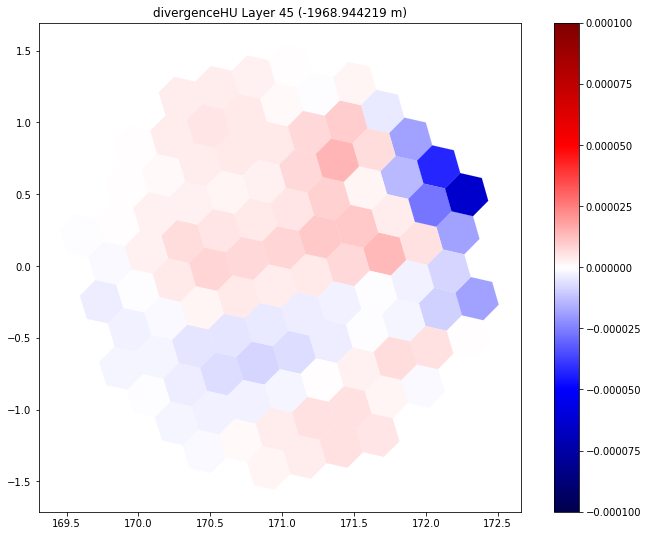

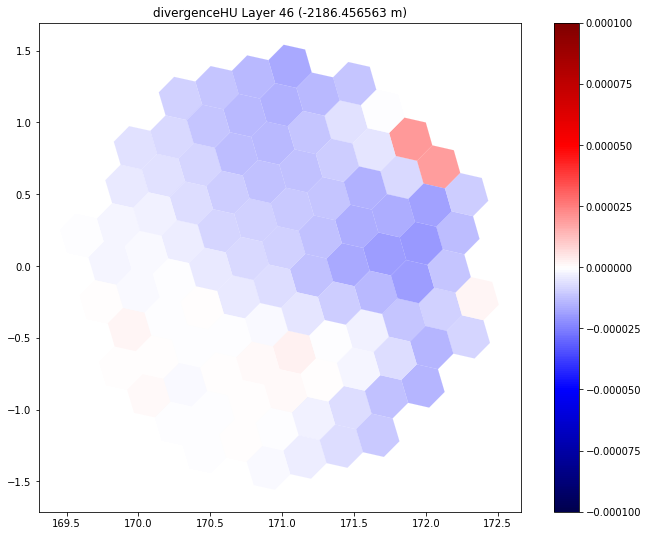

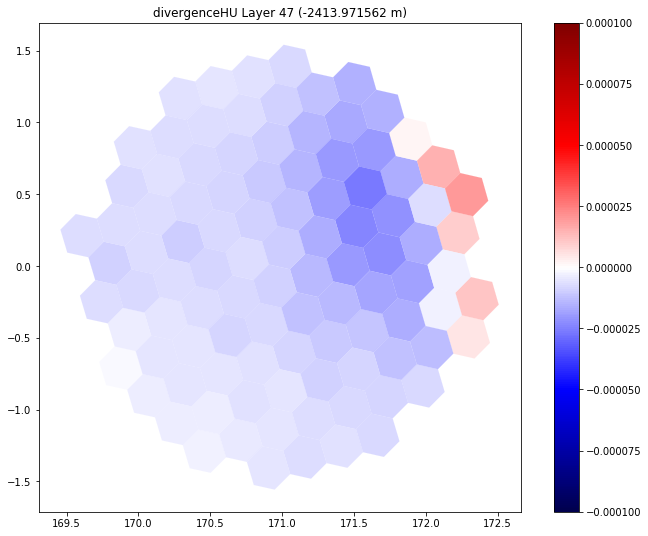

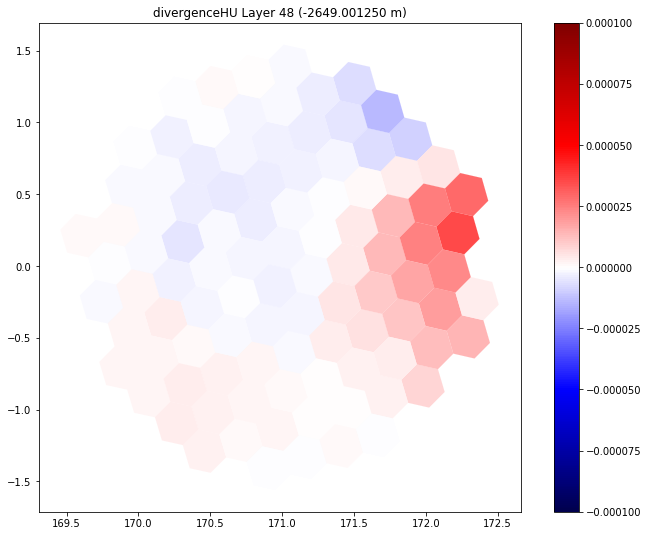

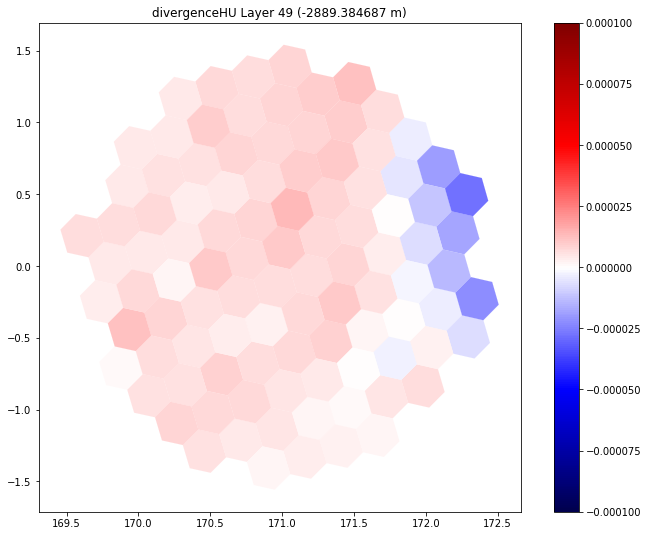

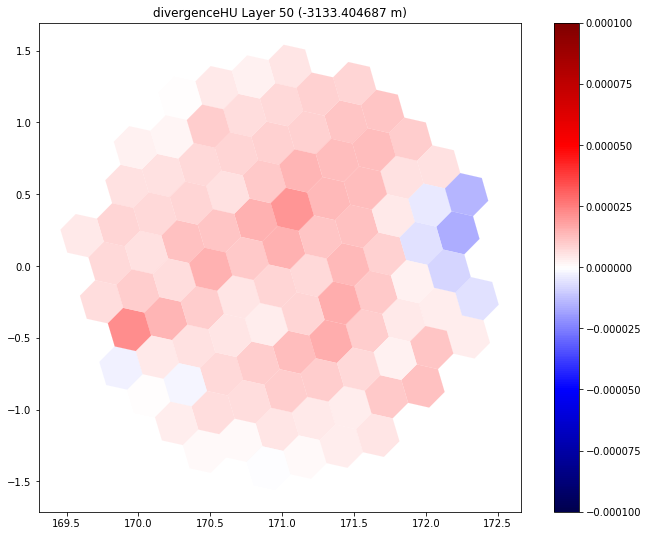

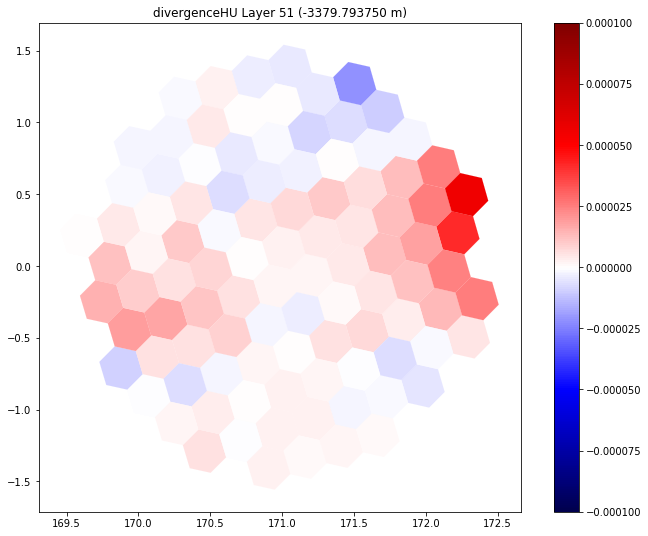

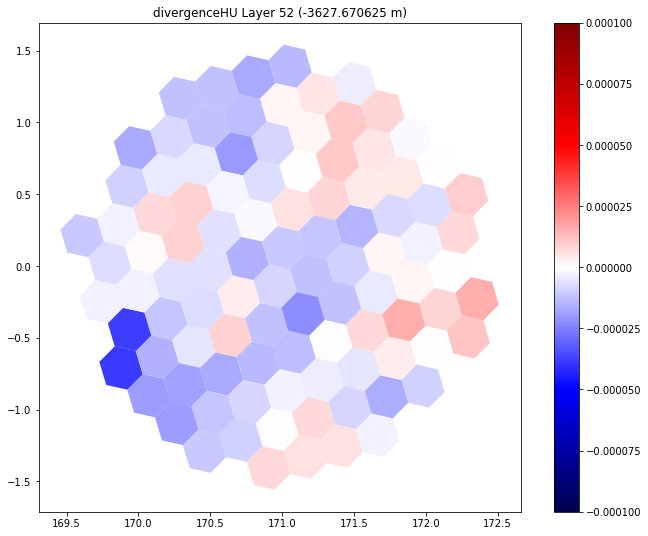

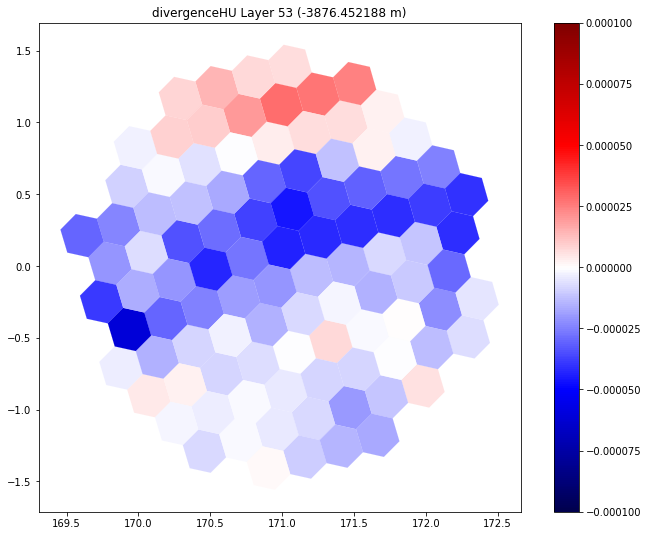

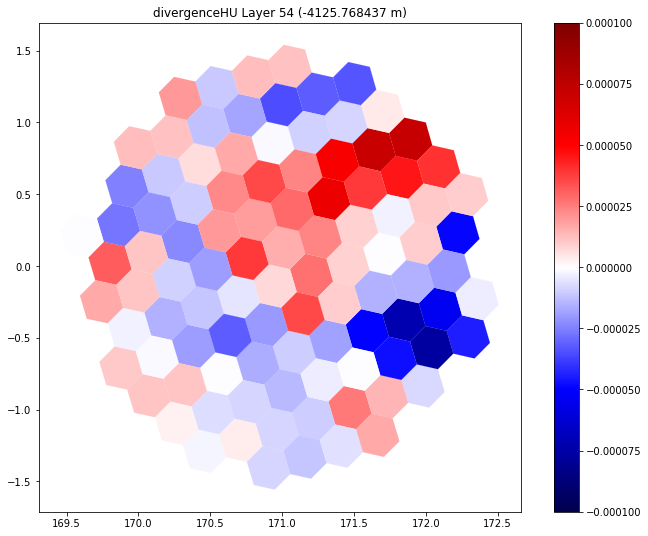

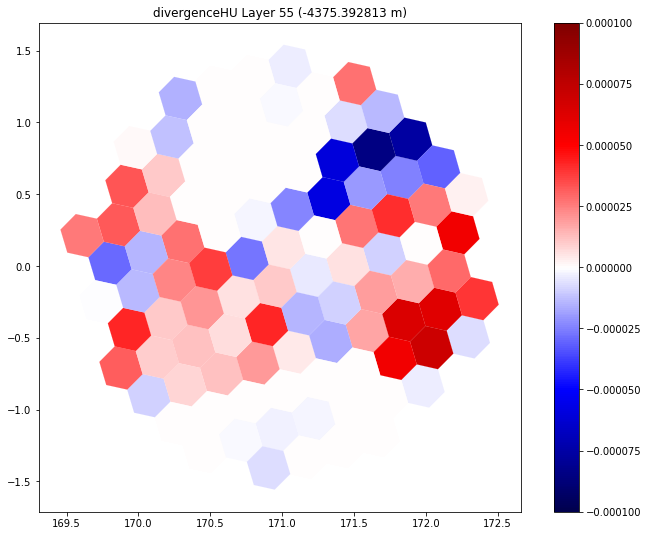

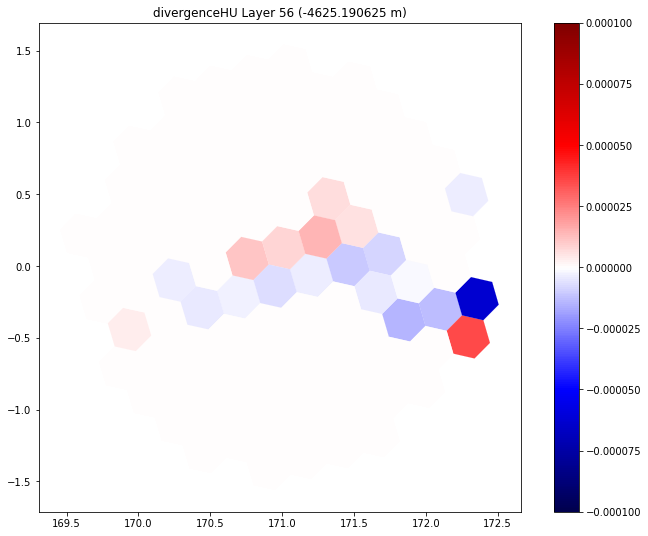

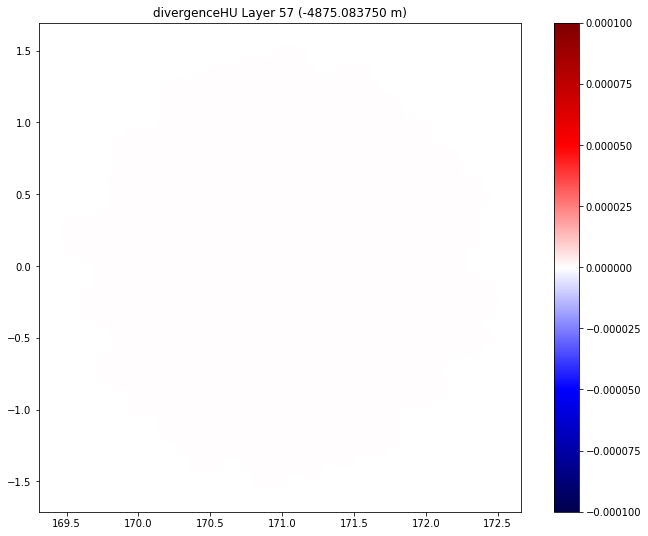

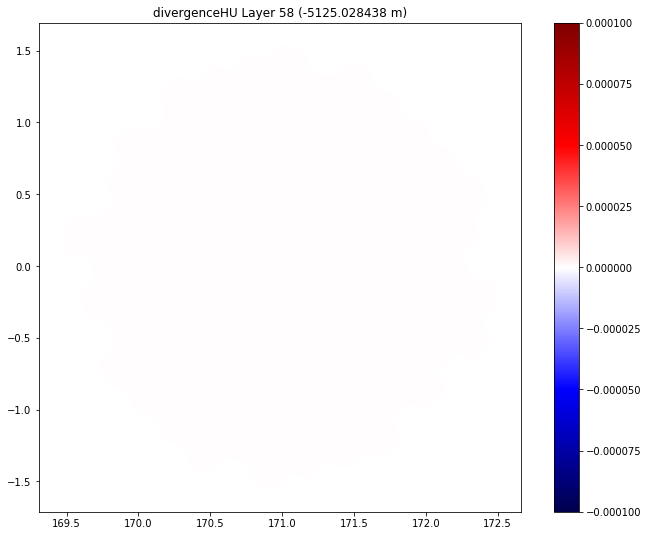

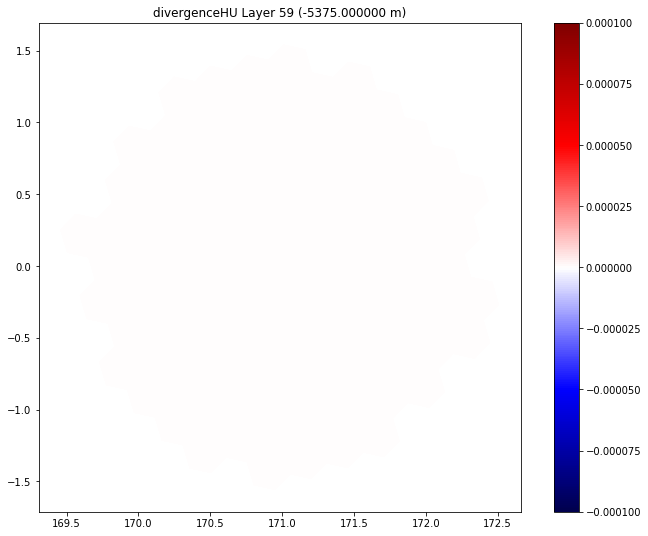

In [32]:
plot_profile(dspoints.divergenceHU, atime=iTime, dc=1e-4)